In [1]:
import os
import copy
import glob
import astropy.io.fits

import configparser

import numpy as np
import healpy

import scipy.interpolate

import pyccl as ccl

%matplotlib inline
import matplotlib.pyplot as plt

pi = np.pi

In [2]:
KCAP_PATH = "/Users/yooken/Research/KiDS/kcap/"

import sys
sys.path.append(os.path.join(KCAP_PATH, "kcap"))
import cosmosis_utils

# Todo

- Check FWHM of tSZ maps (10 vs 9.5 arcmin)
- Check f_sky for MILCA
- Measurements to do:
    - NILC
    - ~~half-difference x shear noise~~
    - half-difference auto on shear footprint
    - weigh by y variance map
    - deconvolve beam
- cov binning, beam (10' FWHM on Cl? Map?)

- Convolve CIB maps to same beam?
- ~~Check halo model P(k) at z > 0~~
- Namaster vs PolSpice

# Compute minimal model

In [41]:
import importlib
importlib.reload(cosmosis_utils)

<module 'cosmosis_utils' from '/Users/yooken/Research/KiDS/kcap/kcap/cosmosis_utils.py'>

In [42]:
class tSZPipelineFactory(cosmosis_utils.CosmoSISPipelineFactory):
    def create_base_config(self,
                           source_nz_files,
                           dz_covariance_file,
                           source_nz_sample,
                           y_filter_fwhm,
                           nside,
                           data_covariance_file,
                           data_file,
                           CIB_data_covariance_file,
                           CIB_data_file,
                           bin_operator_file
                          ):
        fields = ["matter", "pressure"]
        power_spectra_section = ["matter_pressure_power_spectrum", 
                                 "pressure_pressure_power_spectrum"]
        
        config = {  #"sample_ln_As"       : {"file" : "%(KCAP_PATH)s/utils/sample_ln_As.py",},
                                                
                    "sample_S8"       : {"file" : "%(KCAP_PATH)s/utils/sample_S8.py",
                                         "S8_name"    : "S_8_input"},
                    

                    "sigma8toAs"       : {"file" : "%(KCAP_PATH)s/utils/sigma8toAs.py",},
            
                    "correlate_dz"       : {"file" : "%(KCAP_PATH)s/utils/correlated_priors.py",
                                            "uncorrelated_parameters" : "nofz_shifts/p_1 nofz_shifts/p_2 nofz_shifts/p_3 nofz_shifts/p_4 nofz_shifts/p_5",
                                            "output_parameters"       : "nofz_shifts/bias_1 nofz_shifts/bias_2 nofz_shifts/bias_3 nofz_shifts/bias_4 nofz_shifts/bias_5",
                                            "covariance"              : dz_covariance_file,
                                           },

                    "camb"               : {"file" : "%(CSL_PATH)s/boltzmann/pycamb/camb_interface.py",
                                            "do_reionization"    : False,
                                            "mode"               : "transfer",
                                            "nonlinear"          : "none",
                                            "neutrino_hierarchy" : "normal",
                                            "kmax"               : 20.0,
                                            "zmid"               : 1.5,
                                            "nz_mid"             : 8,
                                            "zmax"               : 6.0,
                                            "nz"                 : 11,
                                            "background_zmax"    : 6.0,
                                            "background_zmin"    : 0.0,
                                            "background_nz"      : 6000,
                                            },
                  
                    "hmx"               :  {"file" : "%(HMX_PATH)s/cosmosis_interface.py",
                                            "mode"   : "HMx2020_matter_pressure",
                                            "fields" : " ".join(fields),
                                            
                                           },

                    "extrapolate_power" :  {"file" : "%(CSL_PATH)s/boltzmann/extrapolate/extrapolate_power.py",
                                            "kmax" : 500.0,
                                            "sections" : " ".join(power_spectra_section)},

                                            
                    "load_source_nz" :     {"file" : "%(CSL_PATH)s/number_density/load_nz/load_nz.py",
                                            "filepath" : " ".join(source_nz_files),
                                            "histogram" : True,
                                            "output_section" : f"nz_{source_nz_sample}"},
            
                    "source_photoz_bias" : {"file" : "%(CSL_PATH)s/number_density/photoz_bias/photoz_bias.py",
                                            "mode" : "additive",
                                            "sample" : f"nz_{source_nz_sample}",
                                            "bias_section" : "nofz_shifts",
                                            "interpolation" : "cubic",
                                            "output_deltaz" : True,
                                            "output_section_name" :  "delta_z_out"},
        
                    "linear_alignment" :   {"file" : "%(CSL_PATH)s/intrinsic_alignments/la_model/linear_alignments_interface.py",
                                            "method" : "bk_corrected",
                                            "X_matter_power_section" : "matter_pressure_power_spectrum",
                                            "X_intrinsic_power_output_section" : "pressure_intrinsic_power_spectrum",},

                    "projection" :         {"file" : "%(CSL_PATH)s/structure/projection/project_2d.py",
                                            "ell_min" : 2.0,
                                            "ell_max" : 6001.0,
                                            "n_ell"  : 400,
                                            "shear-shear" : f"{source_nz_sample}-{source_nz_sample}",
                                            "shear-y" : f"{source_nz_sample}-y",
                                            "intrinsic-y" : f"{source_nz_sample}-y",
                                            "verbose" : False,
                                            "get_kernel_peaks" : False},
            
                    "cib_contamination" :   {"file" : "%(TRIAD_PATH)s/tools/CIB_contamination.py",
                                             "cov_file" : CIB_data_covariance_file,
                                             "data_file" : CIB_data_file,
                                             "CIB_section" : "shear_CIB_cl",
                                             "tSZ_CIB_contamination_section" : "shear_y_CIB_contamination_cl",},
            
                    "beam_filter_cls" :    {"file" : "%(TRIAD_PATH)s/tools/filter_cls.py",
                                            "filter"            : "gaussian",
                                            "fwhm"              : y_filter_fwhm,
                                            "sections"          : "shear_y_cl y_y_cl intrinsic_y_cl",
                                            "powers"            : [1,2,1],
                                            "new_section_suffix" : "beam"},
            
                    "pixwin_filter_cls" :  {"file" : "%(TRIAD_PATH)s/tools/filter_cls.py",
                                            "filter"            : "healpix_window",
                                            "nside"              : nside,
                                            "sections"          : "shear_y_cl_beam y_y_cl_beam intrinsic_y_cl_beam",
                                            "powers"            : [2, 2, 2],
                                            "new_section_suffix" : "pixwin"},
            
                    "tSZ_like" :            {"file" : "%(TRIAD_PATH)s/tools/tsz_like.py",
                                             "like_name" : "tsz_like",
                                             "cov_file" : data_covariance_file,
                                             "data_file" : data_file,
                                             "bin_operator_file" : bin_operator_file,
                                             "input_section_name" : "shear_y_cl_beam_pixwin",
                                             "ia_section_name" : "intrinsic_y_cl_beam_pixwin",
                                             "cib_contamination_section_name" : "shear_y_CIB_contamination_cl_binned",
                                             "new_section_suffix" : "binned"
                                             }
        }
        return config
    
    @property
    def base_config_data_files(self):
        return [("correlate_dz", "covariance"),
                ("load_source_nz", "filepath"),
                ("cib_contamination", "data_file"),
                ("cib_contamination", "cov_file"),
                ("tSZ_like", "data_file"),
                ("tSZ_like", "cov_file"),
                ("tSZ_like", "bin_operator_file")]
    
    def create_base_params(self):
        params = {"cosmological_parameters" :      {"omch2"       : [ 0.051,  0.123355,      0.255],
                                                    "ombh2"       : [ 0.019,  0.022492,    0.026],
                                                    "h0"          : [ 0.64,   0.695021,       0.82],
                                                    "n_s"         : [ 0.84,   0.901206,      1.1],
                                                    "S_8_input"   : [ 0.1,    0.763871,    1.3],
                                                    #"ln_1e10_A_s" : [ 1.5,    2.72,      4.0],
                                                    "omega_k"     :           0.0,
                                                    "w"           :          -1.0,
                                                    "mnu"         :           0.06,             #normal hierarchy
                                                    }, 
                "halo_model_parameters" :          {"log10_Theat" : [ 7.0,    7.8,       8.5]},

                "intrinsic_alignment_parameters" : {"A"           : [-6.0,    1.066324,       6.0]},

                "cib_parameters" :                 {"alpha" :       [-4.3e-7, 2.3e-07,    8.9e-7]},

                "nofz_shifts"                    : {"p_1"         : 0.191855,
                                                    "p_2"         : 0.875148,
                                                    "p_3"         : -2.117530,
                                                    "p_4"         : -1.637583,
                                                    "p_5"         : 1.360465,},
        #         "nofz_shifts"                    : {"p_1"         : [-5.0,    0.191855,       5.0],
        #                                             "p_2"         : [-5.0,    0.875148,       5.0],
        #                                             "p_3"         : [-5.0,   -2.117530,       5.0],
        #                                             "p_4"         : [-5.0,   -1.637583,       5.0],
        #                                             "p_5"         : [-5.0,    1.360465,       5.0],},
                }
        return params
        
    
CSL_PATH = "%(KCAP_PATH)s/cosmosis-standard-library"
HMX_PATH = "%(KCAP_PATH)s/../HMx/python_interface/"
TRIAD_PATH = "/Users/yooken/Research/project_triad/KiDS1000_tSZ/"

NZ_DATA_PATH = "%(KCAP_PATH)s/../Cat_to_Obs_K1000_P1/data/kids/nofz/"
nz_files = [f"%(NZ_DATA_PATH)s/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO{i}_Nz.asc" for i in range(1,6)]
nz_cov_file = "%(NZ_DATA_PATH)s/SOM_cov_multiplied.asc"

XCORR_DATA_PATH = "../data/xcorr/"
cov_file = "%(XCORR_DATA_PATH)s/shear_y_KiDS1000_milca_TE_gaussian_cNG_cov.txt"
data_file = "%(XCORR_DATA_PATH)s/shear_y_KiDS1000_milca_TE.txt"
bin_op_file = "%(XCORR_DATA_PATH)s/bin_operator_w_spice_8_log_ell_bin_40-2000.txt"

CIB_cov_file = "%(XCORR_DATA_PATH)s/shear_CIB_KiDS1000_545_TE_jk_3.4deg2_beam10_cov.txt"
CIB_data_file = "%(XCORR_DATA_PATH)s/shear_CIB_KiDS1000_545_TE_beam10.txt"

PATHS = {"CSL_PATH" : CSL_PATH, 
         "KCAP_PATH" : KCAP_PATH, 
         "HMX_PATH" : HMX_PATH,
         "TRIAD_PATH" : TRIAD_PATH,}

DATA_DIRS = {"NZ_DATA_PATH" : NZ_DATA_PATH,
             "XCORR_DATA_PATH" : XCORR_DATA_PATH}

config = tSZPipelineFactory(options=dict(source_nz_files=nz_files, 
                               dz_covariance_file=nz_cov_file, 
                               source_nz_sample="KiDS1000",
                               y_filter_fwhm=10.0, nside=2048,
                               data_covariance_file=cov_file,
                               data_file=data_file,
                               CIB_data_covariance_file=CIB_cov_file,
                               CIB_data_file=CIB_data_file,
                               bin_operator_file=bin_op_file))

# config.run_pipeline(defaults={**PATHS, **DATA_DIRS})

sampler = "multinest"
run_name = f"base_setup"

config.add_sampling_config(dict(verbose=True,
                         debug=False,
                         sampler_name=sampler,
                         run_name=run_name))

root_dir = os.path.join("../runs/", run_name)
config.stage_files(root_dir=root_dir, 
                   defaults={"RUN_NAME": run_name, 
                             "ROOT_DIR": f"runs/%(RUN_NAME)s/",
                             **PATHS},
                   data_file_dirs=DATA_DIRS, copy_data_files=True)

Pre resolve:  %(NZ_DATA_PATH)s/SOM_cov_multiplied.asc
Post resolve:  /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_cov_multiplied.asc
Pre resolve:  %(NZ_DATA_PATH)s/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO1_Nz.asc %(NZ_DATA_PATH)s/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO2_Nz.asc %(NZ_DATA_PATH)s/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO3_Nz.asc %(NZ_DATA_PATH)s/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO4_Nz.asc %(NZ_DATA_PATH)s/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO5_Nz.asc
Post resolve:  /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO1_Nz.asc 

In [6]:
blocks = {}

In [43]:
for tag, config_update, params_update in [#("fid", {}, {}),
                                          ("cov", {"projection" : {"y-y" : "y-y"}}, {}),
#                                           ("cov_beam7", {"projection" : {"y-y" : "y-y"},
#                                                          "beam_filter_cls": {"fwhm": 7.071}}, {}),
                                          ("shear_only_halofit", {"camb" : {"zmid" : 2.0, 
                                                                     "nz_mid" : 16, "nz" : 20,
                                                                     "zmax" : 6.0,
                                                                     "nonlinear" : "pk",
                                                                     "halofit_version" : "takahashi"},
                                                            "hmx" : None,
                                                            "extrapolate_power" : {"sections" : "",
                                                                                   "kmax" : 500.0},
                                                           "source_photoz_bias" : None,
                                                           "linear_alignment" : None,
                                                           "projection" : {"shear-y" : None,
                                                                           "intrinsic-y" : None,
                                                                           "limber_rel_tol" : 1e-3},
                                                           "cib_contamination" : None,
                                                           "beam_filter_cls" : {"sections" : "", "powers" : ""},
                                                           "pixwin_filter_cls" : {"sections" : "", "powers" : ""},
                                                            "tSZ_like": None}, {}),
                                          
#                                           ("S8-0.746", {}, {"cosmological_parameters" : {"s_8_input" : 0.746}}),
#                                           ("S8-0.766", {}, {"cosmological_parameters" : {"s_8_input" : 0.766}}),
#                                           ("S8-0.786", {}, {"cosmological_parameters" : {"s_8_input" : 0.786}}),
                                          
#                                           ("logT-7.3", {}, {"halo_model_parameters" : {"log10_Theat" : 7.3}}),
#                                           ("logT-7.6", {}, {"halo_model_parameters" : {"log10_Theat" : 7.6}}),
#                                           ("logT-7.8", {}, {"halo_model_parameters" : {"log10_Theat" : 7.8}}),
#                                           ("logT-8.0", {}, {"halo_model_parameters" : {"log10_Theat" : 8.0}}),
#                                           ("logT-8.3", {}, {"halo_model_parameters" : {"log10_Theat" : 8.3}}),
                                         ]:
    config.reset_config()
    config.update_config(config_update)
    blocks[tag] = config.run_pipeline(defaults={**PATHS, **DATA_DIRS})

n(z) set to histogram mode. Bin centers are 0.025000 higher than edges.
Found 5 samples and 120 bins in redshift in file /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO1_Nz.asc /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO2_Nz.asc /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO3_Nz.asc /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO4_Nz.asc /Users/yooken/Research/KiDS/kcap//../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcol

# Load data

In [8]:
MEASUREMENT_DIR = "../../cosmosis_module/PROJECT_TRIAD/results/measurements/"

In [9]:
with astropy.io.fits.open(os.path.join(MEASUREMENT_DIR, "shear_KiDS1000_y/z0.1-0.3-milca/spice.kernel")) as hdu:
    spice_kernel = hdu[0].data[3]

In [10]:
ell = np.arange(spice_kernel.shape[1])

def make_binning_operator(x, x_min, x_max, n_bin, weights=None, binning="linear", squared=False, namaster=False):
    
    if binning == "linear":
        bin_edges = np.linspace(x_min, x_max, n_bin+1, endpoint=True)
    elif binning == "log":
        bin_edges = np.geomspace(x_min, x_max, n_bin+1, endpoint=True)
    else:
        raise ValueError(f"Binning type {binning} not supported.")
        
    w = np.ones_like(x, dtype=np.float64) if weights is None else weights

    if not namaster:
        B = np.zeros((n_bin, len(x)))
        for i in range(n_bin):
            M = np.logical_and(bin_edges[i] <= x, x < bin_edges[i+1])

            if squared:
                B[i,M] = w[M]**2/np.sum(w[M])**2
            else:
                B[i,M] = w[M]/np.sum(w[M])
        return B
    else:
        B = np.full(len(x), fill_value=-1, dtype=int)
        
        for i in range(n_bin):
            M = np.logical_and(bin_edges[i] <= x, x < bin_edges[i+1])
            B[M] = i
        return B
        


ell_min = 40
ell_max = 2000
n_ell_bin = 8
bin_kind = "log"

B = make_binning_operator(x=ell, x_min=ell_min, x_max=ell_max, n_bin=n_ell_bin, weights=(2*ell+1), binning=bin_kind)
B_cov = make_binning_operator(x=ell, x_min=ell_min, x_max=ell_max, n_bin=n_ell_bin, 
                              weights=(2*ell+1), binning=bin_kind, squared=True)

np.savetxt(f"../data/xcorr/bin_operator_{n_ell_bin}_{bin_kind}_ell_bin_{ell_min}-{ell_max}.txt", B)
np.savetxt(f"../data/xcorr/bin_operator_w_spice_{n_ell_bin}_{bin_kind}_ell_bin_{ell_min}-{ell_max}.txt", B @ spice_kernel.T)


In [11]:
y_maps = ["milca"]
CIB_maps = ["353", "545", "857"]

z_cuts = [(0.1, 0.3),
          (0.3, 0.5),
          (0.5, 0.7),
          (0.7, 0.9),
          (0.9, 1.2),
         ]

Cl_y_shear = {z : {y : {} for y in y_maps} for z in z_cuts}

Cl_CIB_shear = {z : {c : {} for c in CIB_maps} for z in z_cuts}

for z_cut in z_cuts:
    for y_map in y_maps:
        ell, TE, TB = np.loadtxt(os.path.join(MEASUREMENT_DIR, f"shear_KiDS1000_y/z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}/spice.cl"), 
                                 unpack=True, usecols=[0,7,8])

        Cl_y_shear[z_cut][y_map] = {"ell_raw"      : ell,
                                    "Cl_TE_raw"    : TE,
                                    "Cl_TB_raw"    : TB,
                                    "ell_binned"   : B @ ell,
                                    "Cl_TE_binned" : B @ TE,
                                    "Cl_TB_binned" : B @ TB}
        

def create_beam_operator(ell, fwhm=None, fwhm_map=None, fwhm_target=None):
    if fwhm is None and fwhm_target is not None:
        fwhm = np.sqrt(fwhm_target**2 - fwhm_map**2)
        
    sigma = fwhm/60.0/180.0*pi/(2.0*np.sqrt(2.0* np.log(2.0)))
    op = np.diag(np.exp(-0.5*ell**2*sigma**2))
    return op
        
for z_cut in z_cuts:
    for CIB_map in CIB_maps:
        ell, TE, TB = np.loadtxt(os.path.join(MEASUREMENT_DIR, f"shear_KiDS1000_CIB/z{z_cut[0]:.1f}-{z_cut[1]:.1f}-Planck-{CIB_map}/spice.cl"), 
                                 unpack=True, usecols=[0,7,8])
        
        
        beam10_operator = create_beam_operator(ell, fwhm_map=5.0, fwhm_target=10.0)
        
        Cl_CIB_shear[z_cut][CIB_map] = {"ell_raw"             : ell,
                                        "Cl_TE_raw"           : TE,
                                        "Cl_TB_raw"           : TB,
                                        "Cl_TE_raw_beam10"    : beam10_operator @ TE,
                                        "Cl_TB_raw_beam10"    : beam10_operator @ TB,
                                        "ell_binned"          : B @ ell,
                                        "Cl_TE_binned"        : B @ TE,
                                        "Cl_TB_binned"        : B @ TB,
                                        "Cl_TE_beam10_binned" : B @ beam10_operator @ TE,
                                        "Cl_TB_beam10_binned" : B @ beam10_operator @ TB}

# for y_map in y_maps:
#     data = [B @ ell]
#     for z_cut in z_cuts:
#         data.append(Cl_y_shear[z_cut][y_map]["Cl_TE_binned"])
#     np.savetxt(f"../data/xcorr/shear_y_KiDS1000_{y_map}_TE.txt", 
#                np.array(data).T, 
#                header=f"ell TE ({y_map} x KiDS-1000, z-bins: {', '.join([str(z) for z in z_cuts])})")
    

# for CIB_map in CIB_maps:
#     data = [B @ ell]
#     for z_cut in z_cuts:
#         data.append(Cl_CIB_shear[z_cut][CIB_map]["Cl_TE_binned"])
#     np.savetxt(f"../data/xcorr/shear_CIB_KiDS1000_{CIB_map}_TE.txt", 
#                np.array(data).T, 
#                header=f"ell TE ({CIB_map} x KiDS-1000, z-bins: {', '.join([str(z) for z in z_cuts])})")
    
# # Beam 10'
# for CIB_map in CIB_maps:
#     data = [B @ ell]
#     for z_cut in z_cuts:
#         data.append(Cl_CIB_shear[z_cut][CIB_map]["Cl_TE_beam10_binned"])
#     np.savetxt(f"../data/xcorr/shear_CIB_KiDS1000_{CIB_map}_TE_beam10.txt", 
#                np.array(data).T, 
#                header=f"ell TE ({CIB_map} x KiDS-1000, beam 10' FWHM, z-bins: {', '.join([str(z) for z in z_cuts])})")


In [12]:

def extract_Cl(block, z_cuts, ell=None, section="shear_y_cl"):
    Cl_dict = {}
    for i, z_cut in enumerate(z_cuts):
        ell_raw = block[section, "ell"]
        Cl_raw = block[section, f"bin_{i+1}_1"]
        
        Cl_beam = block[section+"_beam", f"bin_{i+1}_1"]
        Cl_beam_pixwin = block[section+"_beam_pixwin", f"bin_{i+1}_1"]
        Cl_binned = block[section+"_beam_pixwin_binned", f"bin_{i+1}_1"]
        ell_binned = block[section+"_beam_pixwin_binned", "ell"]

        Cl_dict[z_cut] = {"ell" : ell_raw,
                          "ell_binned" : ell_binned,
                          "Cl_raw"  : Cl_raw,
                          "Cl_beam"  : Cl_beam,
                          "Cl_beam_pixwin"  : Cl_beam_pixwin,
                          "Cl_smooth"  : Cl_beam_pixwin,
                          "Cl_binned"  : Cl_binned,
                          }
    return Cl_dict

Cl_y_shear_theory = {t: extract_Cl(blocks[t], z_cuts) for t in blocks if "shear_y_cl" in blocks[t]}
Cl_intrinsic_y_theory = {t: extract_Cl(blocks[t], z_cuts, section="intrinsic_y_cl") 
                         for t in blocks if "intrinsic_y_cl" in blocks[t]}

## Analytic covariance

In [13]:
import pyhmcode

class HaloProfileInterpolated(ccl.halos.HaloProfile):
    def __init__(self, interpolator, is_logk=True, is_logM=True, is_logp=True, norm=None):
        self.interpolator = interpolator
        self.is_logk = is_logk
        self.is_logM = is_logM
        self.is_logp = is_logp
        
        self.norm = norm or 1
    
    def _fourier(self, cosmo, k, M, a, mass_def):
        k_h = k/cosmo["h"]
        M_h = M*cosmo["h"]
        
        k_h = self._check_shape(k_h)
        M_h = self._check_shape(M_h)
        a = self._check_shape(a)
                
        k_h = np.log(k_h) if self.is_logk else k_h
        M_h = np.log(M_h) if self.is_logM else M_h
        
        positions = np.vstack([m.ravel() for m in np.meshgrid(a, k_h, M_h)]).T
        
        profile = self.interpolator(positions).reshape(len(k_h), len(M_h)).T
        
        if self.is_logp:
            #pre_exp = profile.min(), profile.max()
            profile = np.exp(profile)
            #print(f"a={a}, k: {k_h.min()}, {k_h.max()}, M: {M_h.min()}, {M_h.max()}", *pre_exp, profile.min(), profile.max())
            
        profile *= self.norm
            
        # Turn Mpc^3 h^-3 into Mpc^3
        profile *= cosmo["h"]**-3
            
        return profile.squeeze()
    
    def _check_shape(self, arr):
        if not isinstance(arr, np.ndarray):
            arr = np.array(arr)
        if arr.ndim < 1:
            arr = arr[None]
        return arr
            
    

class HMxProfileGenerator:
    def __init__(self, hmcode_cosmo, a_arr, k_arr, verbose=False):
        self.hmcode_cosmo = hmcode_cosmo
        self.hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=verbose)
        
        self.a_arr = a_arr.copy()
        self.k_arr = k_arr.copy()
        
        self.verbose = verbose
        
        self.fields = [pyhmcode.field_matter, pyhmcode.field_cdm, pyhmcode.field_electron_pressure]
        
        self._has_interpolator = False
        self._compute_tables()

        
    def _compute_tables(self):
        if self.verbose: print("Computing profile look-up table")
        
        profile_lut = np.empty((len(self.fields), len(self.a_arr), len(self.k_arr), self.hmod.n), dtype=np.float64)
        
        for a_idx, a in enumerate(self.a_arr):
            if self.verbose: print("Computing a = ", a)
            pyhmcode.hmx.init_halomod(a, self.hmod, self.hmcode_cosmo, self.verbose)
            for k_idx, k in enumerate(self.k_arr):
                wk = np.empty((self.hmod.n, len(self.fields)), order="f")
                pyhmcode.hmx.init_windows(k, self.fields, len(self.fields),
                                          wk, self.hmod.n,
                                          self.hmod, self.hmcode_cosmo)
                profile_lut[:,a_idx,k_idx] = wk.T
                
        # Turn electron pressure into physical units
        pressure_idx = self.fields.index(pyhmcode.field_electron_pressure)
        profile_lut[pressure_idx] *= self.a_arr[:,None,None]**-3
        
        profile_lut[profile_lut <= 1e-30] = 1e-30
        
        profile_interpolator = [scipy.interpolate.RegularGridInterpolator(
                                            points=(self.a_arr,
                                                    np.log(self.k_arr),
                                                    np.log(self.hmod.m)),
                                            values=np.log(profile_lut[f_idx]),
                                            method="linear",
                                            bounds_error=True, fill_value=None) 
                                for f_idx, f in enumerate(self.fields)]
        
        self.profiles = {f: HaloProfileInterpolated(profile_interpolator[f_idx],
                                                    is_logk=True, is_logM=True, is_logp=True,
                                                    norm=self.field_normalisation(f))
                         for f_idx, f in enumerate(self.fields)}
        
        self._has_interpolator = True
        
    def field_normalisation(self, field):
        if field == pyhmcode.field_cdm:
            return self.hmcode_cosmo.om_m/self.hmcode_cosmo.om_c
        else:
            return 1.0
        
    @property
    def matter_profile(self):
        if pyhmcode.field_matter in self.fields:
            return self.profiles[pyhmcode.field_matter]
        else:
            raise ValueError("Matter profiles not computed")
            
    @property
    def cdm_profile(self):
        if pyhmcode.field_cdm in self.fields:
            return self.profiles[pyhmcode.field_cdm]
        else:
            raise ValueError("CDM profiles not computed")
            
    @property
    def pressure_profile(self):
        if pyhmcode.field_electron_pressure in self.fields:
            return self.profiles[pyhmcode.field_electron_pressure]
        else:
            raise ValueError("Pressure profiles not computed")
            
            
class CovarianceCalculator:
    def __init__(self, lensing_stats, y_stats, data_block,
                 cov_binning_operator):
        self.noise_spectra = {"shear": {}, "y": {}}
        
        self.data_block = data_block
        self._has_halo_profiles = False
        
        # Create shear spectra
        for shear_bin, s in enumerate(lensing_stats["bins"]):
            def shear_noise_spectrum(ell,
                                     sigma_e=s["sigma_e"], n_eff=s["n_eff"]):
                return np.ones_like(ell)*sigma_e**2/(n_eff*60**2/(1/180*pi)**2)

            self.noise_spectra["shear"][str(shear_bin+1)] = shear_noise_spectrum
        
        # Create tSZ noise spectrum
        if "noise_file" in y_stats:
            self.noise_spectra["y"] = self.create_tSZ_noise_spectrum_from_measured_noise(
                                        noise_file=y_stats["noise_file"], 
                                        y_filter_fwhm=y_stats.get("y_filter_fwhm",
                                                                  None))
        elif "noise_model" in y_stats:
            self.noise_spectra["y"] = y_stats["noise_model"]
        
        self.f_sky = np.sqrt(lensing_stats["f_sky"]*y_stats["f_sky"])
        
        def section_suffix_mapping(probe_A, probe_B):
            if "y" in (probe_A, probe_B):
                return "_cl_beam_pixwin"
            else:
                return ""

        self.ell = np.arange(cov_binning_operator.shape[1])
        # Compute Gaussian covariances
        for name, noise_kwargs in [("gaussian", dict(noise=self.noise_spectra, noise_only=False)),
                                   ("gaussian_noise_only", dict(noise=self.noise_spectra, noise_only=True)),
                                   ("gaussian_no_noise", dict(noise=None, noise_only=False))]:
            cov = self.compute_gaussian_covariance(
                                probes=[(("shear", str(b)), "y")
                                        for b in self.noise_spectra["shear"]], 
                                data=data_block, 
                                ell=self.ell, f_sky=self.f_sky,
                                section_suffix_mapping=section_suffix_mapping,
                                binning_operator=cov_binning_operator,
                                **noise_kwargs)
            
            cov = np.vstack([np.hstack([np.diag(c) for c in c_i]) 
                                         for c_i in cov])
        
            setattr(self, name, cov)
            
    def create_tSZ_noise_spectrum_from_measured_noise(self, noise_file, y_filter_fwhm=None):
        ell_tSZ_raw, Cl_tSZ_raw_noise_homo = np.loadtxt(noise_file, unpack=True)
        
        if y_filter_fwhm is not None:
            sigma = y_filter_fwhm/60.0/180.0*pi/(2.0*np.sqrt(2.0* np.log(2.0)))
            Cl_tSZ_raw_noise_homo *= np.exp(-0.5*ell_tSZ_raw**2*sigma**2)**2

        intp = scipy.interpolate.InterpolatedUnivariateSpline(ell_tSZ_raw[2:], Cl_tSZ_raw_noise_homo[2:], ext=2)

        return intp
    

    def get_cl(self, block, suffix, probe_A, probe_B, bin_A, bin_B, ell,
               noise=None, noise_only=False):

        noise_spectrum = np.zeros(len(ell))
        if probe_A == probe_B and bin_A == bin_B:
            if noise is not None and probe_A in noise and bin_A in noise[probe_A]:
                noise_spectrum = noise[probe_A][bin_A](ell)

        if noise_only:
            return noise_spectrum

        if probe_A == "shear" and probe_B == "shear":
            section = "shear_cl"
            key = f"bin_{bin_A}_{bin_B}"
            if not block.has_value(section, key):
                key = f"bin_{bin_B}_{bin_A}"
        else:
            section = f"{probe_A}_{probe_B}{suffix}"
            key = f"bin_{bin_A}_{bin_B}"
            if section not in block:
                section = f"{probe_B}_{probe_A}{suffix}"
                key = f"bin_{bin_B}_{bin_A}"

        cl_raw = block[section, key]
        ell_raw = block[section, "ell"]

        if np.all(cl_raw > 0):
            intp = scipy.interpolate.InterpolatedUnivariateSpline(ell_raw, np.log(cl_raw), ext=2)
            cl = np.exp(intp(ell))
        else:
            intp = scipy.interpolate.InterpolatedUnivariateSpline(ell_raw, cl_raw, ext=2)
            cl = intp(ell)

        return cl + noise_spectrum

    def compute_gaussian_covariance(self, probes, data, ell,
                                    noise=None, f_sky=1, 
                                    section_suffix_mapping=None,
                                    binning_operator=None, noise_only=False):
        # Covariance between AB and CD
        
        suffix_mapping = section_suffix_mapping or (lambda probe_A, probe_B: "_cl")
        
        pad = np.count_nonzero(ell < 2)
        ell = ell[pad:]

        probes = [*probes]
        for i, (probe_A, probe_B) in enumerate(probes):
            probe_A = (probe_A, "1") if isinstance(probe_A, str) else probe_A
            probe_B = (probe_B, "1") if isinstance(probe_B, str) else probe_B
            probes[i] = (probe_A, probe_B)

        if noise is not None:
            noise = {**noise}
            for key, value in noise.items():
                if not isinstance(value, dict):
                    noise[key] = {"1" : value}

        cov_list = []
        for i, ((probe_A, bin_A), (probe_B, bin_B)) in enumerate(probes):
            cov_list.append([])
            for j, ((probe_C, bin_C), (probe_D, bin_D)) in enumerate(probes):
                if j < i:
                    C = cov_list[j][i]
                else:
                    Cl_AC = self.get_cl(data, suffix_mapping(probe_A, probe_C), probe_A, probe_C, bin_A, bin_C, ell, noise, noise_only)
                    Cl_BD = self.get_cl(data, suffix_mapping(probe_B, probe_D), probe_B, probe_D, bin_B, bin_D, ell, noise, noise_only)
                    Cl_AD = self.get_cl(data, suffix_mapping(probe_A, probe_D), probe_A, probe_D, bin_A, bin_D, ell, noise, noise_only)
                    Cl_BC = self.get_cl(data, suffix_mapping(probe_B, probe_C), probe_B, probe_C, bin_B, bin_C, ell, noise, noise_only)

                    C = 1/((2*ell+1)*f_sky)*(Cl_AC*Cl_BD + Cl_AD*Cl_BC)

                    C = np.concatenate((np.zeros(pad), C))
                    if binning_operator is not None:
                        C = binning_operator @ C
                cov_list[i].append(C)

        return cov_list
    
    def compute_non_gaussian_covariance(self,
                                        Cl_binning_operator,
                                        beam_fwhm=None,
                                        n_ell_interpolate=100,
                                        cNG_term=True, verbose=False):
        data_block = self.data_block
        self.ccl_cosmo = ccl.Cosmology(Omega_c=data_block["cosmological_parameters", "omega_c"],
                                       Omega_b=data_block["cosmological_parameters", "omega_b"],
                                       A_s=data_block["cosmological_parameters", "a_s"],
                                       n_s=data_block["cosmological_parameters", "n_s"],
                                       h=data_block["cosmological_parameters", "h0"],
                                       m_nu=data_block["cosmological_parameters", "mnu"],
                                      )
        
        if not self._has_halo_profiles:
            a_arr=np.linspace(1/(1+6), 1, 32) 
            k_arr=np.logspace(-5, 2, 100)
            self.compute_halo_profiles(data_block, a_arr, k_arr, verbose=verbose)
            
        if cNG_term:
            self.cNG = self.compute_cNG_covariance(data_block, 
                                                   fsky_eff, 
                                                   Cl_binning_operator,
                                                   beam_fwhm,
                                                   n_ell_interpolate,
                                                   verbose)

    def compute_halo_profiles(self, data_block, a_arr, k_arr, verbose=True):
        hmcode_cosmo = pyhmcode.Cosmology()

        hmcode_cosmo.om_m = data_block["cosmological_parameters", "omega_m"]
        hmcode_cosmo.om_b = data_block["cosmological_parameters", "omega_b"]
        hmcode_cosmo.om_v = data_block["cosmological_parameters", "omega_lambda"]
        hmcode_cosmo.h = data_block["cosmological_parameters", "h0"]
        hmcode_cosmo.ns = data_block["cosmological_parameters", "n_s"]
        hmcode_cosmo.sig8 = data_block["cosmological_parameters", "sigma_8"]
        hmcode_cosmo.m_nu = data_block["cosmological_parameters", "mnu"]

        hmcode_cosmo.set_linear_power_spectrum(data_block["matter_power_lin", "k_h"], 
                                               data_block["matter_power_lin", "z"], 
                                               data_block["matter_power_lin", "p_k"])

        self.halo_profiles = HMxProfileGenerator(hmcode_cosmo, 
                                                 a_arr=a_arr, k_arr=k_arr,
                                                 verbose=verbose)
        
        self._has_halo_profiles = True
        
    def compute_cNG_covariance(self, data_block, 
                               fsky_eff, 
                               binning_operator, 
                               beam_fwhm=None,
                               n_ell_interpolate=100, verbose=True):
        if not self._has_halo_profiles:
            raise RuntimeError("Halo profiles not computed yet.")

        mass_def = ccl.halos.MassDef("vir", 'matter')
        hmf = ccl.halos.MassFuncSheth99(self.ccl_cosmo, 
                                        mass_def=mass_def,
                                        mass_def_strict=False,
                                        use_delta_c_fit=True)
        hbf = ccl.halos.HaloBiasSheth99(self.ccl_cosmo,
                                        mass_def=mass_def,
                                        mass_def_strict=False,
                                        use_delta_c_fit=True)
        hmc = ccl.halos.HMCalculator(self.ccl_cosmo, hmf, hbf, mass_def)
        
        z_max = data_block["nz_kids1000", "z"][-1]

        a = np.linspace(1/(1+z_max), 1.0, 32)
        k = np.logspace(-4, 1.5, 100)

        if verbose:
            print("Computing halo model trispectrum")
        # Probably should switch the middle matter/pressure pair
        tk3D = ccl.halos.halomod_Tk3D_1h(cosmo=self.ccl_cosmo, hmc=hmc,
                            prof1=self.halo_profiles.matter_profile, 
                            prof2=self.halo_profiles.matter_profile,
                            prof12_2pt=None,
                            prof3=self.halo_profiles.pressure_profile, 
                            prof4=self.halo_profiles.pressure_profile,
                            prof34_2pt=None,
                            lk_arr=np.log(k), a_arr=a,
                            use_log=True)

        ell = self.ell
        ell_coarse = np.linspace(2, ell[-1], n_ell_interpolate)

        n_z_bin = data_block["nz_kids1000", "nbin"]
        
        WL_tracers = [ccl.WeakLensingTracer(self.ccl_cosmo, 
                                          dndz=(data_block["nz_kids1000", "z"], 
                                                data_block["nz_kids1000", f"bin_{WL_bin}"])
                                         ) for WL_bin in range(1, n_z_bin+1)]
        
        tSZ_tracer = ccl.tSZTracer(self.ccl_cosmo, z_max=z_max)
        
        if beam_fwhm is not None:
            beam_operator = create_beam_operator(ell, fwhm=beam_fwhm)
        else:
            beam_operator = None
        
        cov_NG = np.zeros((len(WL_tracers), len(WL_tracers), n_ell_bin, n_ell_bin))

        if verbose:
            print("Computing Cl cNG covariance term")
        for i, WL_tracer1 in enumerate(WL_tracers):
            for j, WL_tracer2 in enumerate(WL_tracers[:i+1]):
                cov_coarse = ccl.angular_cl_cov_cNG(cosmo=self.ccl_cosmo,
                                       cltracer1=WL_tracer1, cltracer2=WL_tracer2,
                                       cltracer3=tSZ_tracer, cltracer4=tSZ_tracer,
                                       ell=ell_coarse,
                                       tkka=tk3D, fsky=fsky_eff)
                cov = np.exp(scipy.interpolate.RectBivariateSpline(
                                                    ell_coarse, ell_coarse, 
                                                    np.log(cov_coarse))(ell, ell))
                if beam_operator is not None:
                    cov = beam_operator @ cov @ beam_operator

                cov_NG[i, j] = binning_operator @ cov @ binning_operator.T

        cov_NG_matrix = np.zeros((len(WL_tracers)*n_ell_bin, len(WL_tracers)*n_ell_bin))
        for i in range(cov_NG.shape[0]):
            for j in range(cov_NG.shape[0])[:i+1]:
                cov_NG_matrix[i*n_ell_bin:(i+1)*n_ell_bin, j*n_ell_bin:(j+1)*n_ell_bin] = cov_NG[i,j]
                if i != j:
                    cov_NG_matrix[j*n_ell_bin:(j+1)*n_ell_bin, i*n_ell_bin:(i+1)*n_ell_bin] = cov_NG[i,j]

        return cov_NG_matrix

KiDS1000_f_sky = 773.3/(4*pi*(180/pi)**2)

A_eff = 636.8005428
fsky_eff = A_eff/(4*pi*(180/pi)**2)

KiDS1000_stats = {"bins": [{"n_eff": 0.62, "sigma_e" : 0.27},
                           {"n_eff": 1.18, "sigma_e" : 0.26},
                           {"n_eff": 1.85, "sigma_e" : 0.27},
                           {"n_eff": 1.26, "sigma_e" : 0.25},
                           {"n_eff": 1.31, "sigma_e" : 0.27},],
                  "f_sky": fsky_eff}

Planck_milca_stats = {"noise_file" : os.path.join(MEASUREMENT_DIR, 
                                            "y_y/milca-half-difference-ellmax_4000/spice.cl"),
                      "f_sky": fsky_eff}

covariance = CovarianceCalculator(lensing_stats=KiDS1000_stats,
                                  y_stats=Planck_milca_stats,
                                  data_block=blocks["cov"],
                                  cov_binning_operator=B_cov)

covariance.compute_non_gaussian_covariance(Cl_binning_operator=B,
                                           beam_fwhm=10.0,
                                           n_ell_interpolate=100,
                                           verbose=True)



Computing profile look-up table
Computing a =  0.14285714285714285
Computing a =  0.1705069124423963
Computing a =  0.19815668202764977
Computing a =  0.22580645161290322
Computing a =  0.2534562211981567
Computing a =  0.28110599078341014
Computing a =  0.3087557603686636
Computing a =  0.33640552995391704
Computing a =  0.3640552995391705
Computing a =  0.39170506912442393
Computing a =  0.41935483870967744
Computing a =  0.4470046082949309
Computing a =  0.47465437788018433
Computing a =  0.5023041474654377
Computing a =  0.5299539170506913
Computing a =  0.5576036866359447
Computing a =  0.5852534562211982
Computing a =  0.6129032258064516
Computing a =  0.6405529953917051
Computing a =  0.6682027649769586
Computing a =  0.695852534562212
Computing a =  0.7235023041474655
Computing a =  0.7511520737327189
Computing a =  0.7788018433179724
Computing a =  0.8064516129032258
Computing a =  0.8341013824884793
Computing a =  0.8617511520737327
Computing a =  0.8894009216589862
Computing

## Load jackknife covariance

In [14]:
jk_data = np.load(os.path.join(MEASUREMENT_DIR, f"shear_KiDS1000_y/shear_KiDS1000_y_jk_data.npz"), allow_pickle=True)

In [15]:
jk_resolutions = [64, 128, 256]

cov_y_shear = {y : {j : {"TE" : None, "TB" : None} for j in jk_resolutions} for y in y_maps}

jk_weights = {y : {} for y in y_maps}

for y_map in y_maps:
    for z_cut in z_cuts:
        w = np.load(os.path.join(MEASUREMENT_DIR, f"shear_KiDS1000_y/z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}/jk_weights.npz"))
        for jk_res in w:
            if int(jk_res) not in jk_weights[y_map]:
                jk_weights[y_map][int(jk_res)] = w[jk_res]
            jk_weights[y_map][int(jk_res)] += w[jk_res]

for y_map in y_maps:
    for jk_res in jk_resolutions:
        d = []
        for z_cut in z_cuts:
            tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
            binned = np.einsum("ij,kjl->lik", B, jk_data[tag][str(jk_res)])
            d.append(binned)

        d = np.concatenate(d, axis=1)
        print(d.shape)
        
        v1 = np.sum(jk_weights[y_map][jk_res])
        v2 = np.sum(jk_weights[y_map][jk_res]**2)
        jk_area = jk_res**2 * 4*pi/(12*2048**2)*(180/pi)**2
        cov_y_shear[y_map][jk_res]["area"] = jk_area
        cov_y_shear[y_map][jk_res]["N"] = d.shape[-1]
        
        n_jk = d.shape[-1]
        
        expected_weight = v1/773.3*jk_area*n_jk
        effective_n_jk = n_jk * 773.3/(jk_area*n_jk)
        effective_n_jk = n_jk
        
#         cov_y_shear[y_map][jk_res]["TE"] = np.cov(d[0], aweights=jk_weights[y_map][jk_res], ddof=1) * (effective_n_jk-1)**2/effective_n_jk
#         cov_y_shear[y_map][jk_res]["TB"] = np.cov(d[1], aweights=jk_weights[y_map][jk_res], ddof=1) * (effective_n_jk-1)**2/effective_n_jk
        
        cov_y_shear[y_map][jk_res]["TE"] = np.cov(d[0], ddof=1) * (effective_n_jk-1)**2/effective_n_jk
        cov_y_shear[y_map][jk_res]["TB"] = np.cov(d[1], ddof=1) * (effective_n_jk-1)**2/effective_n_jk
       
        

(2, 40, 449)
(2, 40, 143)
(2, 40, 54)


In [32]:
bs_shear_data = np.load(os.path.join(MEASUREMENT_DIR, f"shear_KiDS1000_y/shear_KiDS1000_y_bs_shear.pickle"), allow_pickle=True)

cov_y_shear_bs_shear = {y : {j : {"TE" : None, "TB" : None} for j in jk_resolutions} for y in y_maps}

for y_map in y_maps:
    for jk_res in jk_resolutions:
        d = []
        for z_cut in z_cuts:
            tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
            binned = np.einsum("ij,kjl->lik", B, bs_shear_data[tag][str(jk_res)])
            d.append(binned)

        d = np.concatenate(d, axis=1)
        print(d.shape)
        
        n_bs = d.shape[-1]        
        cov_y_shear_bs_shear[y_map][jk_res]["TE"] = np.cov(d[0], ddof=1)
        cov_y_shear_bs_shear[y_map][jk_res]["TB"] = np.cov(d[1], ddof=1)


(2, 40, 500)
(2, 40, 500)
(2, 40, 500)


## Bootstrap after jackknife

In [281]:
cov_y_shear_baj = {y : {j : {"TE" : None, "TB" : None} for j in jk_resolutions} for y in y_maps}

cov_y_shear_wbs = {y : {j : {"TE" : None, "TB" : None} for j in jk_resolutions} for y in y_maps}

for y_map in y_maps:
    for jk_res in jk_resolutions:
        d = []
        for z_cut in z_cuts:
            tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
            binned = np.einsum("ij,kjl->lik", B, jk_data[tag][str(jk_res)])
            d.append(binned)

        d = np.concatenate(d, axis=1)
        full_d = np.concatenate([Cl_y_shear[z_cut][y_map]["Cl_TE_binned"] for z_cut in z_cuts])
        
        
        jk_area = jk_res**2 * 4*pi/(12*2048**2)*(180/pi)**2
        n_jk = d.shape[-1]
        effective_n_jk = n_jk * 773.3/(jk_area*n_jk)
#         effective_n_jk = n_jk
        
        w = jk_weights[y_map][jk_res]
        w = w/w.sum()
        
        r = (n_jk*full_d - (n_jk-1)*d[0].T)/np.sqrt(n_jk)
        r = (full_d - ((1-w)*d[0]).T)

        cov_y_shear_baj[y_map][jk_res]["TE"] = np.cov(r.T, aweights=jk_weights[y_map][jk_res], ddof=1) * (effective_n_jk-1)**2/effective_n_jk
        #cov_y_shear_baj[y_map][jk_res]["TE"] = np.cov(r.T, ddof=1) * (effective_n_jk-1)**2/effective_n_jk
        
        r = (full_d - d[0].T)
        wbs = d[0].T + r[None,...]*np.random.randn(1000,n_jk,1)
        
        wbs = np.mean(wbs, axis=0)
        cov_y_shear_wbs[y_map][jk_res]["TE"] = np.cov(wbs.T)*n_jk
        
        
        

## Joint y-CIB covariance

In [16]:
CIB_jk_data = np.load(os.path.join(MEASUREMENT_DIR, f"shear_KiDS1000_CIB/shear_KiDS1000_CIB_jk_w64_data.npz"), allow_pickle=True)


In [17]:
jk_resolutions = [64, 128, 256]

cov_CIB_shear = {c : {j : {"TE" : None, "TB" : None} for j in jk_resolutions} for c in CIB_maps}

ell = np.arange(3001)
beam10_operator = create_beam_operator(ell, fwhm_map=5.0, fwhm_target=10.0)

for CIB_map in CIB_maps:
    for jk_res in [64, 128, 256]:
        d_CIB = []
        for z_cut in z_cuts:
            tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-Planck-{CIB_map}"
            Cl = CIB_jk_data[tag][str(jk_res)]
            binned = np.einsum("ij,kjl->lik", B@beam10_operator, Cl)
            d_CIB.append(binned)

        d = np.concatenate(d_CIB, axis=1)
        print(d.shape)
        n_jk = d.shape[-1]
        effective_n_jk = n_jk
        
        cov_CIB_shear[CIB_map][jk_res]["TE"] = np.cov(d[0], ddof=1) * (effective_n_jk-1)**2/effective_n_jk
        cov_CIB_shear[CIB_map][jk_res]["TB"] = np.cov(d[1], ddof=1) * (effective_n_jk-1)**2/effective_n_jk

(2, 40, 449)
(2, 40, 143)
(2, 40, 54)
(2, 40, 449)
(2, 40, 143)
(2, 40, 54)
(2, 40, 449)
(2, 40, 143)
(2, 40, 54)


In [64]:
y_map = "milca"

cov_y_CIB_shear = {c : {j : {"TE" : None, "TB" : None} for j in jk_resolutions} for c in CIB_maps}

for CIB_map in CIB_maps:
    for jk_res in [64, 128, 256]:
        d_y = []
        for z_cut in z_cuts:
            tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
            binned = np.einsum("ij,kjl->lik", B, jk_data[tag][str(jk_res)])
            d_y.append(binned)

        d_CIB = []
        for z_cut in z_cuts:
            tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-Planck-{CIB_map}"
            binned = np.einsum("ij,kjl->lik", B, CIB_jk_data[tag][str(jk_res)])
            d_CIB.append(binned)

        d = np.concatenate((np.concatenate(d_y, axis=1), np.concatenate(d_CIB, axis=1)), axis=1)
        print(d.shape)
        cov_y_CIB_shear[CIB_map][jk_res]["TE"] = np.cov(d[0], aweights=jk_weights[y_map][jk_res])*d.shape[-1]
        cov_y_CIB_shear[CIB_map][jk_res]["TB"] = np.cov(d[1], aweights=jk_weights[y_map][jk_res])*d.shape[-1]

        jk_area = jk_res**2 * 4*pi/(12*2048**2)*(180/pi)**2
        cov_y_CIB_shear[CIB_map][jk_res]["area"] = jk_area
        cov_y_CIB_shear[CIB_map][jk_res]["N"] = d.shape[-1]

(2, 80, 449)
(2, 80, 143)
(2, 80, 54)
(2, 80, 449)
(2, 80, 143)
(2, 80, 54)
(2, 80, 449)
(2, 80, 143)
(2, 80, 54)


## Randomised shear

In [18]:
random_shear_data = np.load(os.path.join(MEASUREMENT_DIR, "shear_KiDS1000_y/shear_KiDS1000_y_random_shear.npz"))


In [19]:
ell = np.arange(3001)

B_lin_fine = make_binning_operator(x=ell, x_min=100, x_max=2500, n_bin=24, weights=(2*ell+1), binning="linear")
B_lin_fine_cov = make_binning_operator(x=ell, x_min=100, x_max=2500, n_bin=24, weights=(2*ell+1), 
                                       binning="linear", squared=True)

y_map = "milca_half_difference"
d = []
for z_cut in z_cuts:
    tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
    binned = np.einsum("ij,kjl->lik", B_lin_fine, random_shear_data[tag])
    d.append(binned)
    
d = np.concatenate(d, axis=1)
cov_random_shear = np.cov(d[0])

In [21]:
def noise_covariance_loss(fsky_eff):
    KiDS1000_stats = {"bins": [{"n_eff": 0.62, "sigma_e" : 0.27},
                               {"n_eff": 1.18, "sigma_e" : 0.26},
                               {"n_eff": 1.85, "sigma_e" : 0.27},
                               {"n_eff": 1.26, "sigma_e" : 0.25},
                               {"n_eff": 1.31, "sigma_e" : 0.27},],
                      "f_sky": fsky_eff}

    Planck_milca_stats = {"noise_file" : os.path.join(MEASUREMENT_DIR, 
                                                "y_y/milca-half-difference-ellmax_4000/spice.cl"),
                          "f_sky": fsky_eff}

    covariance = CovarianceCalculator(lensing_stats=KiDS1000_stats,
                                      y_stats=Planck_milca_stats,
                                      data_block=blocks["cov"],
                                      cov_binning_operator=B_lin_fine_cov)
    
    return np.sum((np.diag(cov_random_shear)*1e28 - np.diag(covariance.gaussian_noise_only)*1e28)**2)

result = scipy.optimize.minimize(noise_covariance_loss, x0=KiDS1000_f_sky)

fsky_eff = result.x
print("A_eff", fsky_eff*4*pi*(180/pi)**2)

KiDS1000_stats = {"bins": [{"n_eff": 0.62, "sigma_e" : 0.27},
                           {"n_eff": 1.18, "sigma_e" : 0.26},
                           {"n_eff": 1.85, "sigma_e" : 0.27},
                           {"n_eff": 1.26, "sigma_e" : 0.25},
                           {"n_eff": 1.31, "sigma_e" : 0.27},],
                  "f_sky": fsky_eff}

Planck_milca_stats = {"noise_file" : os.path.join(MEASUREMENT_DIR, 
                                            "y_y/milca-half-difference-ellmax_4000/spice.cl"),
                      "f_sky": fsky_eff}

covariance_lin_fine = CovarianceCalculator(lensing_stats=KiDS1000_stats,
                                  y_stats=Planck_milca_stats,
                                  data_block=blocks["cov"],
                                  cov_binning_operator=B_lin_fine_cov)

A_eff [636.80083329]


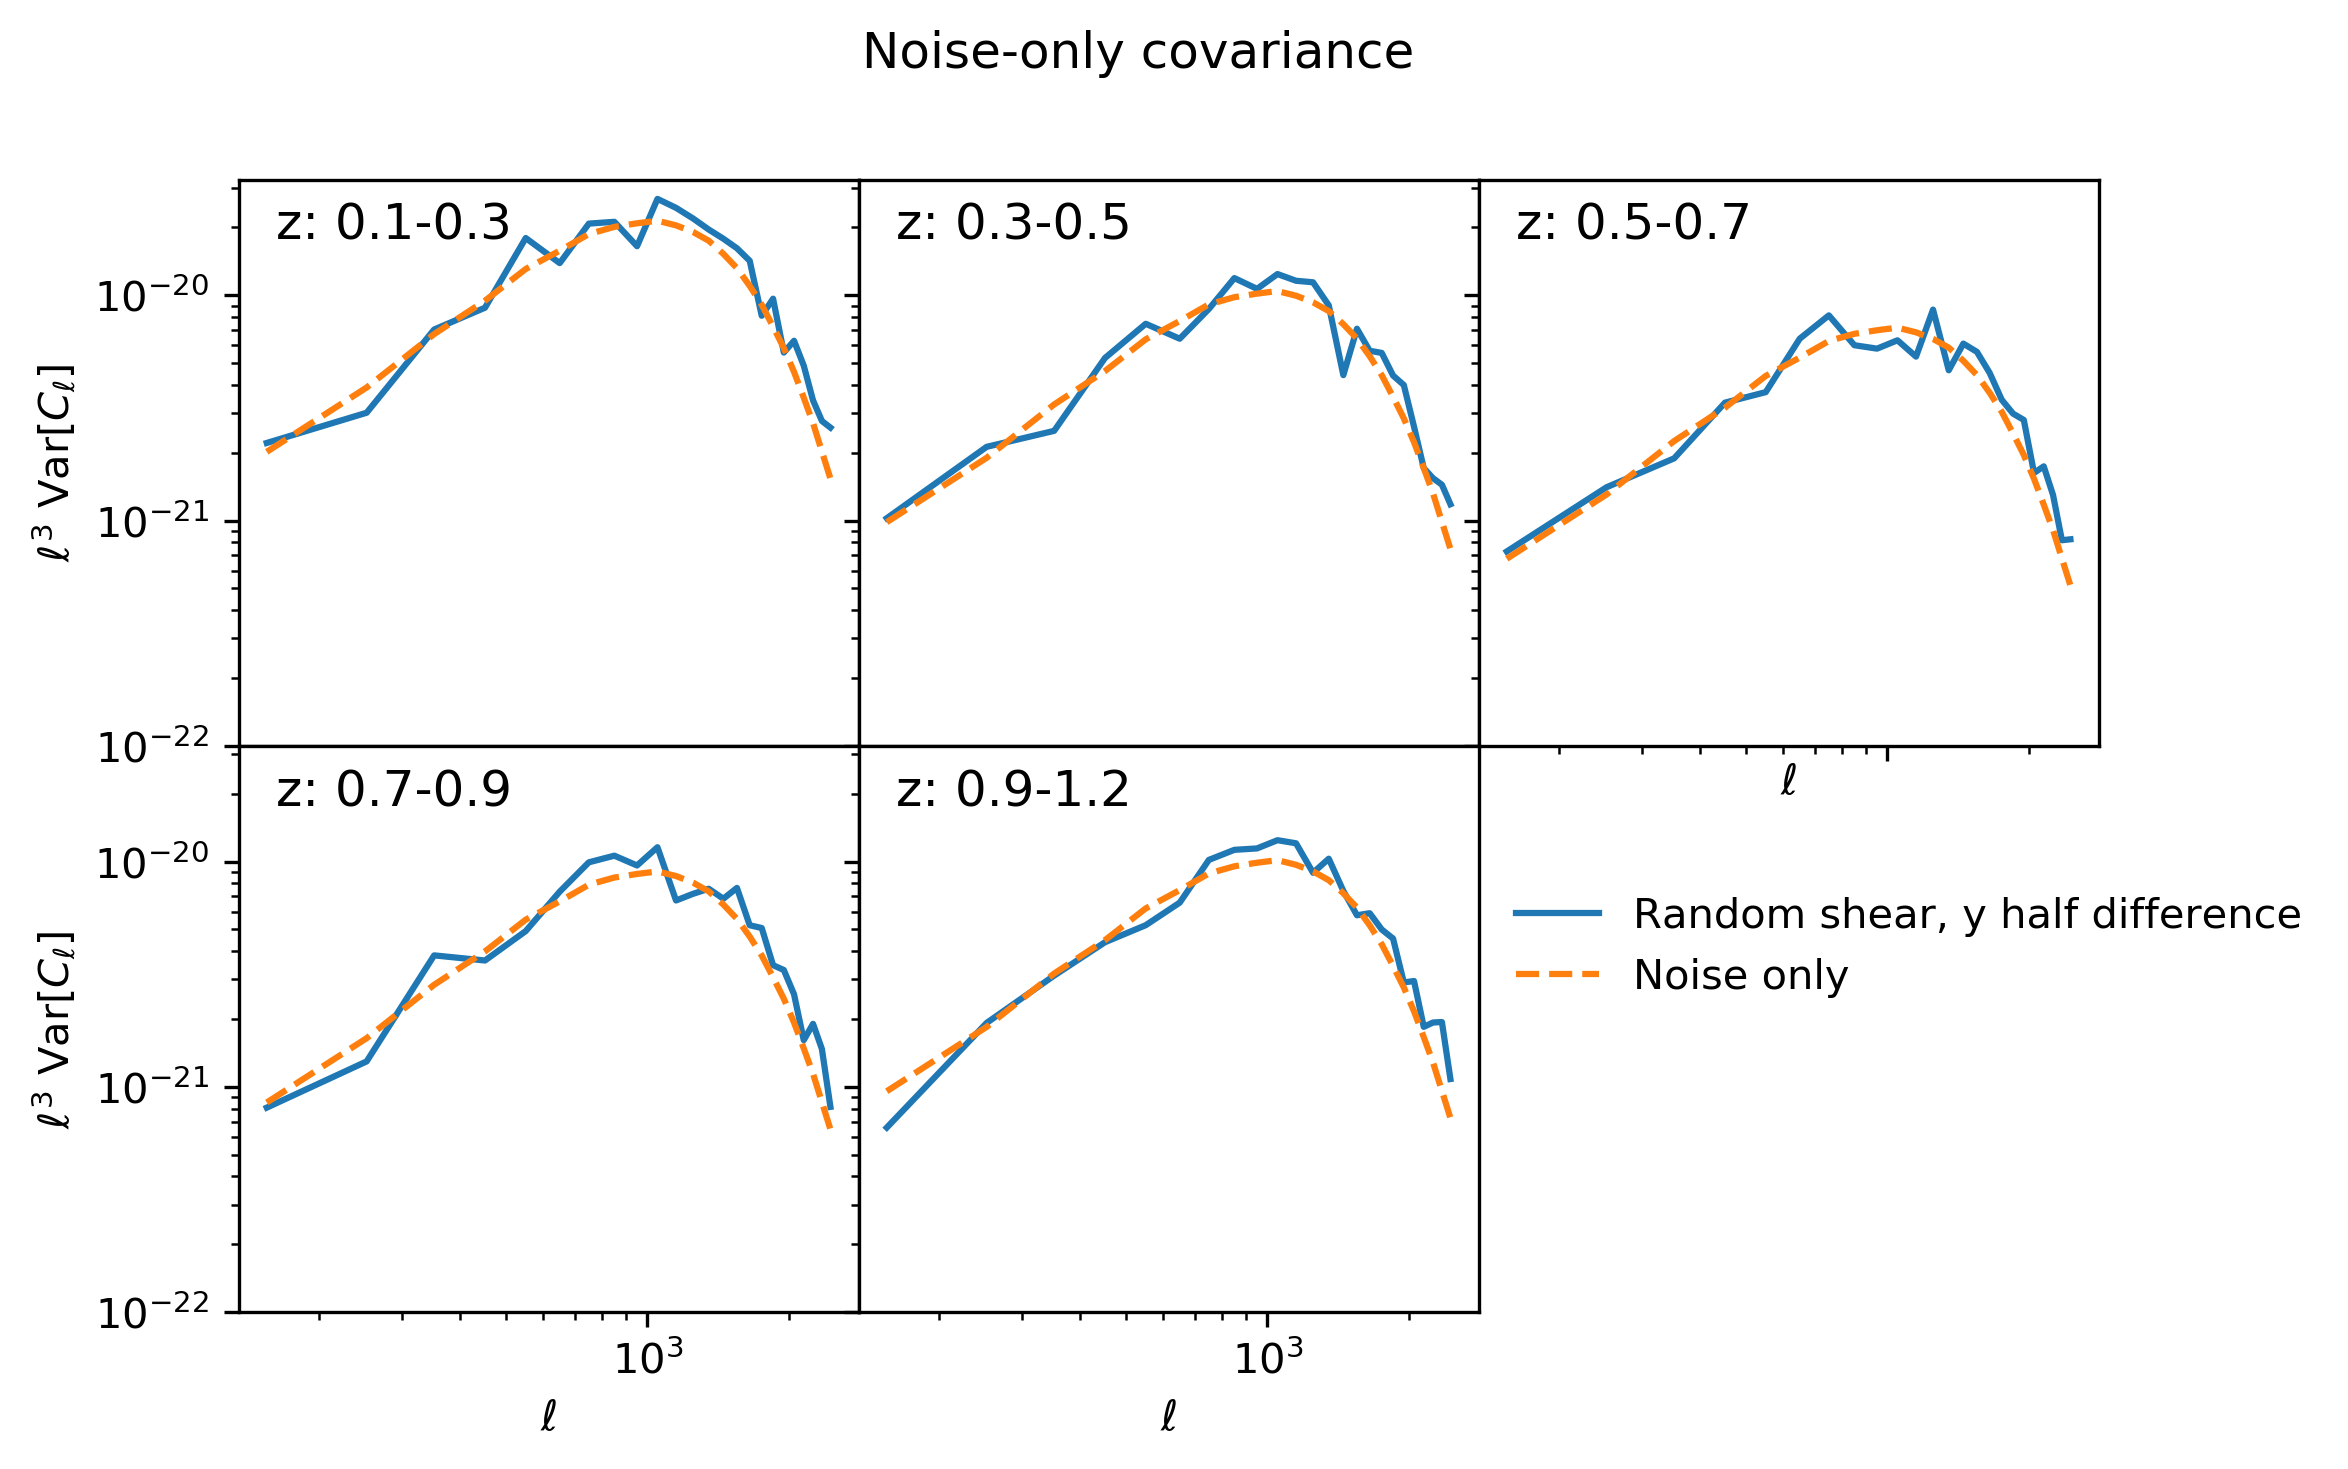

In [22]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i, z_cut in enumerate(z_cuts):
    ell_eff = B_lin_fine @ ell
    u = ell_eff**3
    cov = cov_random_shear
    var = np.diag(cov)[B_lin_fine.shape[0]*i:B_lin_fine.shape[0]*(i+1)]

    ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, y half difference")

    cov = covariance_lin_fine.gaussian_noise_only
    var = np.diag(cov)[B_lin_fine.shape[0]*i:B_lin_fine.shape[0]*(i+1)]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"Noise only")
    
    
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell^3\ {\rm Var}[C_\ell]$") for p in ax]
ax.flatten()[-1].axis("off")
ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax[0,0].set_ylim(bottom=1e-22)

fig.suptitle("Noise-only covariance")
fig.dpi = 300
fig.savefig("plots/noise_only_covariance.png")

# Plot data

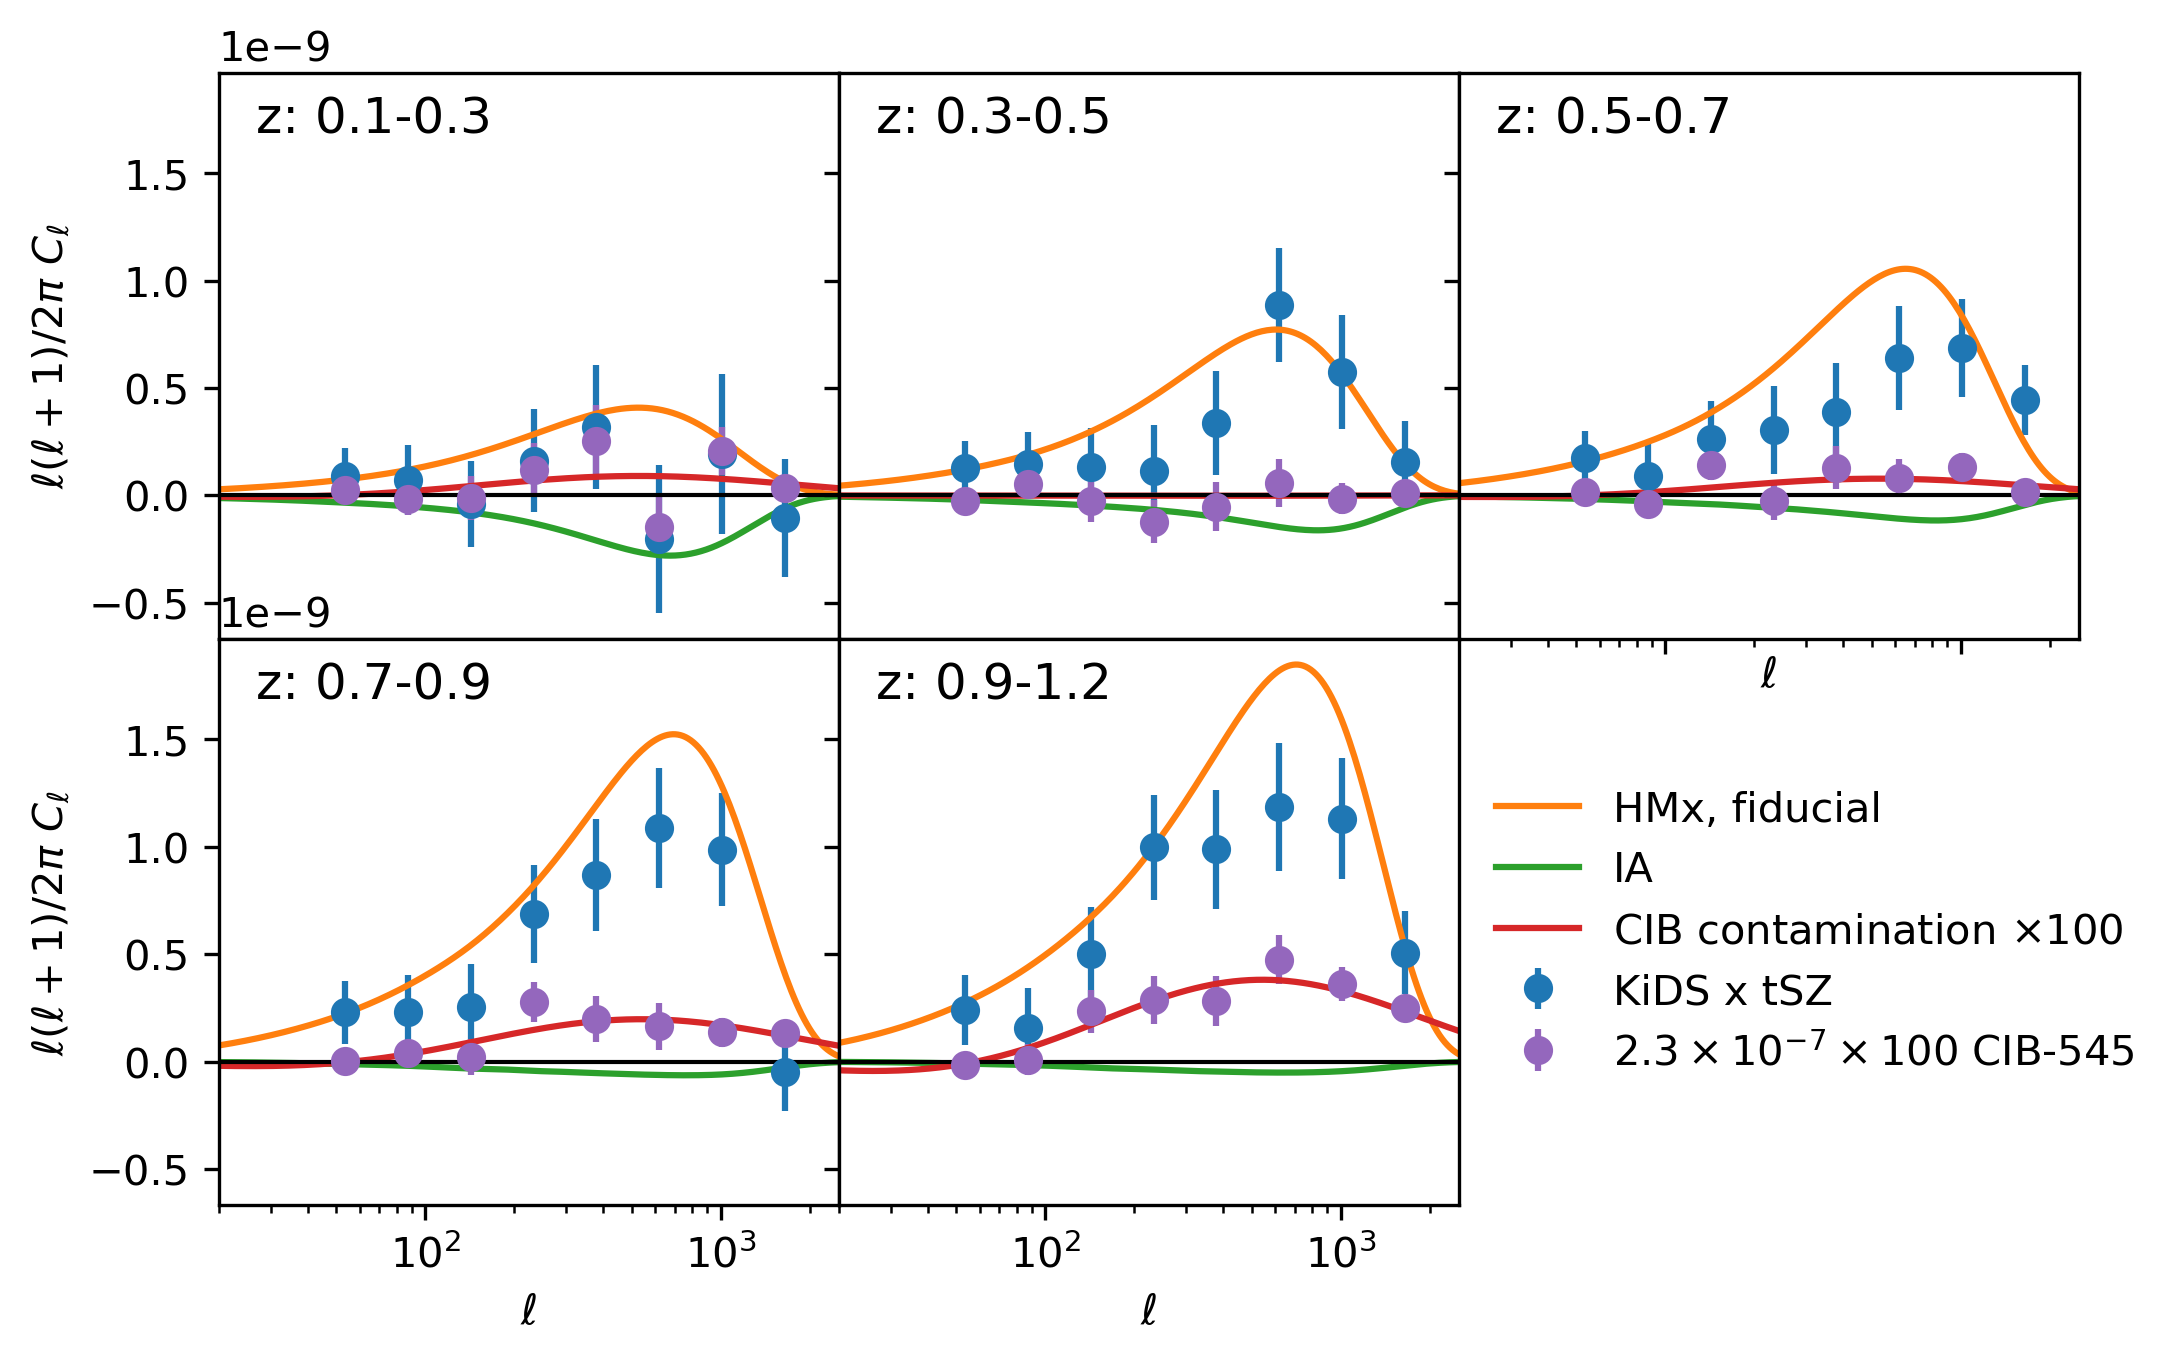

In [23]:
y_map = "milca"

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

cmap = plt.get_cmap("magma")

plots = ["fid", 
         "ia",
         "CIB",
         "CIB_data",
         #"S8",
         #"logT",
        ]

for i, z_cut in enumerate(z_cuts):
    ell, Cl = Cl_y_shear[z_cut][y_map]["ell_binned"], Cl_y_shear[z_cut][y_map]["Cl_TE_binned"]
    cov = covariance.gaussian + covariance.cNG
    error = np.sqrt(np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)])
    u = ell**2/(2*pi)
    
    ax.flatten()[i].errorbar(ell, u*Cl, u*error, ls="none", marker="o", label="KiDS x tSZ")
    
    if "fid" in plots:
        tag = "cov"
        ell_theory = Cl_y_shear_theory[tag][z_cut]["ell"]
        Cl_theory = Cl_y_shear_theory[tag][z_cut]["Cl_smooth"]
        u = ell_theory**2/(2*pi)
        ax.flatten()[i].plot(ell_theory, u*Cl_theory, label=f"HMx, fiducial")
        
    if "ia" in plots:
        tag = "cov"
        ell_theory = Cl_y_shear_theory[tag][z_cut]["ell"]
        Cl_theory = Cl_intrinsic_y_theory[tag][z_cut]["Cl_smooth"]
        u = ell_theory**2/(2*pi)
        ax.flatten()[i].plot(ell_theory, u*Cl_theory, label=f"IA")
        
    if "CIB" in plots:
        tag = "cov"
        ell_theory = blocks[tag]["shear_y_CIB_contamination_cl", "ell"]
        Cl_theory = blocks[tag]["shear_y_CIB_contamination_cl", f"bin_{i+1}_1"]
        u = ell_theory**2/(2*pi) * 100
        ax.flatten()[i].plot(ell_theory, u*Cl_theory, label=f"CIB contamination $\\times 100$")
        
    if "CIB_data" in plots:
        ell = Cl_CIB_shear[z_cut]["545"]["ell_binned"]
        Cl = Cl_CIB_shear[z_cut]["545"]["Cl_TE_beam10_binned"]
        
        cov = cov_CIB_shear["545"][128]["TE"]
        error = np.sqrt(np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)])
        u = ell**2/(2*pi) * blocks[tag]["cib_parameters", "alpha"] * 100

        ax.flatten()[i].errorbar(ell, u*Cl, u*error, ls="none", marker="o", label=f"$2.3\\times10^{{-7}} \\times 100$ CIB-545")
                
    if "logT" in plots:
        for logT in [7.3, 7.6, 7.8, 8.0, 8.3]:
            tag = f"logT-{logT}"
            c = cmap((logT-7.3)/1.2) 

            ell_theory = Cl_y_shear_theory[tag][z_cut]["ell"]
            Cl_theory = Cl_y_shear_theory[tag][z_cut]["Cl_spice"]
            u = ell_theory**2/(2*pi)
            ax.flatten()[i].plot(ell_theory, u*Cl_theory, c=c, label=f"$\\log_{{10}} T/{{\\rm K}}={logT}$")
            
    if "S8" in plots:
        for S8 in [0.746, 0.766, 0.786]:
            tag = f"S8-{S8}"
            c = cmap((S8-0.746)/0.06) 

            ell_theory = Cl_y_shear_theory[tag][z_cut]["ell"]
            Cl_theory = Cl_y_shear_theory[tag][z_cut]["Cl_spice"]
            u = ell_theory**2/(2*pi)
            ax.flatten()[i].plot(ell_theory, u*Cl_theory, c=c, label=f"$S_{{8}} ={S8}$")

    ax.flatten()[i].axhline(0, c="k", lw=1)
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)
    
[p[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$") for p in ax]

ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax.flatten()[-1].axis("off")
ax[0,0].set_xscale("log")
# ax[0,0].set_yscale("log")

ax[0,0].set_xlim(20, 2500)
# ax[0,0].set_ylim(1e-11, 1e-8)

fig.dpi = 300
fig.savefig("plots/KiDS1000xtSZ_fid_w_IA.png")

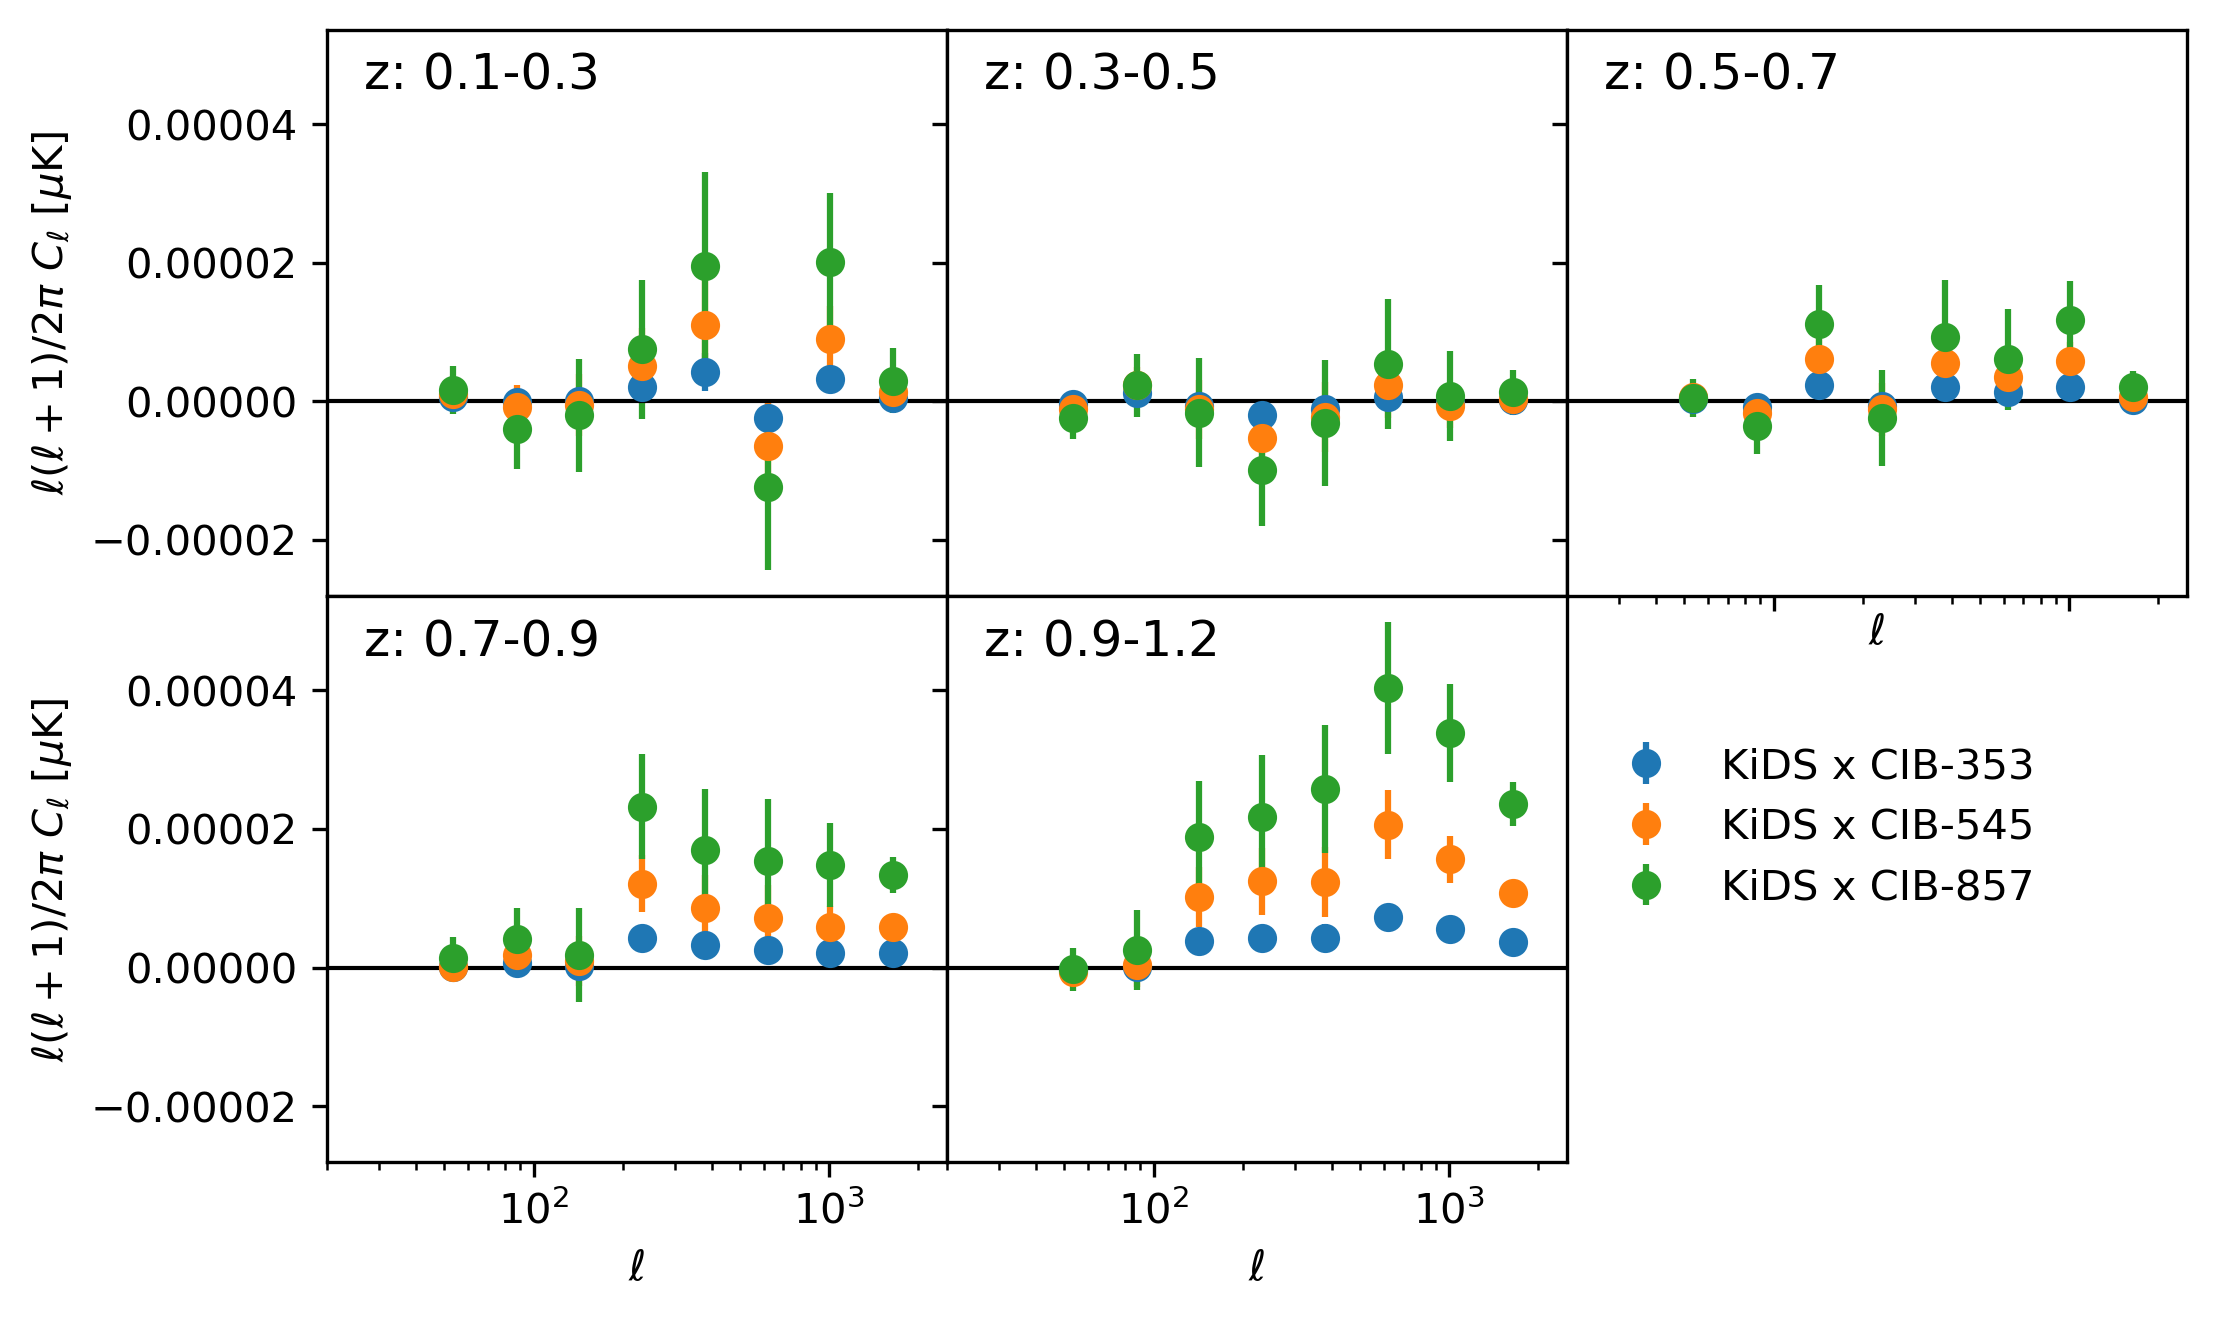

In [24]:
y_map = "milca"

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i, z_cut in enumerate(z_cuts):
    for CIB_map in CIB_maps:
        ell, Cl = Cl_CIB_shear[z_cut][CIB_map]["ell_binned"], Cl_CIB_shear[z_cut][CIB_map]["Cl_TE_beam10_binned"]
        cov = cov_CIB_shear[CIB_map][128]["TE"]
        offset = 0#B.shape[0]*len(z_cuts)
        error = np.sqrt(np.diag(cov)[offset+B.shape[0]*i:offset+B.shape[0]*(i+1)])
        u = ell**2/(2*pi)

        ax.flatten()[i].errorbar(ell, u*Cl, u*error, ls="none", marker="o", label=f"KiDS x CIB-{CIB_map}")

    ax.flatten()[i].axhline(0, c="k", lw=1)
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$ [$\mu$K]") for p in ax]

ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax.flatten()[-1].axis("off")
ax[0,0].set_xscale("log")
# ax[0,0].set_yscale("log")

ax[0,0].set_xlim(20, 2500)
# ax[0,0].set_ylim(1e-11, 1e-8)

fig.dpi = 300
fig.savefig("plots/KiDS1000xCIB.png")

# Plot covariance
## y-shear

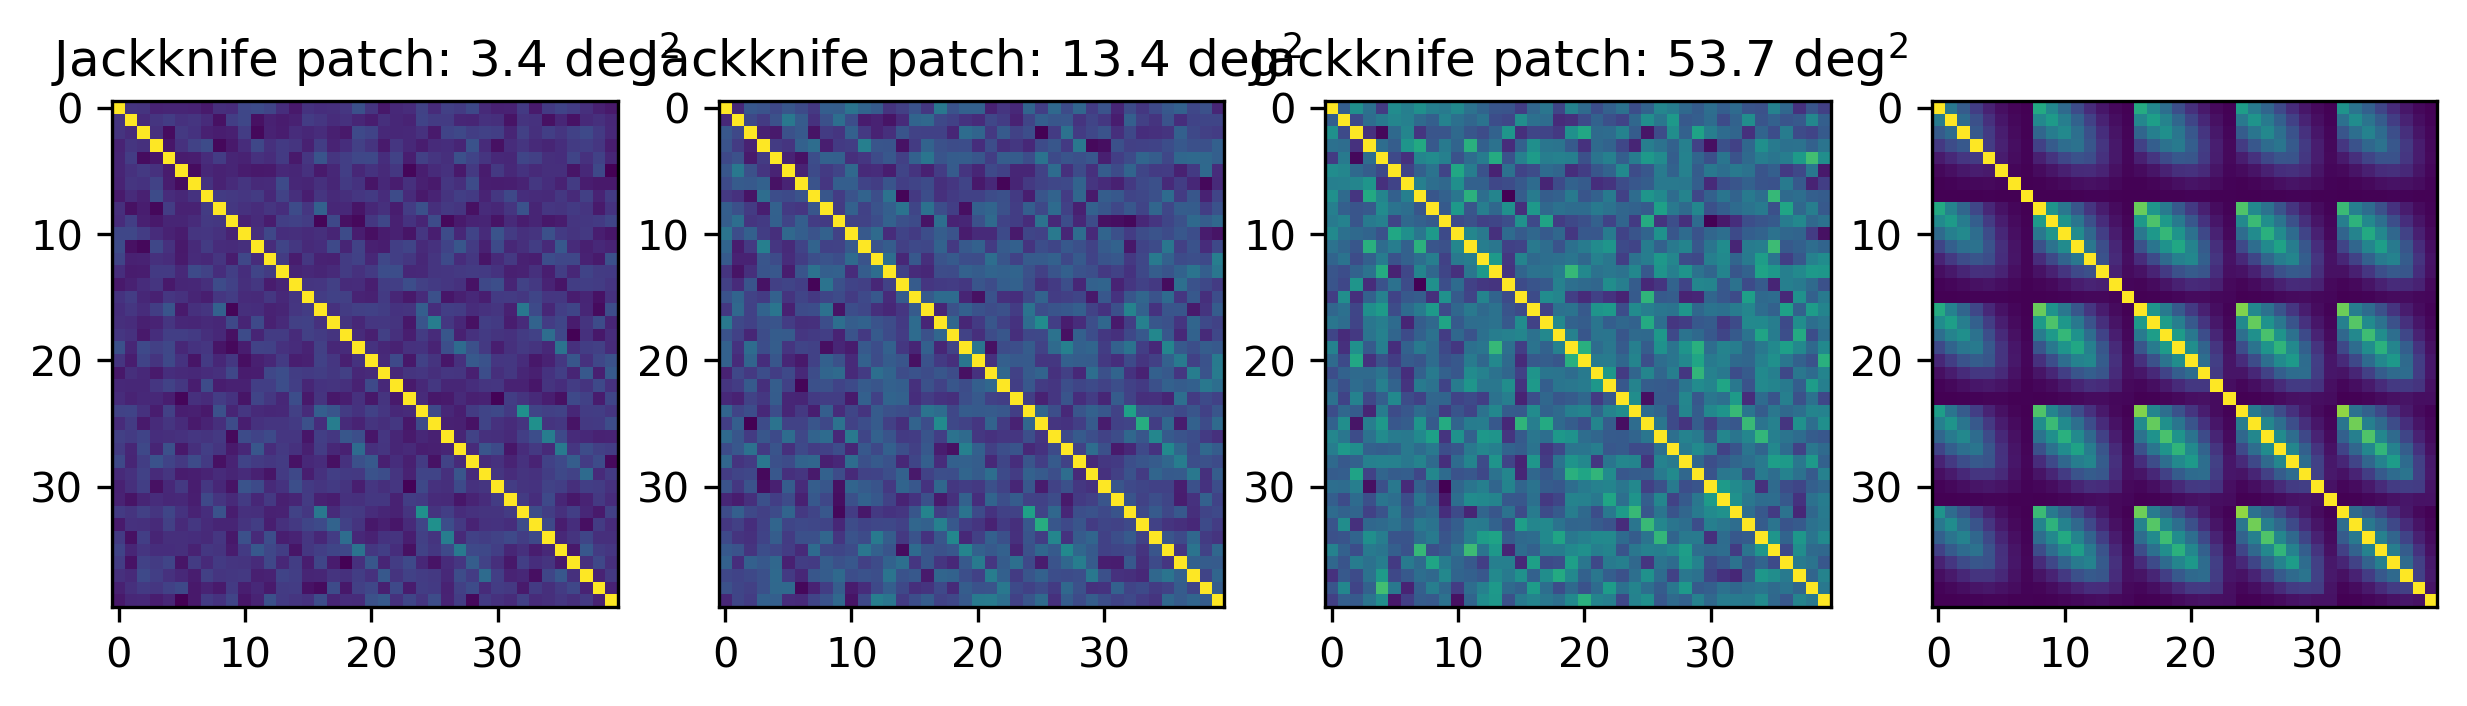

In [25]:
y_map = "milca"

fig, ax = plt.subplots(1, len(jk_resolutions)+1, figsize=(10, 3))

for i, jk_res in enumerate(jk_resolutions):
    cov = cov_y_shear[y_map][jk_res]["TE"]
    s = np.diag(1/np.sqrt(np.diag(cov)))
    ax[i].imshow(s @ cov @ s)
    
    jk_area = cov_y_shear[y_map][jk_res]["area"]
    ax[i].set_title(f"Jackknife patch: {jk_area:.1f} deg$^2$")

cov = covariance.gaussian + covariance.cNG
#cov = np.loadtxt(os.path.join(PROJECT_TRIAD_PATH, "config/HMx_paper/forecasts/output_fisher_shear_y_KiDS1000/cov_gauss_shear_y.txt"))

s = np.diag(1/np.sqrt(np.diag(cov)))
ax[-1].imshow(s @ cov @ s)
    
fig.dpi = 300
fig.savefig("plots/jk_covariances.png")

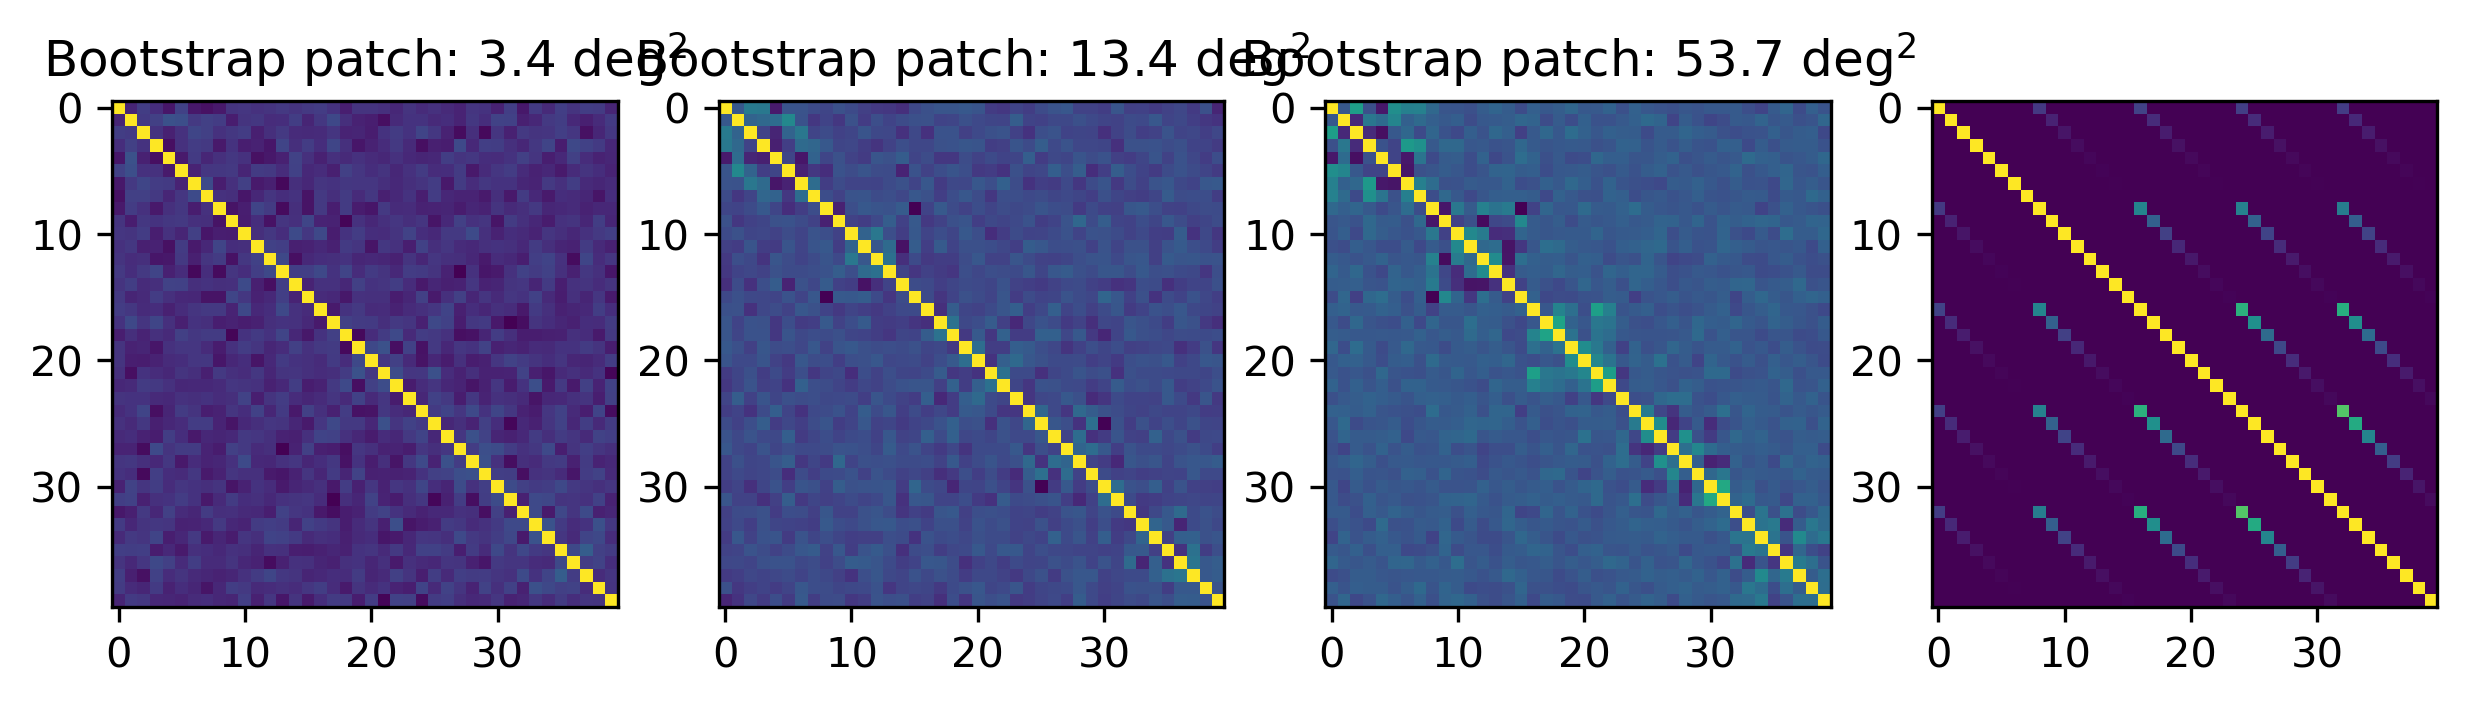

In [84]:
y_map = "milca"

fig, ax = plt.subplots(1, len(jk_resolutions)+1, figsize=(10, 3))

for i, jk_res in enumerate(jk_resolutions):
    cov = cov_y_shear_bs_shear[y_map][jk_res]["TE"]
    s = np.diag(1/np.sqrt(np.diag(cov)))
    ax[i].imshow(s @ cov @ s)
    
    jk_area = cov_y_shear[y_map][jk_res]["area"]
    ax[i].set_title(f"Bootstrap patch: {jk_area:.1f} deg$^2$")

cov = covariance.gaussian
#cov = np.loadtxt(os.path.join(PROJECT_TRIAD_PATH, "config/HMx_paper/forecasts/output_fisher_shear_y_KiDS1000/cov_gauss_shear_y.txt"))

s = np.diag(1/np.sqrt(np.diag(cov)))
ax[-1].imshow(s @ cov @ s)
    
fig.dpi = 300
fig.savefig("plots/bs_covariances.png")

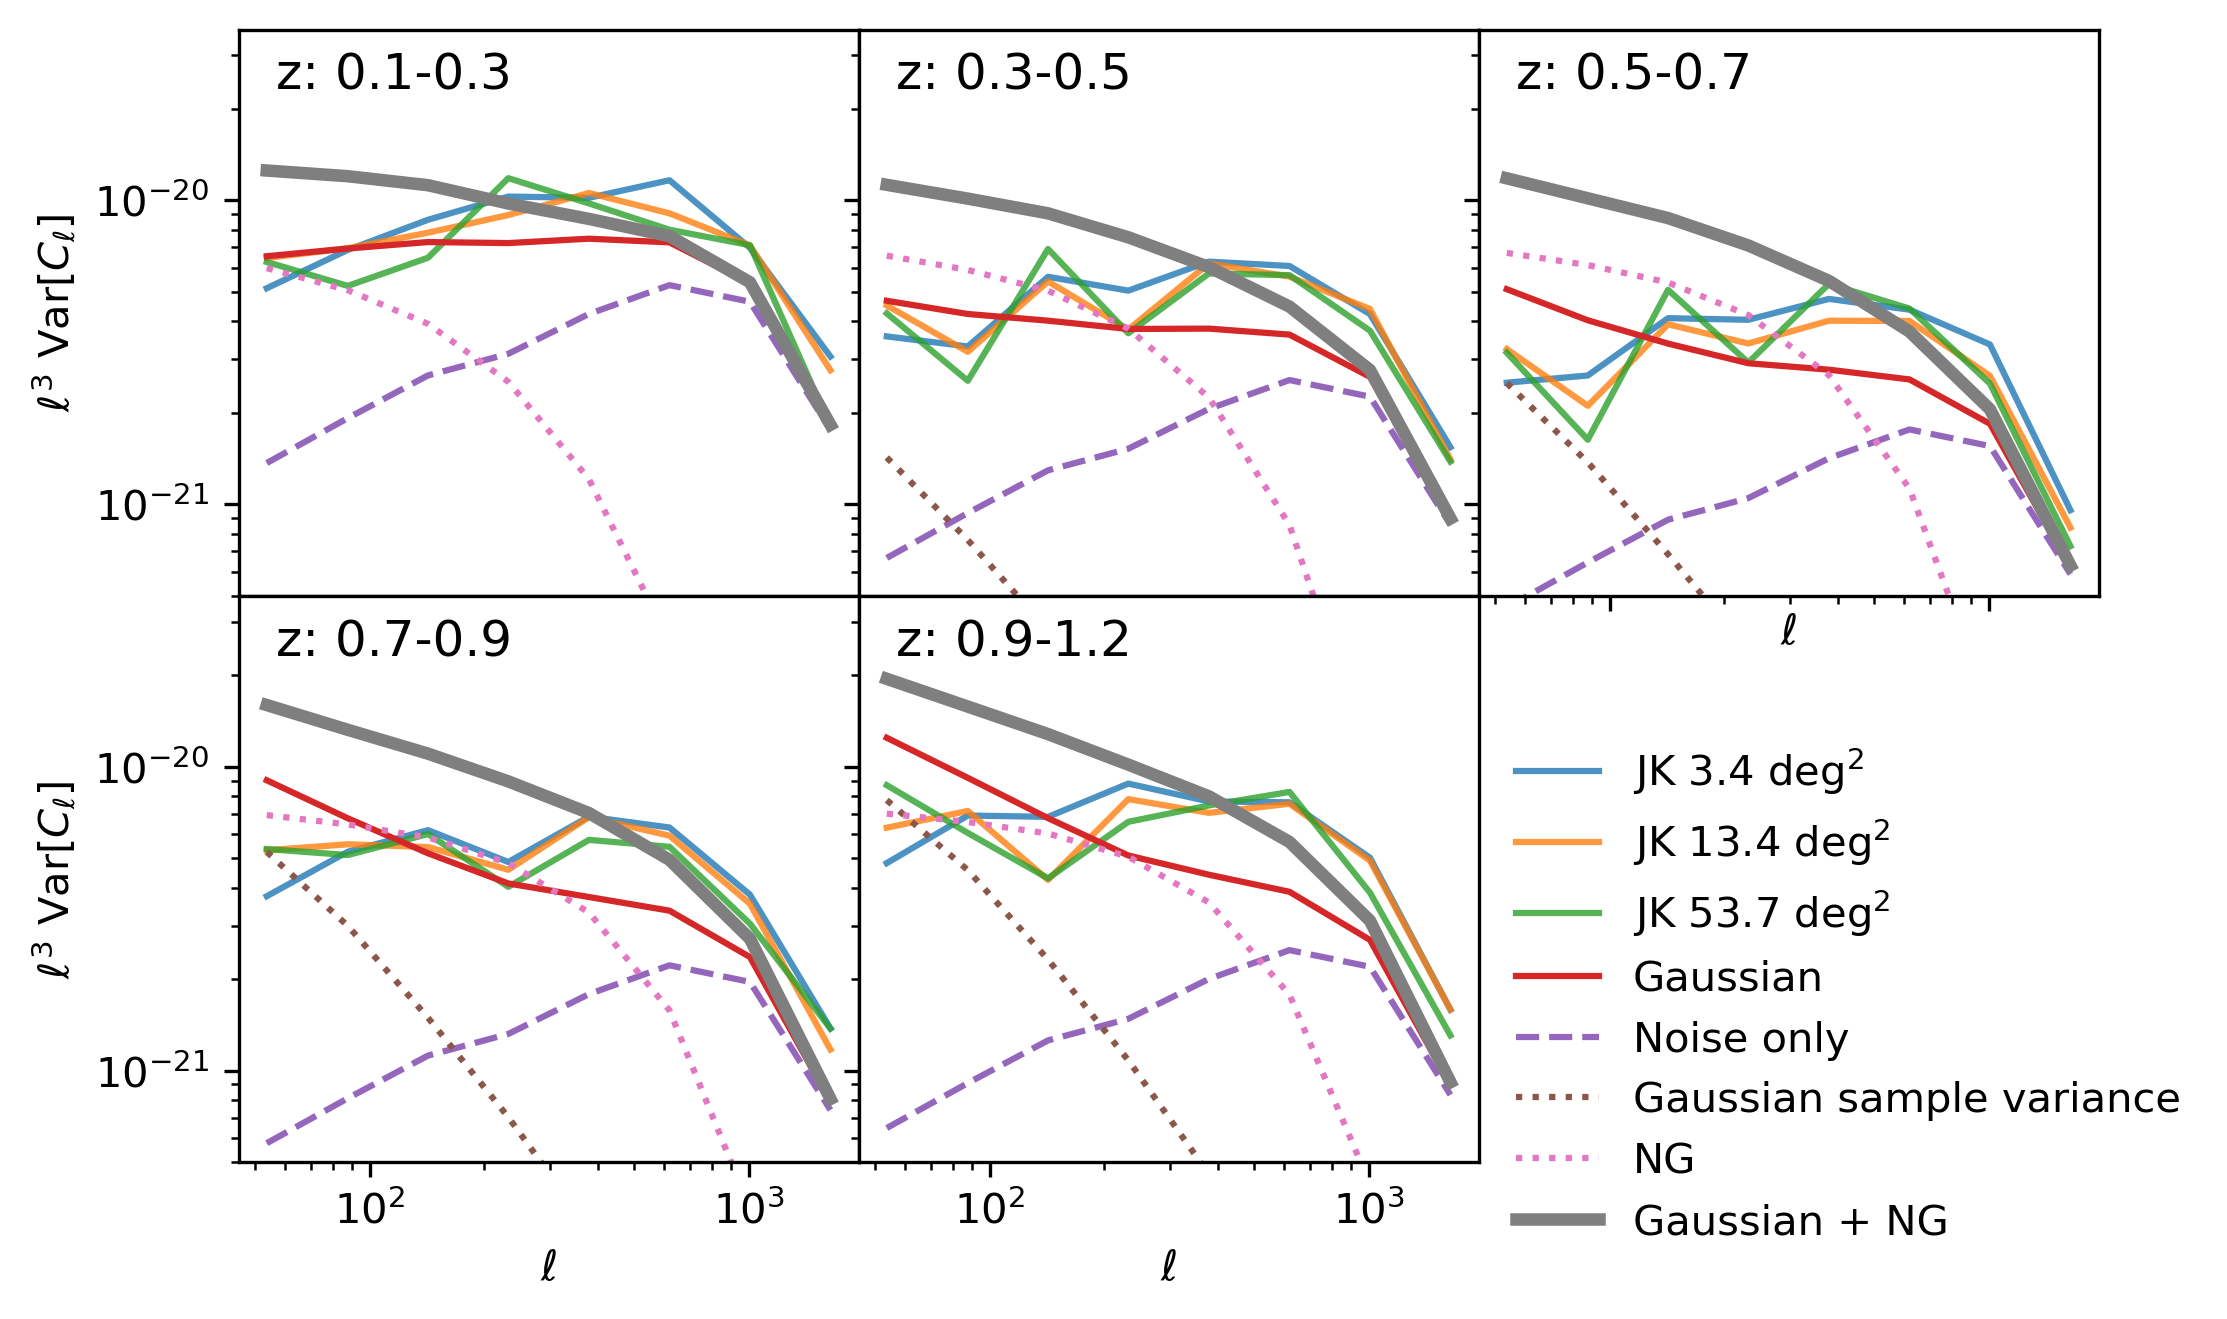

In [26]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)


for i, z_cut in enumerate(z_cuts):
    ell, Cl = Cl_y_shear[z_cut][y_map]["ell_binned"], Cl_y_shear[z_cut][y_map]["Cl_TE_binned"]
    u = ell**3
    
    for j, jk_res in enumerate(jk_resolutions):
        cov = cov_y_shear[y_map][jk_res]["TE"]
        jk_area = cov_y_shear[y_map][jk_res]["area"]
        var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]

        ax.flatten()[i].loglog(ell, u*var, ls="-", alpha=0.8, label=f"JK {jk_area:.1f} deg$^2$")
        
#     for j, jk_res in enumerate(jk_resolutions):
#         cov = cov_y_shear_baj[y_map][jk_res]["TE"]
#         jk_area = cov_y_shear[y_map][jk_res]["area"]
#         var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]

#         ax.flatten()[i].loglog(ell, u*var, ls=":", label=f"BAJ {jk_area:.1f} deg$^2$")
        
#     for j, jk_res in enumerate(jk_resolutions):
#         cov = cov_y_shear_wbs[y_map][jk_res]["TE"]
#         jk_area = cov_y_shear[y_map][jk_res]["area"]
#         var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]

#         ax.flatten()[i].loglog(ell, u*var, ls="-.", label=f"WBS {jk_area:.1f} deg$^2$")
        
#     for j, jk_res in enumerate(jk_resolutions):
#         cov = cov_y_shear_bs_shear[y_map][jk_res]["TE"]
#         jk_area = cov_y_shear[y_map][jk_res]["area"]
#         var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]

#         ax.flatten()[i].loglog(ell, u*var, ls="-.", label=f"BS {jk_area:.1f} deg$^2$")

#     for j, jk_res in enumerate(jk_resolutions):
#         cov = cov_y_shear_bs_shear[y_map][jk_res]["TB"]
#         jk_area = cov_y_shear[y_map][jk_res]["area"]
#         var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]

#         ax.flatten()[i].loglog(ell, u*var, ls=":", label=f"BS TB {jk_area:.1f} deg$^2$")


#     cov = np.loadtxt(os.path.join(PROJECT_TRIAD_PATH, "config/HMx_paper/forecasts/output_fisher_shear_y_KiDS1000/cov_gauss_shear_y.txt"))
#     var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]
#     ax.flatten()[i].loglog(ell, u*var, ls="-", label=f"Old")
    
    #cov = cov_analytic
    cov = covariance.gaussian
    var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]
    ax.flatten()[i].loglog(ell, u*var, ls="-", label=f"Gaussian")
    
    #cov = cov_noise_only_analytic
    cov = covariance.gaussian_noise_only
    var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]
    ax.flatten()[i].loglog(ell, u*var, ls="--", label=f"Noise only")
    
    #cov = cov_no_noise_analytic
    cov = covariance.gaussian_no_noise
    var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]
    ax.flatten()[i].loglog(ell, u*var, ls=":", label=f"Gaussian sample variance")
    
    cov = covariance.cNG
    var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]
    ax.flatten()[i].loglog(ell, u*var, ls=":", label=f"NG")
    
    cov = (covariance.cNG + covariance.gaussian)
    var = np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)]
    ax.flatten()[i].loglog(ell, u*var, ls="-", lw=3, label=f"Gaussian + NG")
    
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell^3\ {\rm Var}[C_\ell]$") for p in ax]
ax.flatten()[-1].axis("off")
ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax[0,0].set_ylim(bottom=5e-22)

fig.dpi = 300
fig.savefig("plots/jk_variances.png")

In [27]:
# for y_map in y_maps:
#     for name, cov in [("jk_3.4deg2", cov_y_shear[y_map][64]["TE"]),
#                       ("jk_13.4deg2", cov_y_shear[y_map][128]["TE"]),
#                       ("jk_53.7deg2", cov_y_shear[y_map][256]["TE"]),
#                       ("gaussian", cov_analytic),]:
#         np.savetxt(f"../data/xcorr/shear_y_KiDS1000_{y_map}_TE_{name}_cov.txt", 
#                cov)

# y_map = "milca"
# for CIB_map in CIB_maps:
#     for name, cov in [("jk_3.4deg2", cov_y_CIB_shear[CIB_map][64]["TE"]),
#                       ("jk_13.4deg2", cov_y_CIB_shear[CIB_map][128]["TE"]),
#                       ("jk_53.7deg2", cov_y_CIB_shear[CIB_map][256]["TE"]),]:
#         np.savetxt(f"../data/xcorr/shear_y_CIB_KiDS1000_{y_map}_{CIB_map}_TE_{name}_cov.txt", 
#                    cov)

# for CIB_map in CIB_maps:
#     for name, cov in [("jk_3.4deg2", cov_CIB_shear[CIB_map][64]["TE"]),
#                       ("jk_13.4deg2", cov_CIB_shear[CIB_map][128]["TE"]),
#                       ("jk_53.7deg2", cov_CIB_shear[CIB_map][256]["TE"]),]:
#         np.savetxt(f"../data/xcorr/shear_CIB_KiDS1000_{CIB_map}_TE_{name}_beam10_cov.txt", 
#                    cov)

y_maps = ["milca"]
for y_map in y_maps:
    for name, cov in [("gaussian", covariance.gaussian),
                      ("gaussian_cNG", covariance.gaussian+covariance.cNG)]:
        np.savetxt(f"../data/xcorr/shear_y_KiDS1000_{y_map}_TE_{name}_cov.txt", 
               cov)

## tSZ noise

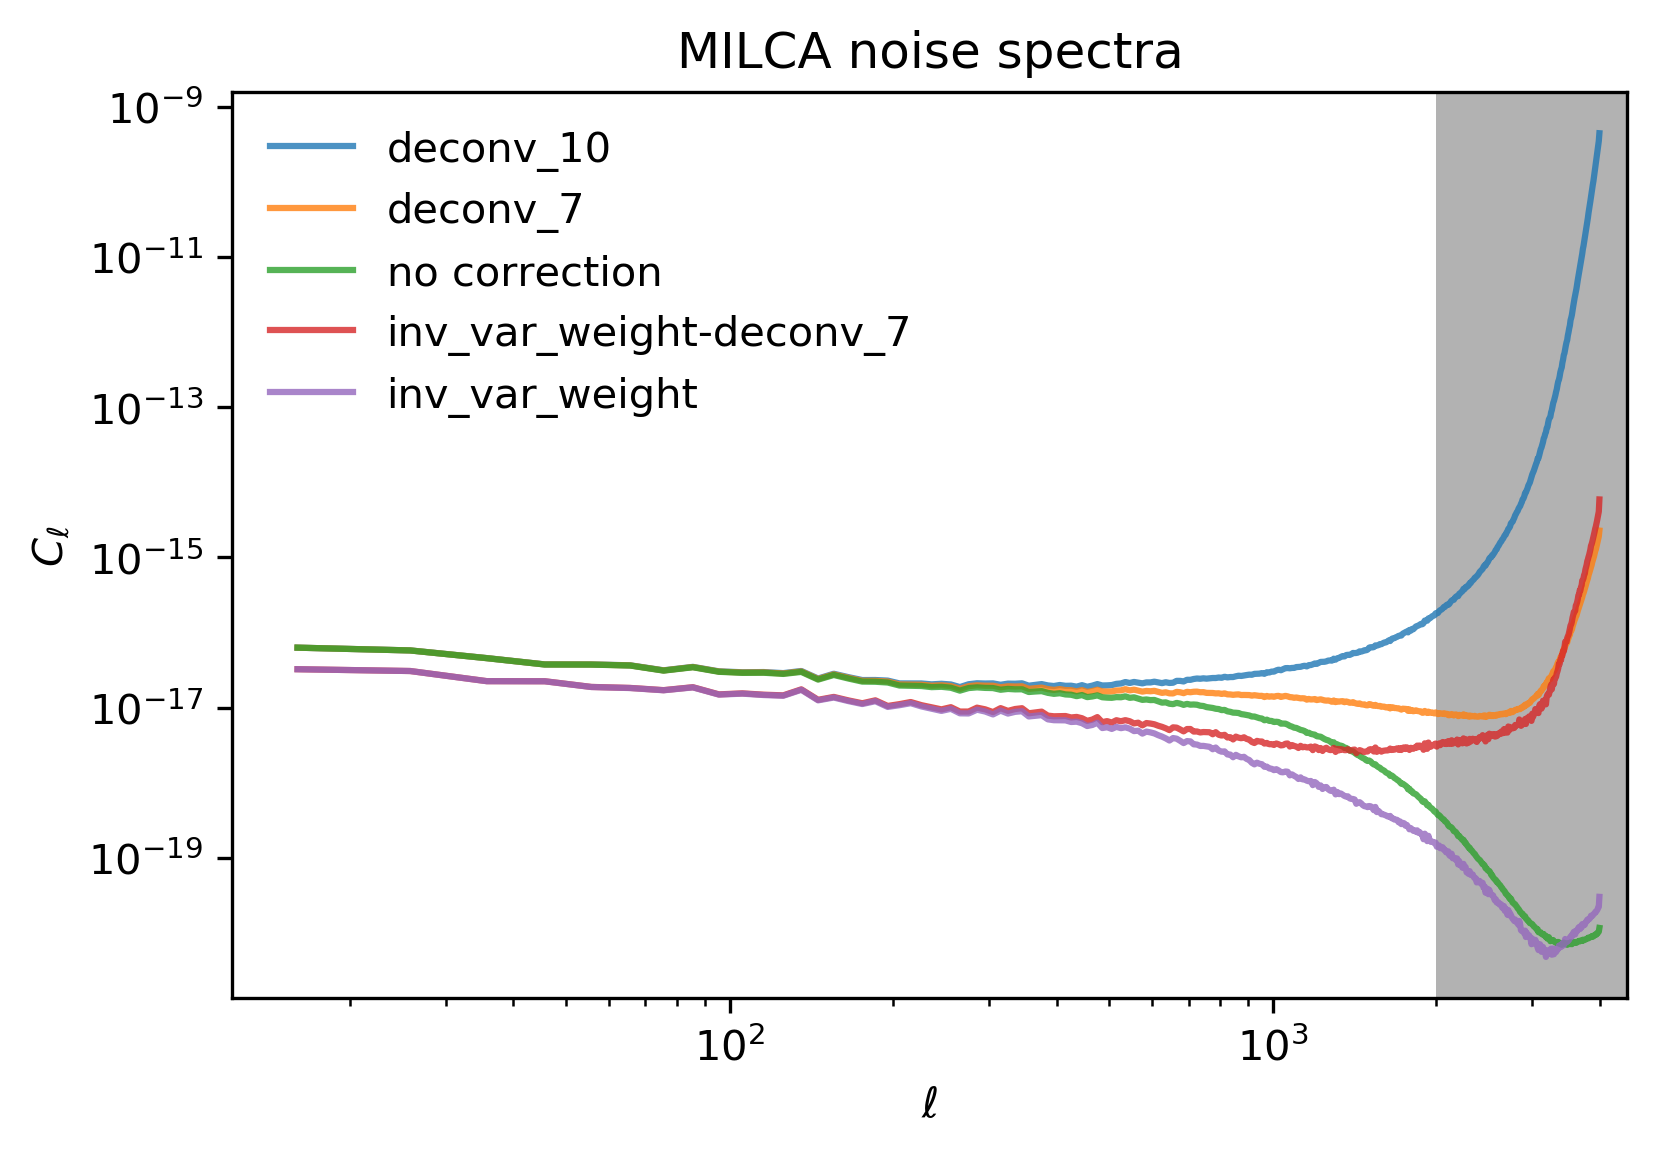

In [28]:
fig, ax = plt.subplots(1, 1)

ell = np.arange(4001)
B_lin_delta_ell_10 = make_binning_operator(x=ell, x_min=11, x_max=4001, n_bin=399, weights=(2*ell+1), binning="linear")

for filename in sorted(glob.glob(os.path.join(MEASUREMENT_DIR, "y_y/milca-half-difference*-ellmax_4000/spice.cl"))):
    label = os.path.split(os.path.split(filename)[0])[1]
    if "shear-footprint" in label:
        continue
        
    ls = "-"
    if "nilc" in label:
        ls = "--"
        
    label = label[len("milca-half-difference-"):-len("-ellmax_4000")]
    label = "no correction" if label == "" else label
    
    ell, Cl = np.loadtxt(filename, unpack=True)
    
    ax.loglog(B_lin_delta_ell_10@ell, B_lin_delta_ell_10@Cl, alpha=0.8, ls=ls, label=label)
    #ax.loglog(ell, Cl, alpha=0.8, ls=ls, label=label)

ax.set_xlim(right=4500)
ax.axvspan(xmin=2000, xmax=4500, facecolor="k", alpha=0.3)

ax.legend(frameon=False)

ax.set_ylabel("$C_\ell$")
ax.set_xlabel("$\ell$")

ax.set_title("MILCA noise spectra")

fig.dpi = 300
fig.savefig("plots/milca_noise_spectra.png")

## tSZ auto power

In [32]:
for tag, config_update, params_update in [("cov_beam7", {"projection" : {"y-y" : "y-y"},
                                                         "beam_filter_cls": {"fwhm": 7.071}}, {}),
                                         ]:
    config.reset_config()
    config.update_config(config_update)
    blocks[tag] = config.run_pipeline(defaults={**PATHS, **DATA_DIRS})

n(z) set to histogram mode. Bin centers are 0.025000 higher than edges.
Found 5 samples and 120 bins in redshift in file /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO1_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO2_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO3_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO4_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz//SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid

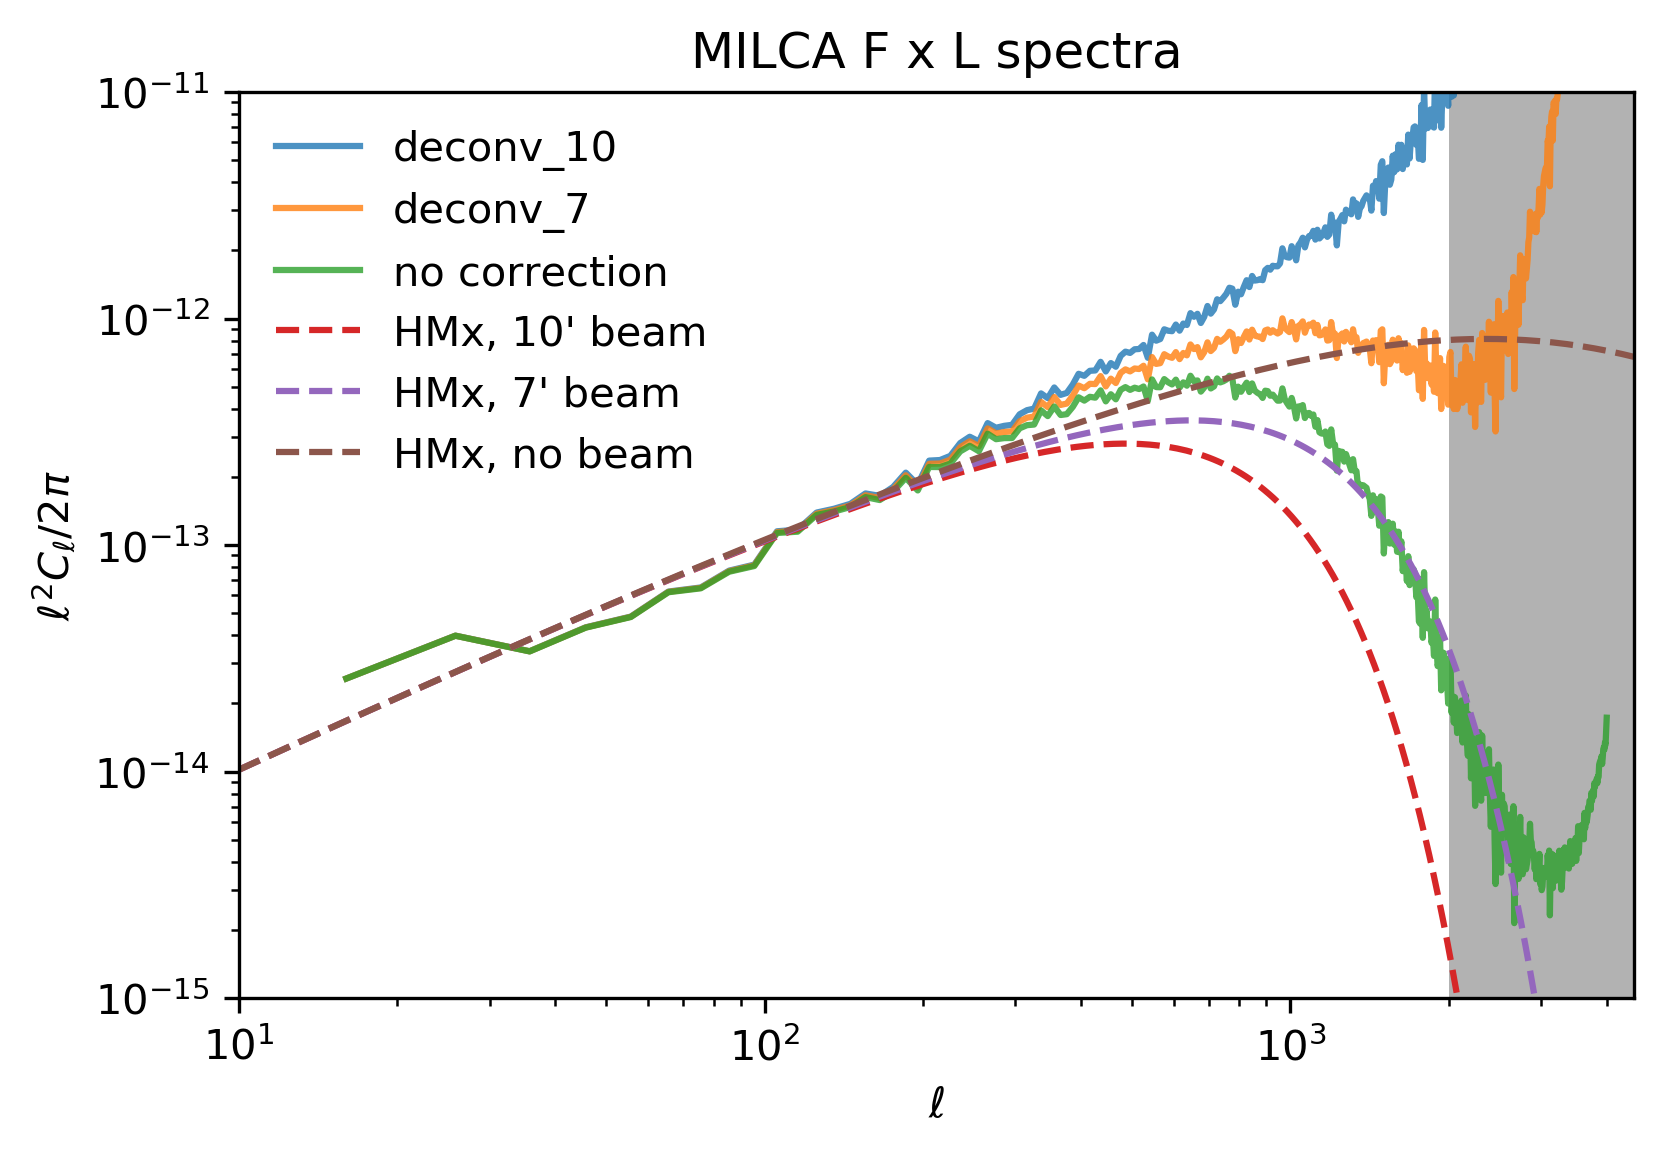

In [33]:
fig, ax = plt.subplots(1, 1)

ell = np.arange(4001)
B_lin_delta_ell_10 = make_binning_operator(x=ell, x_min=11, x_max=4001, n_bin=399, weights=(2*ell+1), binning="linear")

for filename in sorted(glob.glob(os.path.join(MEASUREMENT_DIR, "y_y/milca-fxl*-ellmax_4000/spice.cl"))):
    label = os.path.split(os.path.split(filename)[0])[1]
        
    ls = "-"
        
    label = label[len("milca-fxl-"):-len("-ellmax_4000")]
    label = "no correction" if label == "" else label
    
    ell, Cl = np.loadtxt(filename, unpack=True)
    
    u = (B_lin_delta_ell_10@ell)**2/(2*pi)
    
    ax.loglog(B_lin_delta_ell_10@ell, u*(B_lin_delta_ell_10@Cl), alpha=0.8, ls=ls, label=label)
    #ax.loglog(ell, Cl, alpha=0.8, ls=ls, label=label)

ell = blocks["cov"]["y_y_cl_beam_pixwin", "ell"]
u = ell**2/(2*pi)
ax.loglog(ell, u*blocks["cov"]["y_y_cl_beam_pixwin", "bin_1_1"],
          ls="--", label="HMx, 10' beam")
ax.loglog(ell, u*blocks["cov_beam7"]["y_y_cl_beam_pixwin", "bin_1_1"],
          ls="--", label="HMx, 7' beam")
ax.loglog(ell, u*blocks["cov"]["y_y_cl", "bin_1_1"],
          ls="--", label="HMx, no beam")

ax.set_xlim(left=10, right=4500)
ax.axvspan(xmin=2000, xmax=4500, facecolor="k", alpha=0.3)

ax.set_ylim(bottom=1e-15, top=1e-11)

ax.legend(frameon=False)

ax.set_ylabel("$\ell^2 C_\ell/2\pi$")
ax.set_xlabel("$\ell$")

ax.set_title("MILCA F x L spectra")

fig.dpi = 300
fig.savefig("plots/milca_fxl_spectra.png")

      fun: 4509.937620292458
 hess_inv: array([[ 8.70645858e-06, -1.02349552e-04,  2.98437798e-04,
         3.80759355e-05],
       [-1.02349552e-04,  1.21160192e-03, -3.56170163e-03,
        -4.28604523e-04],
       [ 2.98437798e-04, -3.56170163e-03,  1.05703384e-02,
         1.18946320e-03],
       [ 3.80759355e-05, -4.28604523e-04,  1.18946320e-03,
         2.23309165e-04]])
      jac: array([ 0.328125  ,  0.04943848,  0.00744629, -0.00244141])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 243
      nit: 14
     njev: 48
   status: 2
  success: False
        x: array([  0.05200062,  -0.78861478, -35.68565752,  11.0520874 ])


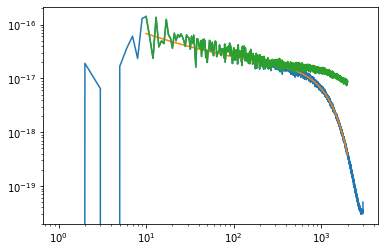

In [182]:
def log_noise_model(p, ell):
    c = p[:-1]
    fwhm  = p[-1]
    sigma = fwhm/60.0/180.0*pi/(2.0*np.sqrt(2.0* np.log(2.0)))
    
    return np.poly1d(c)(np.log(ell)) + 1*(-0.5* ell**2 * sigma**2)

def loss_log_model(p, fit_range):
    s = slice(*fit_range)
    ell = ell_noise[s]
    mu = log_noise_model(p, ell)
    d = np.log(Cl_noise/4)[s]
    
    r = mu-d
    
    return np.sum((r)**2)

def loss_model(p, fit_range):
    s = slice(*fit_range)
    ell = ell_noise[s]
    mu = np.exp(log_noise_model(p, ell))
    d = (Cl_noise/4)[s]
    
    normalise = 1
    r = (mu-d) * normalise
    
    return np.sum(r**2 * 0.5*(2*ell+1)/(2*d**2))


fit_range = (10, 2000)
result = scipy.optimize.minimize(loss_model, x0=(0, -0.44, -36.0, 10.0), args=(fit_range,), tol=1e-12)
print(result)

y_noise_model = lambda ell, p=result.x: np.exp(log_noise_model(p, ell))
s = slice(*fit_range)
plt.loglog(ell_noise, Cl_noise/4)
# plt.loglog(ell_noise[s], np.exp(log_noise_model(result.x, ell_noise[s])))
# plt.loglog(ell_noise[s], np.exp(log_noise_model((*result.x[:-1], 10.0), ell_noise[s])))

plt.loglog(ell_noise[s], np.exp(log_noise_model(result.x, ell_noise[s])))
#plt.loglog(ell_noise[s], np.exp(log_noise_model((*result.x[:-1], 10.0), ell_noise[s])))
# plt.loglog(ell_noise[s], np.exp(log_noise_model((-0.44, -36.0, 10.0), ell_noise[s])))

# loss_model((-0.3, -30, 10.0), fit_range)
plt.loglog(ell_noise[s], (Cl_noise/4/np.exp(-0.5*ell_noise**2*sigma_10**2))[s])


## y-CIB-shear

In [34]:
y_map = "milca"
CIB_map = "545"

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for i, jk_res in enumerate([64, 128, 256]):
    cov = cov_y_CIB_shear[CIB_map][jk_res]["TE"]
    s = np.diag(1/np.sqrt(np.diag(cov)))
    ax[i].imshow(s @ cov @ s)
    
    jk_area = cov_y_shear[y_map][jk_res]["area"]
    ax[i].set_title(f"Jackknife patch: {jk_area:.1f} deg$^2$")
    
fig.dpi = 300
fig.savefig("plots/jk_y_CIB_covariances.png")

NameError: name 'cov_y_CIB_shear' is not defined

# Plot jackknife patches

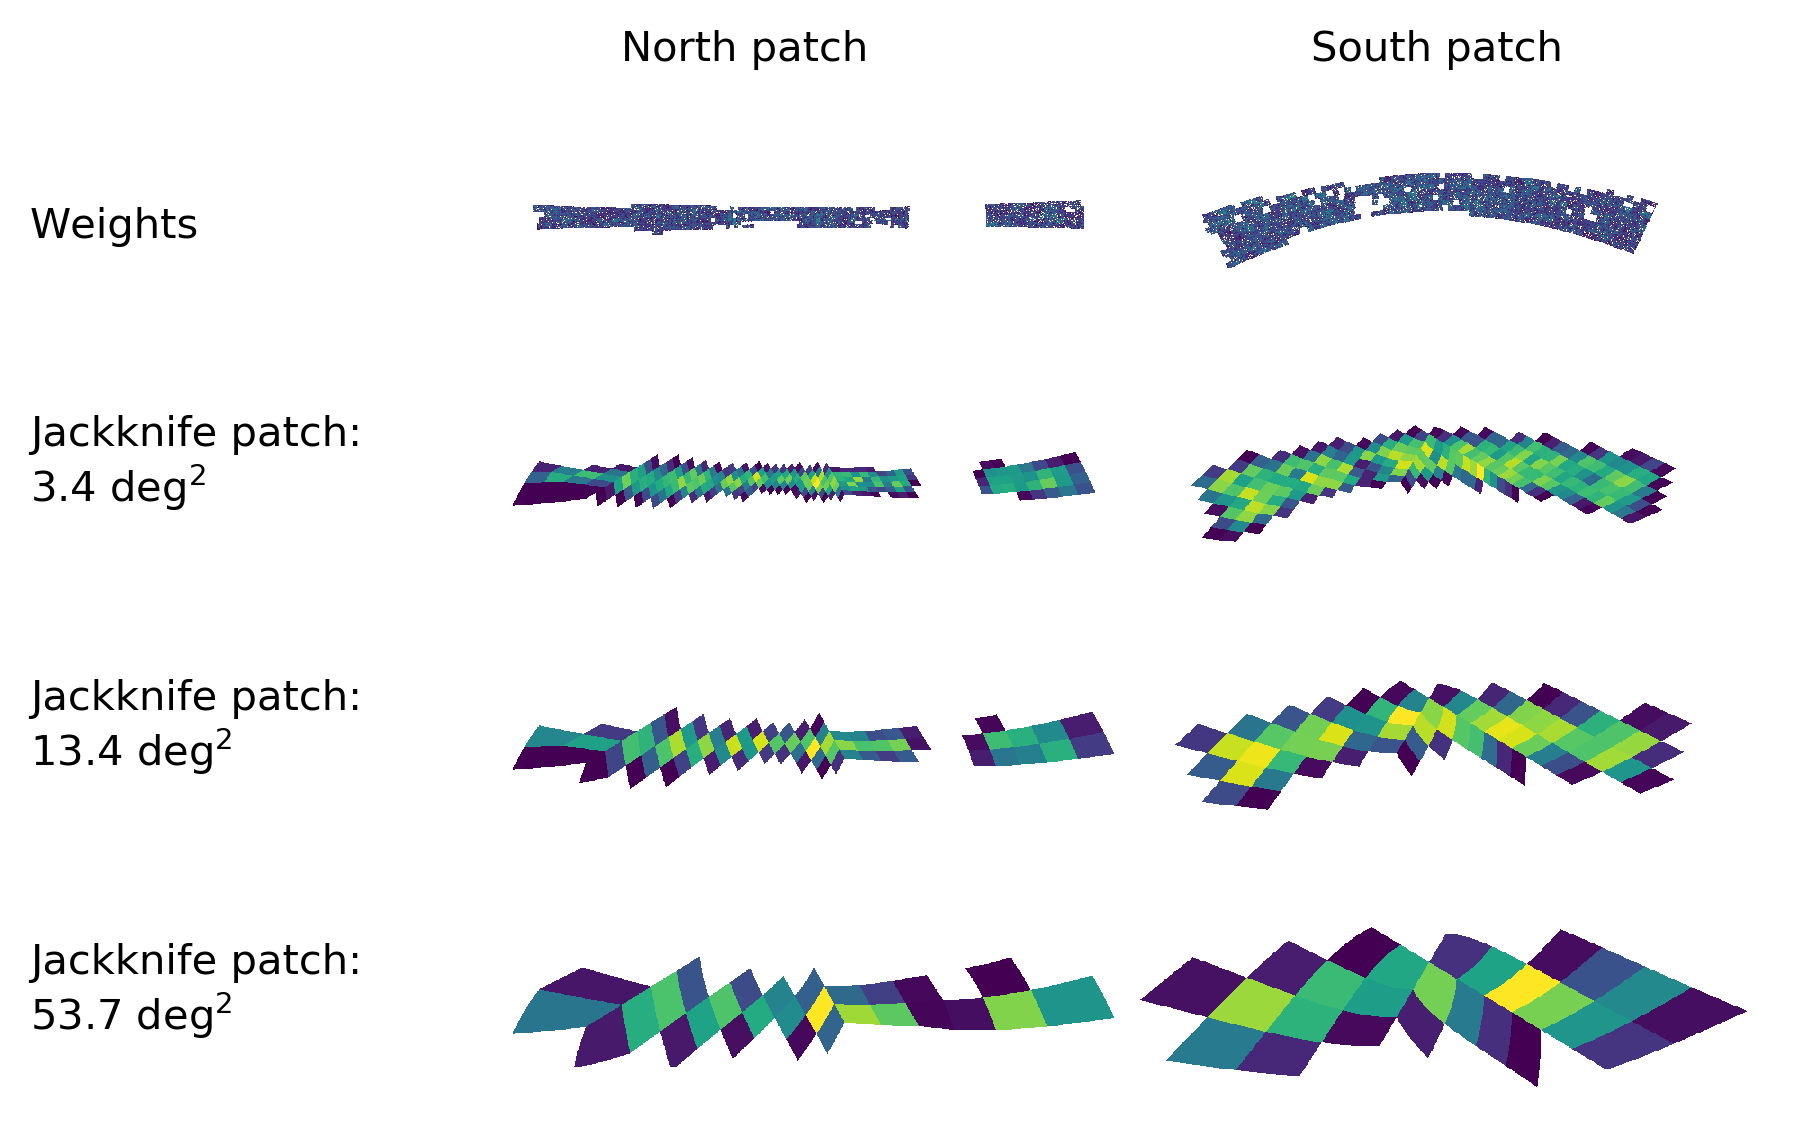

In [274]:
fig, ax = plt.subplots(4, 2)
fig.subplots_adjust(left=0.3, hspace=0, wspace=0, bottom=0, right=1)

plt.sca(ax[0,0])
healpy.gnomview(m, rot=[182,0,0], reso=10, coord="GC", xsize=1100, ysize=200, 
                fig=fig, hold=True, notext=True, cbar=False, title="", badcolor="white")

plt.sca(ax[0,1])
healpy.gnomview(m, rot=[9,-36,0], reso=10, coord="GC", xsize=700, ysize=200,
                fig=fig, hold=True, notext=True, cbar=False, title="", badcolor="white")

fig.axes[-2].text(y=-0.1, x=-4.0, s=f"Weights")

fig.axes[-2].text(y=0.8, x=-1.0, s=f"North patch")
fig.axes[-2].text(y=0.8, x=2.5, s=f"South patch")

for a, jk_res in enumerate(jk_resolutions):
    jk_weight_map = np.full_like(m, fill_value=healpy.UNSEEN, dtype=np.float32)

    for i, idx in enumerate(jk_def[str(jk_res)]):
        jk_weight_map[idx] = jk_weights[y_map][jk_res][i]

    plt.sca(ax[1+a,0])
    healpy.gnomview(jk_weight_map, rot=[182,0,0], reso=10, coord="GC", xsize=1100, ysize=200,
                    fig=fig, hold=True, notext=True, cbar=False, title="", badcolor="white")
    plt.sca(ax[1+a,1])
    healpy.gnomview(jk_weight_map, rot=[9,-36,0], reso=10, coord="GC", xsize=700, ysize=200,
                    fig=fig, hold=True, notext=True, cbar=False, title="", badcolor="white")
    
    jk_area = 4*pi/(12*(2048/jk_res)**2)*(180/pi)**2
    fig.axes[-2].text(y=-0.1, x=-4.0, s=f"Jackknife patch:\n{jk_area:.1f} deg$^2$")

fig.dpi = 300
fig.savefig("plots/jk_regions.png")

# Consistency checks
## Check number of required redshift points

In [23]:
y_y_kwargs = {"projection" : {"y-y" : "y-y"}}

for tag, config_update, params_update in [
#                                           ("zmid1.5_nz4+3", {"camb" : {"zmid" : 1.5,
#                                                                         "nz_mid" : 4, 
#                                                                         "nz" : 7},
#                                                              **y_y_kwargs}, {}),
                                          ("zmid1.5_nz8+3", {"camb" : {"zmid" : 1.5,
                                                                        "nz_mid" : 8, 
                                                                        "nz" : 11},
                                                             **y_y_kwargs}, {}),
                                          ("zmid1.5_nz8+5", {"camb" : {"zmid" : 1.5,
                                                                        "nz_mid" : 8, 
                                                                        "nz" : 13},
                                                             **y_y_kwargs}, {}),
                                          ("zmid1.5_nz10+4", {"camb" : {"zmid" : 1.5,
                                                                        "nz_mid" : 10, 
                                                                        "nz" : 14},
                                                             **y_y_kwargs}, {}),
#                                           ("zmid2.0_nz4+3", {"camb" : {"zmid" : 2.0,
#                                                                         "nz_mid" : 4, 
#                                                                         "nz" : 7},
#                                                              **y_y_kwargs}, {}),
#                                           ("zmid2.0_nz8+3", {"camb" : {"zmid" : 2.0,
#                                                                         "nz_mid" : 8, 
#                                                                         "nz" : 11},
#                                                              **y_y_kwargs}, {}),
#                                           ("zmid2.0_nz16+3", {"camb" : {"zmid" : 2.0,
#                                                                         "nz_mid" : 16, 
#                                                                         "nz" : 19},
#                                                              **y_y_kwargs}, {}),
                                          ("zmid3.0_nz32+8", {"camb" : {"zmid" : 3.0,
                                                                        "nz_mid" : 32, 
                                                                        "nz" : 40},
                                                              **y_y_kwargs}, {}),
#                                           ("zmid3.0_nz64+8", {"camb" : {"zmid" : 3.0,
#                                                                         "nz_mid" : 64, 
#                                                                         "nz" : 72},
#                                                               **y_y_kwargs}, {}),
                                         ]:
    blocks[tag] = run_pipeline(config, params, config_update, params_update)
    Cl_y_shear_theory[tag] = extract_Cl(blocks[tag], z_cuts)
    Cl_intrinsic_y_theory[tag] = extract_Cl(blocks[tag], z_cuts, section="intrinsic_y_cl")
    

n(z) set to histogram mode. Bin centers are 0.025000 higher than edges.
Found 5 samples and 120 bins in redshift in file /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO1_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO2_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO3_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO4_Nz.asc /Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blin

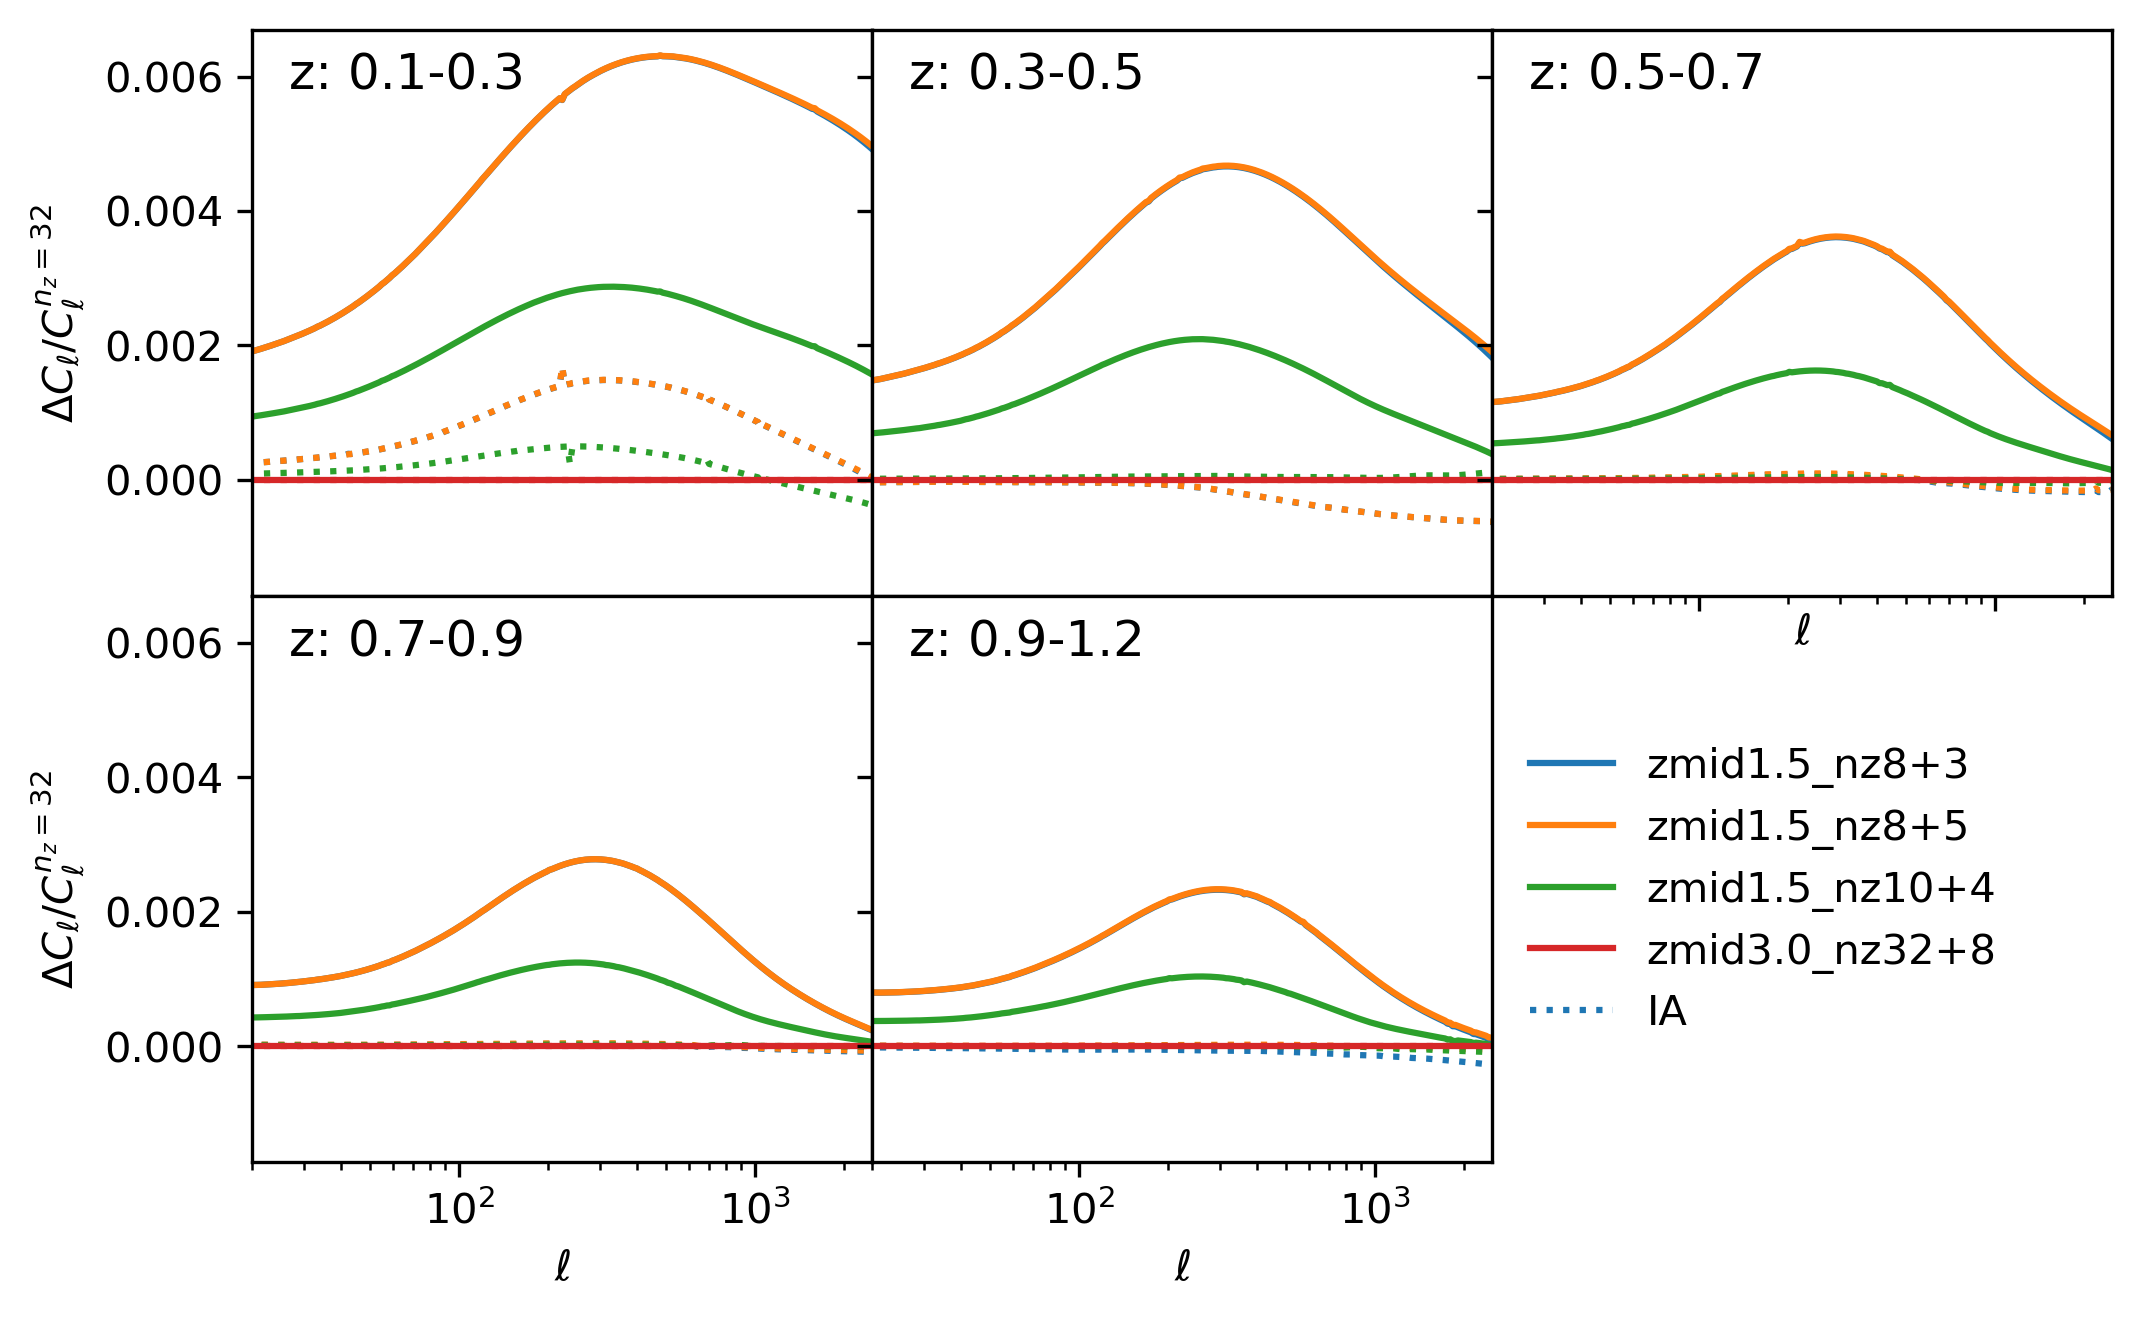

In [37]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

fiducial_tag = "zmid3.0_nz32+8"
for i, z_cut in enumerate(z_cuts):
    
    ell_theory = Cl_y_shear_theory[fiducial_tag][z_cut]["ell"][2:]
    Cl_theory_fid = Cl_y_shear_theory[fiducial_tag][z_cut]["Cl_smooth"][2:]
    Cl_ia_theory_fid = Cl_intrinsic_y_theory[fiducial_tag][z_cut]["Cl_smooth"][2:]
    u = ell_theory**2/(2*pi)

    for j, tag in enumerate([#"zmid1.5_nz4+3", 
                "zmid1.5_nz8+3", "zmid1.5_nz8+5", "zmid1.5_nz10+4",
                #"zmid2.0_nz4+3", "zmid2.0_nz8+3", "zmid2.0_nz16+3",
                "zmid3.0_nz32+8"]):
        Cl_theory = Cl_y_shear_theory[tag][z_cut]["Cl_smooth"][2:]
        Cl_ia_theory = Cl_intrinsic_y_theory[tag][z_cut]["Cl_smooth"][2:]
        
        ax.flatten()[i].plot(ell_theory, Cl_theory/Cl_theory_fid - 1,
                             c=f"C{j}", label=tag)
        ax.flatten()[i].plot(ell_theory, Cl_ia_theory/Cl_ia_theory_fid - 1,
                             ls=":", c=f"C{j}")

    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)
    
ax.flatten()[-2].plot([], [], ls=":", label="IA")

[p[0].set_ylabel(r"$\Delta C_\ell/C_\ell^{n_z=32}$") for p in ax]

ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax.flatten()[-1].axis("off")
ax[0,0].set_xscale("log")
ax[0,0].set_xlim(20, 2500)

fig.dpi = 300
fig.savefig("plots/convergence_nz_frac_difference_ia.png")

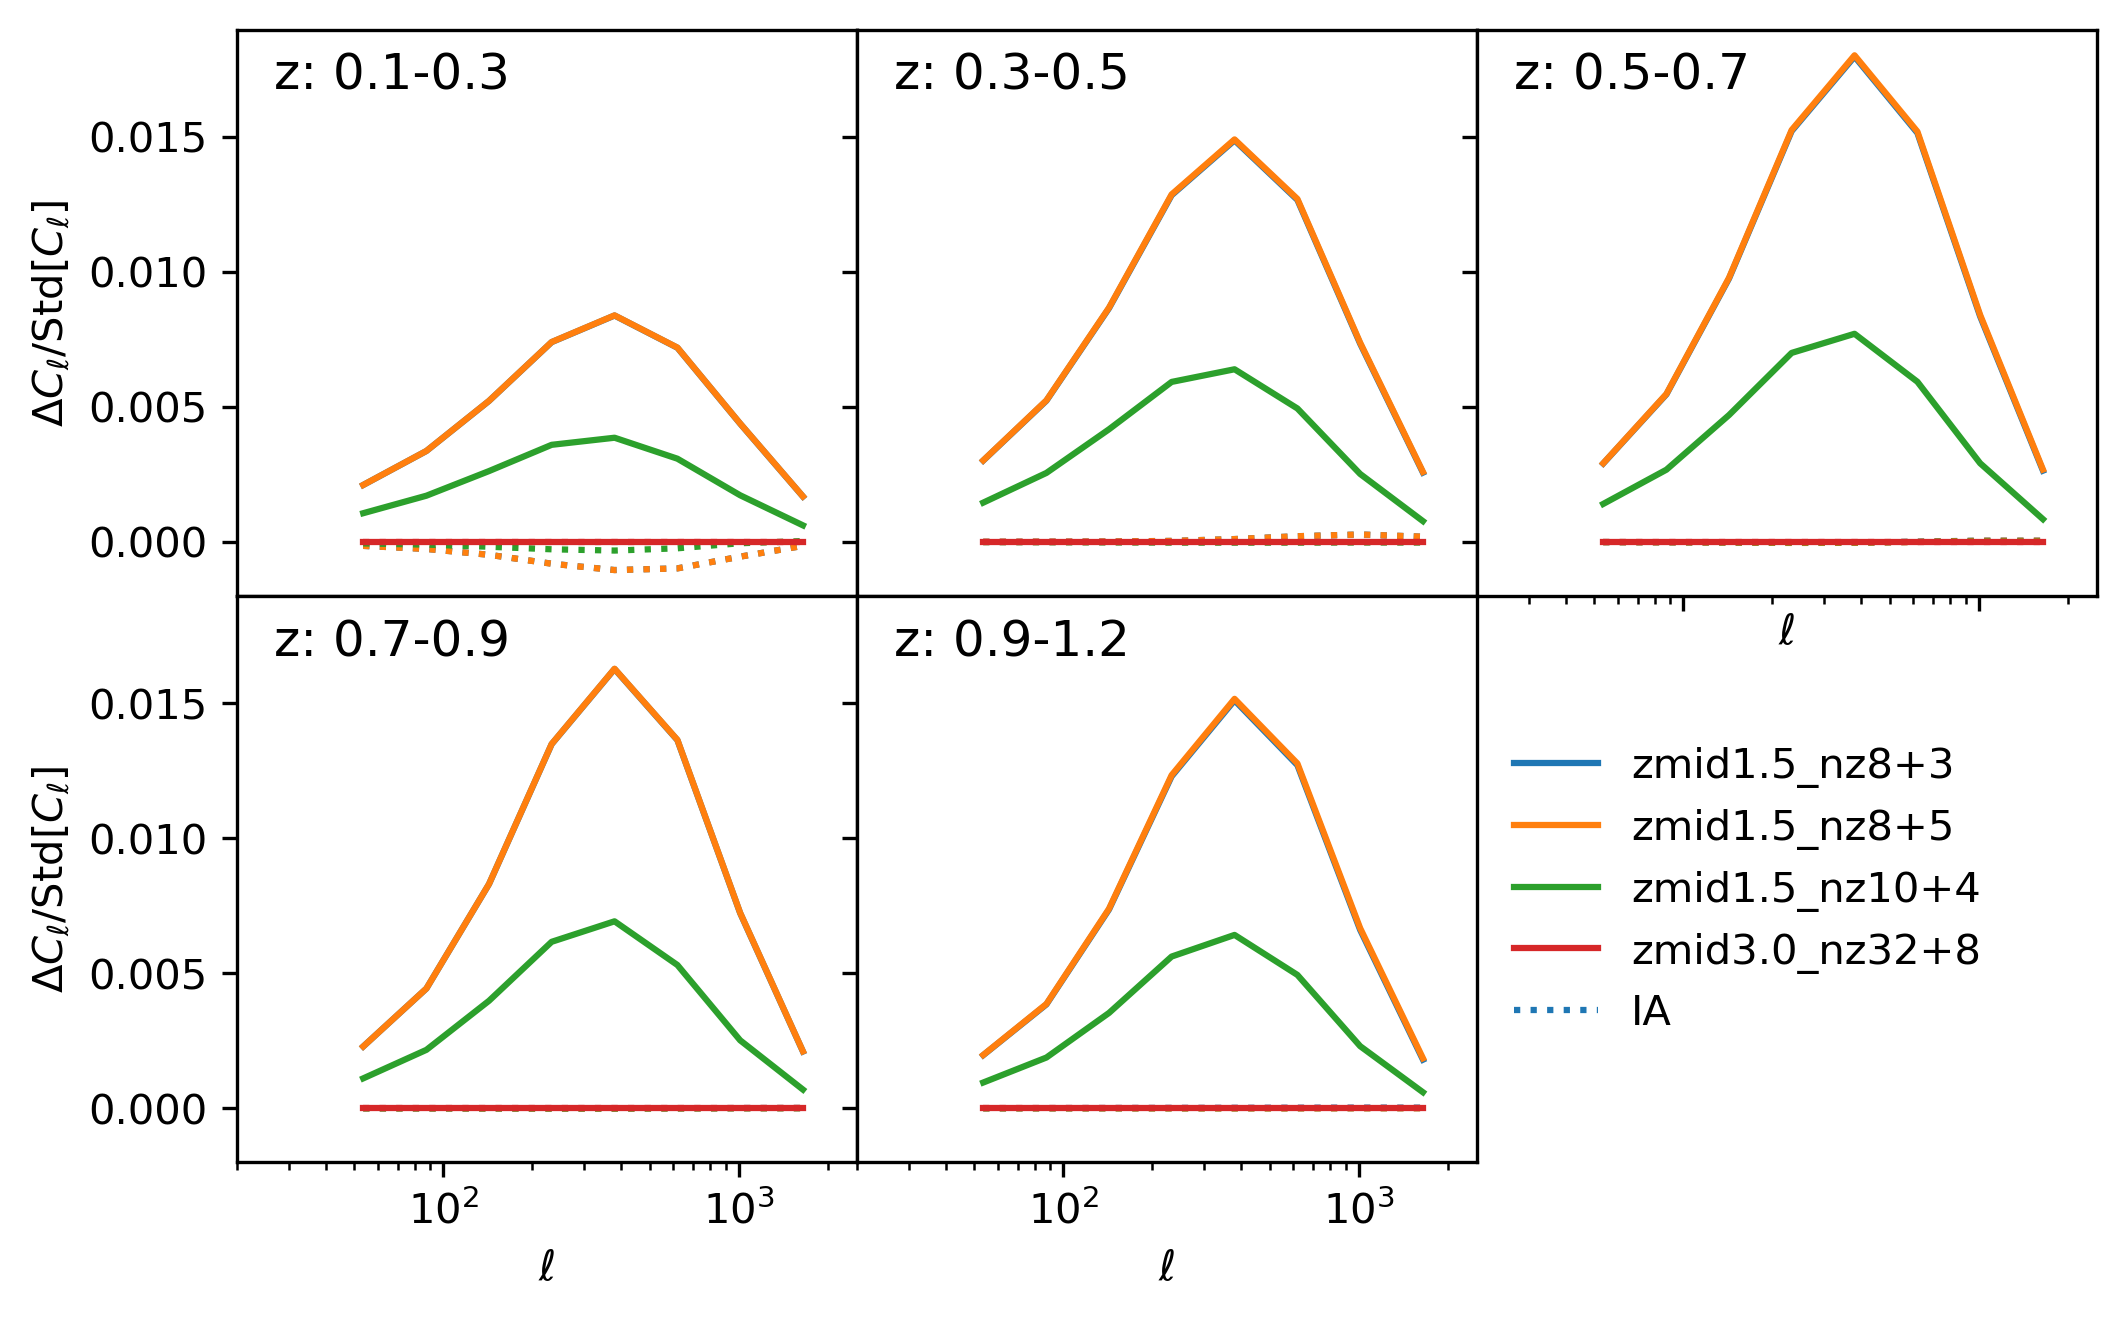

In [38]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

fiducial_tag = "zmid3.0_nz32+8"

for i, z_cut in enumerate(z_cuts):
    tag = "nz32"
    ell_theory = Cl_y_shear_theory[fiducial_tag][z_cut]["ell_binned"]
    Cl_theory_fid = Cl_y_shear_theory[fiducial_tag][z_cut]["Cl_binned"]
    Cl_ia_theory_fid = Cl_intrinsic_y_theory[fiducial_tag][z_cut]["Cl_binned"]
    u = ell_theory**2/(2*pi)
    
    cov = covariance.gaussian
    error = np.sqrt(np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)])
    
    for j, tag in enumerate([#"zmid1.5_nz4+3", 
                "zmid1.5_nz8+3", "zmid1.5_nz8+5", "zmid1.5_nz10+4",
                #"zmid2.0_nz4+3", "zmid2.0_nz8+3", "zmid2.0_nz16+3",
                "zmid3.0_nz32+8"]):
        Cl_theory = Cl_y_shear_theory[tag][z_cut]["Cl_binned"]
        Cl_ia_theory = Cl_intrinsic_y_theory[tag][z_cut]["Cl_binned"]
        
        ax.flatten()[i].plot(ell_theory, (Cl_theory - Cl_theory_fid)/error,
                             c=f"C{j}", label=tag)
        ax.flatten()[i].plot(ell_theory, (Cl_ia_theory - Cl_ia_theory_fid)/error, 
                             ls=":", c=f"C{j}")

    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)
    
ax.flatten()[-2].plot([], [], ls=":", label="IA")

[p[0].set_ylabel(r"$\Delta C_\ell/\mathrm{Std}[C_\ell]$") for p in ax]

ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax.flatten()[-1].axis("off")
ax[0,0].set_xscale("log")
ax[0,0].set_xlim(20, 2500)

fig.dpi = 300
fig.savefig("plots/convergence_nz_wrt_error_ia.png")

## Check CosmoSIS tSZ projection against CCL

In [14]:
import pyccl as ccl

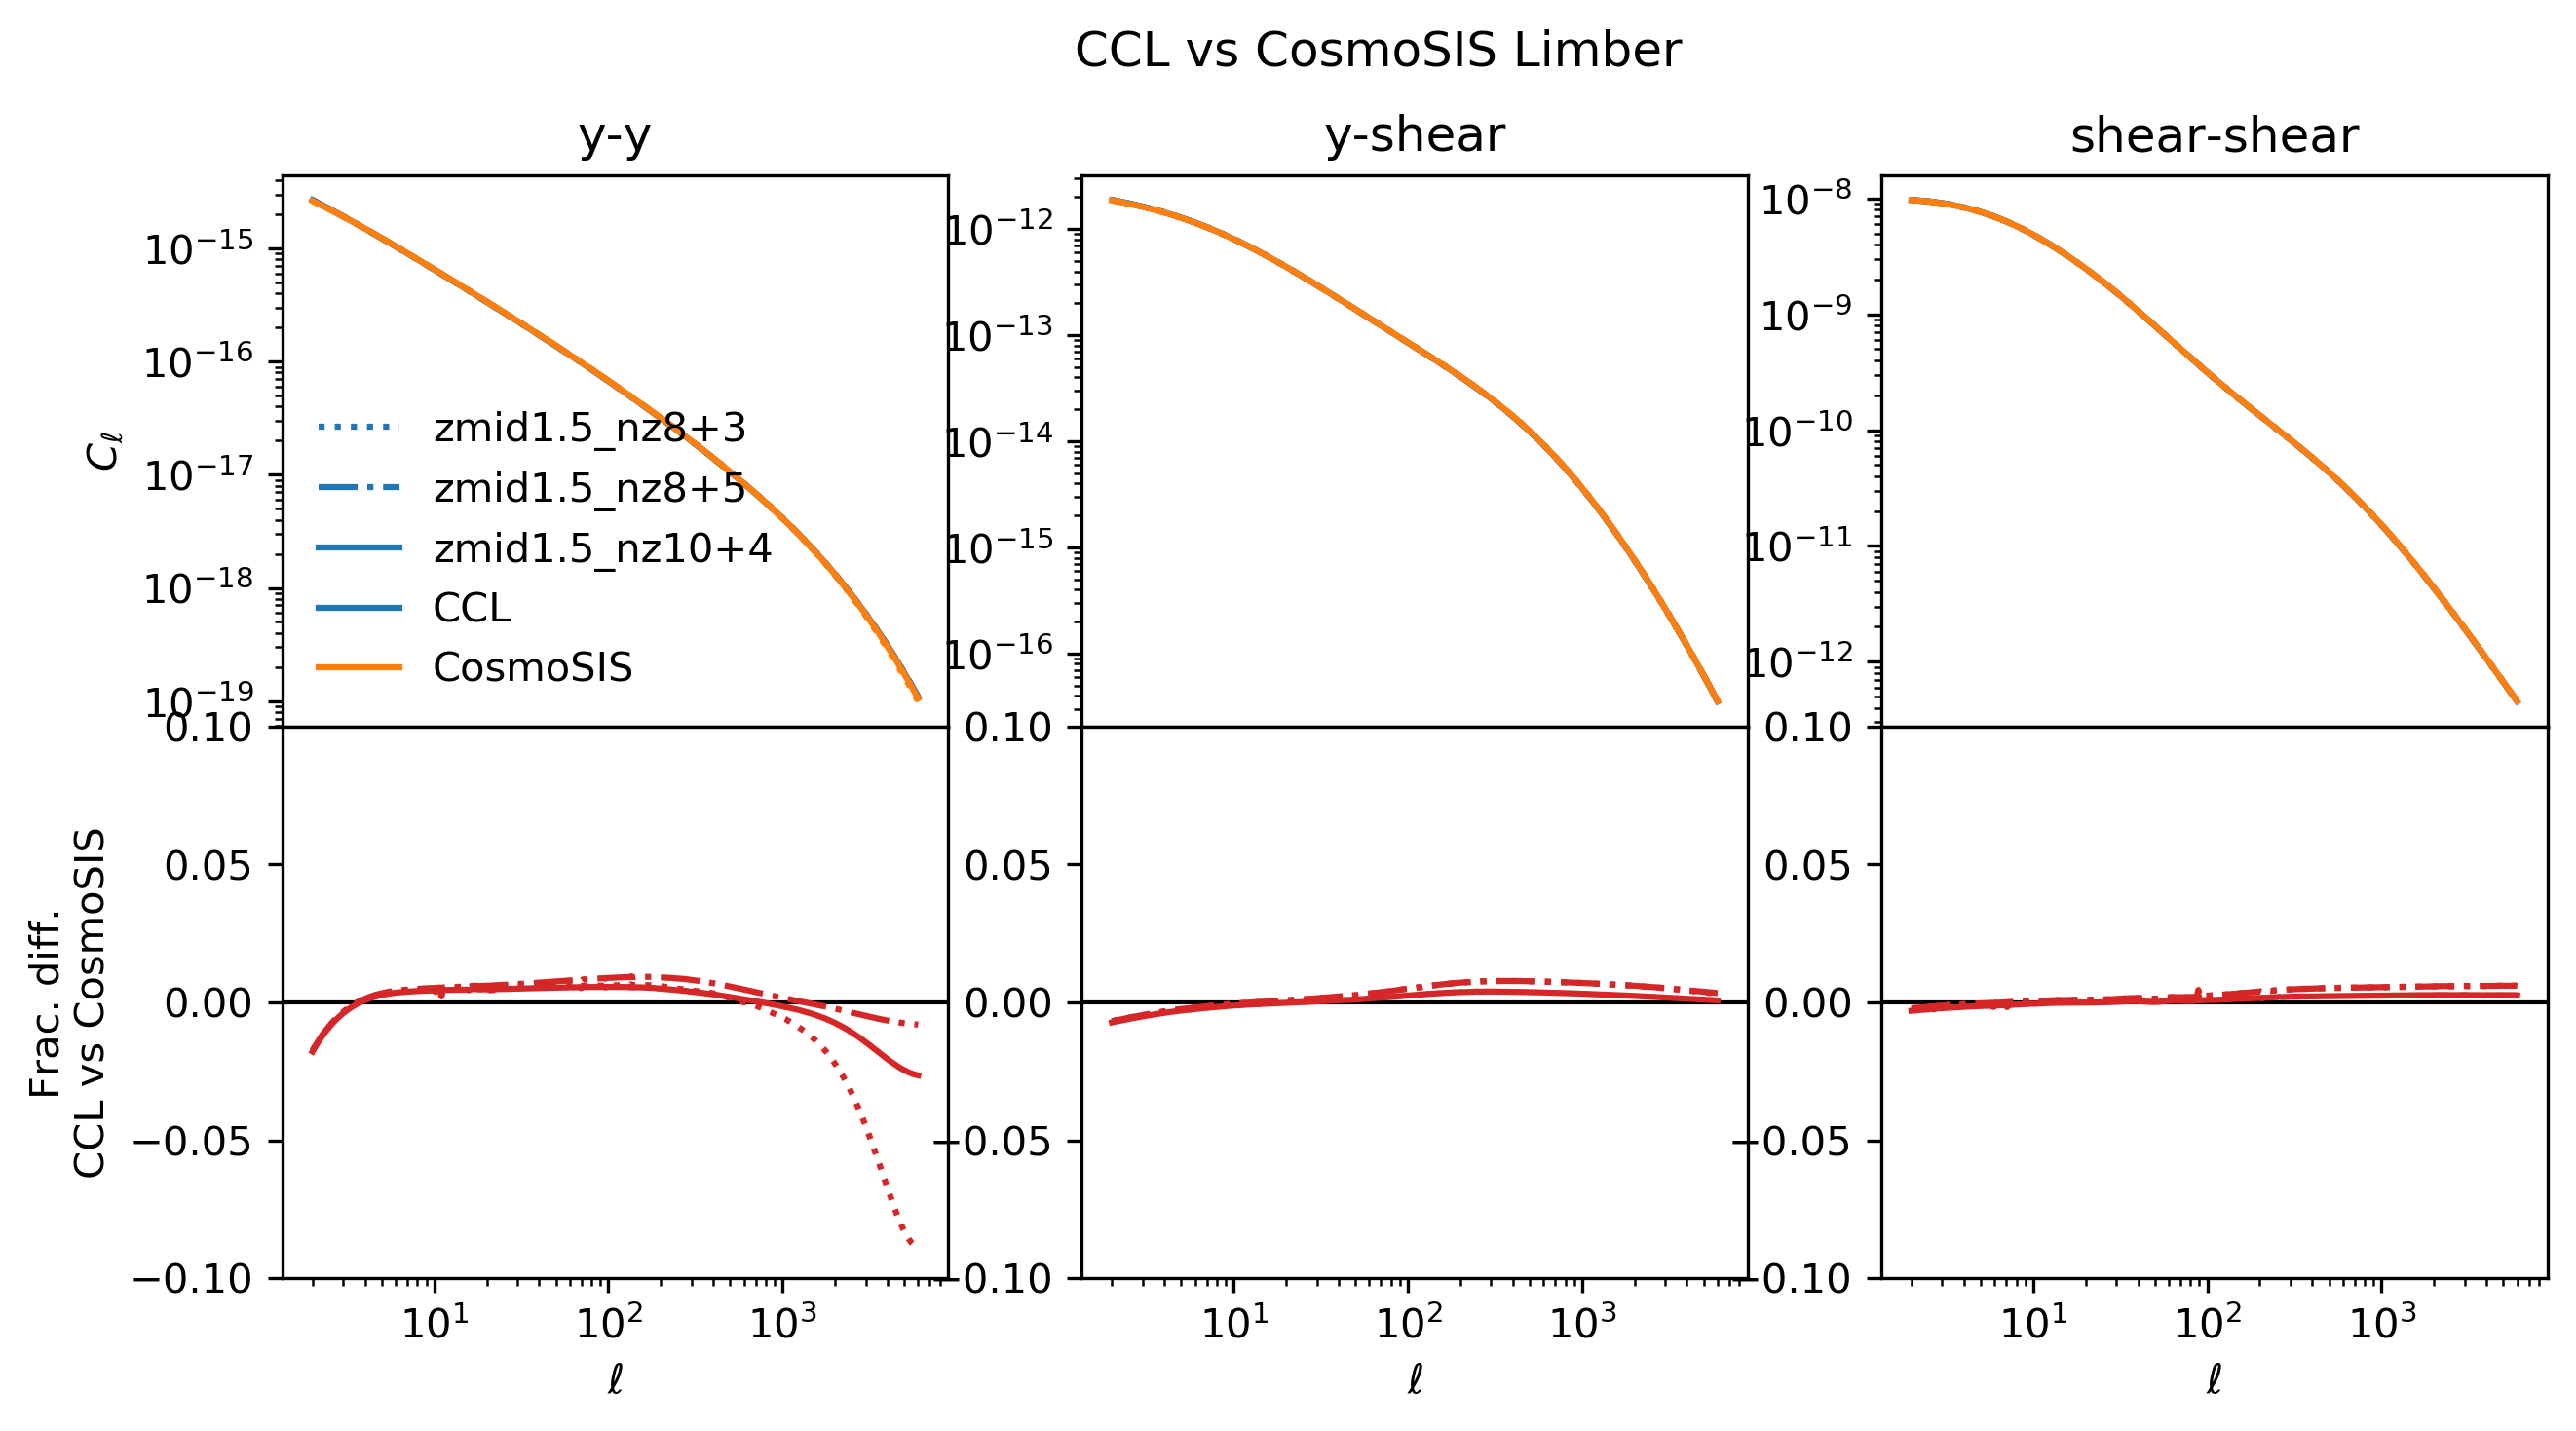

In [45]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(10, 5))
fig.subplots_adjust(hspace=0)

WL_bin = 1

for label, ls, cosmosis_block in [("zmid1.5_nz8+3", ":", blocks["zmid1.5_nz8+3"]),
                                  ("zmid1.5_nz8+5", "-.", blocks["zmid1.5_nz8+5"]),
                                  #("zmid2.0_nz8+3", "--", blocks["zmid2.0_nz8+3"]),
                                  ("zmid1.5_nz10+4", "-", blocks["zmid1.5_nz10+4"]),
                                  #("zmid3.0_nz32+8", "-", blocks["zmid3.0_nz32+8"]),
                                 ]:
    h = cosmosis_block["cosmological_parameters", "h0"]

#     ccl_cosmo = ccl.CosmologyCalculator(Omega_c=cosmosis_block["cosmological_parameters", "omega_c"],
#                                         Omega_b=cosmosis_block["cosmological_parameters", "omega_b"],
#                                         A_s=cosmosis_block["cosmological_parameters", "a_s"],
#                                         n_s=cosmosis_block["cosmological_parameters", "n_s"],
#                                         h=cosmosis_block["cosmological_parameters", "h0"],
#                                         background={"a" :         cosmosis_block["distances", "a"][::-1],
#                                                     "chi" :       cosmosis_block["distances", "d_m"][::-1],
#                                                     "h_over_h0" : cosmosis_block["distances", "h"][::-1]/cosmosis_block["distances", "h"][::-1][-1]},
#                                         pk_linear={"a":  1/(1+cosmosis_block["matter_power_lin", "z"])[::-1],
#                                                    "k": cosmosis_block["matter_power_lin", "k_h"]*h,
#                                                    "delta_matter:delta_matter": cosmosis_block["matter_power_lin", "p_k"][::-1]*h**-3},
#                                         )

    ccl_cosmo = ccl.Cosmology(Omega_c=cosmosis_block["cosmological_parameters", "omega_c"],
                              Omega_b=cosmosis_block["cosmological_parameters", "omega_b"],
                              A_s=cosmosis_block["cosmological_parameters", "a_s"],
                              n_s=cosmosis_block["cosmological_parameters", "n_s"],
                              h=cosmosis_block["cosmological_parameters", "h0"],
                              m_nu=cosmosis_block["cosmological_parameters", "mnu"],
                                        )

    a = 1/(1+cosmosis_block["pressure_pressure_power_spectrum", "z"][::-1])

    P_PP = ccl.Pk2D(a_arr=a,
                     lk_arr=np.log(cosmosis_block["pressure_pressure_power_spectrum", "k_h"]*h),
                     pk_arr=np.log(cosmosis_block["pressure_pressure_power_spectrum", "p_k"][::-1]*h**-3*a[:,None]**-6),
                     is_logp=True)
    P_PM = ccl.Pk2D(a_arr=1/(1+cosmosis_block["matter_pressure_power_spectrum", "z"][::-1]),
                     lk_arr=np.log(cosmosis_block["matter_pressure_power_spectrum", "k_h"]*h),
                     pk_arr=(cosmosis_block["matter_pressure_power_spectrum", "p_k"][::-1]*h**-3*a[:,None]**-3),
                     is_logp=False)
    P_MM = ccl.Pk2D(a_arr=1/(1+cosmosis_block["matter_power_nl", "z"][::-1]),
                     lk_arr=np.log(cosmosis_block["matter_power_nl", "k_h"]*h),
                     pk_arr=np.log(cosmosis_block["matter_power_nl", "p_k"][::-1]*h**-3),
                     is_logp=True)


    tSZ_tracer = ccl.tSZTracer(ccl_cosmo, z_max=cosmosis_block["pressure_pressure_power_spectrum", "z"][-1], n_chi=500
                              )
    
    WL_tracer = ccl.WeakLensingTracer(ccl_cosmo, 
                                      dndz=(cosmosis_block["nz_kids1000", "z"], 
                                            cosmosis_block["nz_kids1000", f"bin_{WL_bin}"])
                                     )
    
    WL_IA_tracer = ccl.WeakLensingTracer(ccl_cosmo, 
                                         dndz=(cosmosis_block["nz_kids1000", "z"], 
                                              cosmosis_block["nz_kids1000", f"bin_{WL_bin}"]),
                                         ia_bias=(cosmosis_block["nz_kids1000", "z"],
                                                  np.ones_like(cosmosis_block["nz_kids1000", "z"]))
                                         )
    
    ell = cosmosis_block["y_y_cl", "ell"]

    ccl_limber_fac = (ell+1/2)**2
    ccl_limber_shear_fac = np.sqrt((ell-1)*ell*(ell+1)*(ell+2))/(ell+1/2)**2

    Cl_y_y_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=tSZ_tracer, cltracer2=tSZ_tracer,
                                ell=ell,
                                p_of_k_a=P_PP,
                            )#*(ell+0.5)/ell

    Cl_y_shear_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=tSZ_tracer, cltracer2=WL_tracer,
                                ell=ell,
                                p_of_k_a=P_PM,
                            )/ccl_limber_shear_fac
    Cl_y_shear_ia_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=tSZ_tracer, cltracer2=WL_IA_tracer,
                                ell=ell,
                                p_of_k_a=P_PM,
                            )/ccl_limber_shear_fac

    Cl_shear_shear_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer, cltracer2=WL_tracer,
                                ell=ell,
                                p_of_k_a=P_MM,
                            )/ccl_limber_shear_fac**2

    ax[0,0].loglog(ell, Cl_y_y_ccl, c="C0", ls=ls, label=label)
    ax[0,0].loglog(ell, cosmosis_block["y_y_cl", "bin_1_1"], c="C1", ls=ls)
    ax[1,0].semilogx(ell, cosmosis_block["y_y_cl", "bin_1_1"]/Cl_y_y_ccl-1, c="C3", ls=ls)
    ax[0,0].set_title("y-y")

    ax[0,1].loglog(ell, Cl_y_shear_ccl, c="C0", ls=ls)
    ax[0,1].loglog(ell, cosmosis_block["shear_y_cl", f"bin_{WL_bin}_1"], c="C1", ls=ls)
    ax[1,1].semilogx(ell, cosmosis_block["shear_y_cl", f"bin_{WL_bin}_1"]/Cl_y_shear_ccl-1, c="C3", ls=ls)
    
    # IA
#     ax[0,1].loglog(ell, -(Cl_y_shear_ia_ccl-Cl_y_shear_ccl), c="C0", ls=ls)
#     ax[0,1].loglog(ell, -cosmosis_block["intrinsic_y_cl", f"bin_{WL_bin}_1"], c="C1", ls=ls)
#     ax[1,1].semilogx(ell, cosmosis_block["intrinsic_y_cl", f"bin_{WL_bin}_1"]/(Cl_y_shear_ia_ccl-Cl_y_shear_ccl)-1, c="C3", ls=ls)
    
    ax[0,1].set_title("y-shear")

    ax[0,2].loglog(ell, Cl_shear_shear_ccl, c="C0", ls=ls)
    ax[0,2].loglog(ell, cosmosis_block["shear_cl", f"bin_{WL_bin}_{WL_bin}"], c="C1", ls=ls)
    ax[1,2].semilogx(ell, cosmosis_block["shear_cl", f"bin_{WL_bin}_{WL_bin}"]/Cl_shear_shear_ccl - 1, c="C3", ls=ls)
    ax[0,2].set_title("shear-shear")


ax[0,0].plot([], [], label="CCL")
ax[0,0].plot([], [], label="CosmoSIS")

ax[0,0].set_ylabel("$C_\ell$")
ax[1,0].set_ylabel("Frac. diff.\nCCL vs CosmoSIS")

[a.axhline(0, c="k", lw=1, zorder=-100) for a in ax[1]]
[a.set_ylim(-0.1, 0.1) for a in ax[1]]
[a.set_xlabel("$\ell$") for a in ax[1]]

ax[0,0].legend(frameon=False)

fig.suptitle("CCL vs CosmoSIS Limber")
fig.dpi = 300
fig.savefig("plots/CosmoSIS_vs_CCL.png")

## CCL Pk2D consistency

Text(0.5, 1.0, 'CCL shear-shear internal vs external P(k)')

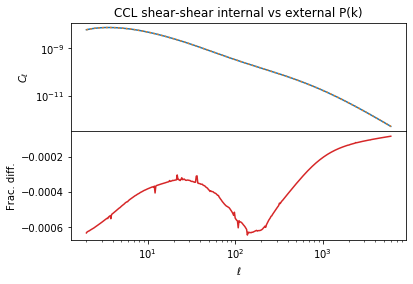

In [220]:
cosmosis_block = blocks["cov"]

ccl_cosmo = ccl.Cosmology(Omega_c=cosmosis_block["cosmological_parameters", "omega_c"],
                          Omega_b=cosmosis_block["cosmological_parameters", "omega_b"],
                          A_s=cosmosis_block["cosmological_parameters", "a_s"],
                          n_s=cosmosis_block["cosmological_parameters", "n_s"],
                          h=cosmosis_block["cosmological_parameters", "h0"],
                          m_nu=cosmosis_block["cosmological_parameters", "mnu"],
                          )

z_arr = np.linspace(0, 1.0, 10)[::-1]
a_arr = 1/(1+z_arr) #np.linspace(0.5, 1.0, 10)
k_arr = np.logspace(-4, 2, 100)

pk_arr = np.zeros((len(a_arr), len(k_arr)))
for i, a in enumerate(a_arr):
    pk_arr[i] = ccl.nonlin_matter_power(ccl_cosmo, k_arr, a)
    
P_MM = ccl.Pk2D(a_arr=a_arr,
                lk_arr=np.log(k_arr),
                pk_arr=np.log(pk_arr),
                is_logp=True)
    
z, nz = np.loadtxt(f"/Users/yooken/Research/KiDS/kcap/../Cat_to_Obs_K1000_P1/data/kids/nofz/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_DIRcols_Fid_blindC_TOMO{WL_bin}_Nz.asc", unpack=True)

WL_tracer = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z+0.025, nz))

ell = np.geomspace(2, 6000, 400)

Cl_internal_pk_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer, cltracer2=WL_tracer,
                                    ell=ell)
Cl_external_pk_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer, cltracer2=WL_tracer,
                                    ell=ell, p_of_k_a=P_MM)

fig, ax = plt.subplots(2, 1, squeeze=False, sharex=True)
fig.subplots_adjust(hspace=0)

ax[0,0].loglog(ell, Cl_internal_pk_ccl, c="C0", label="Internal")
ax[0,0].loglog(ell, Cl_external_pk_ccl, c="C1", ls=":", label="External")
ax[1,0].semilogx(ell, Cl_external_pk_ccl/Cl_internal_pk_ccl-1, c="C3")

ax[0,0].set_ylabel("$C_\ell$")
ax[1,0].set_ylabel("Frac. diff.")
ax[1,0].set_xlabel("$\ell$")
ax[0,0].set_title("CCL shear-shear internal vs external P(k)")


## CCL vs CosmoSIS shear-shear Halofit

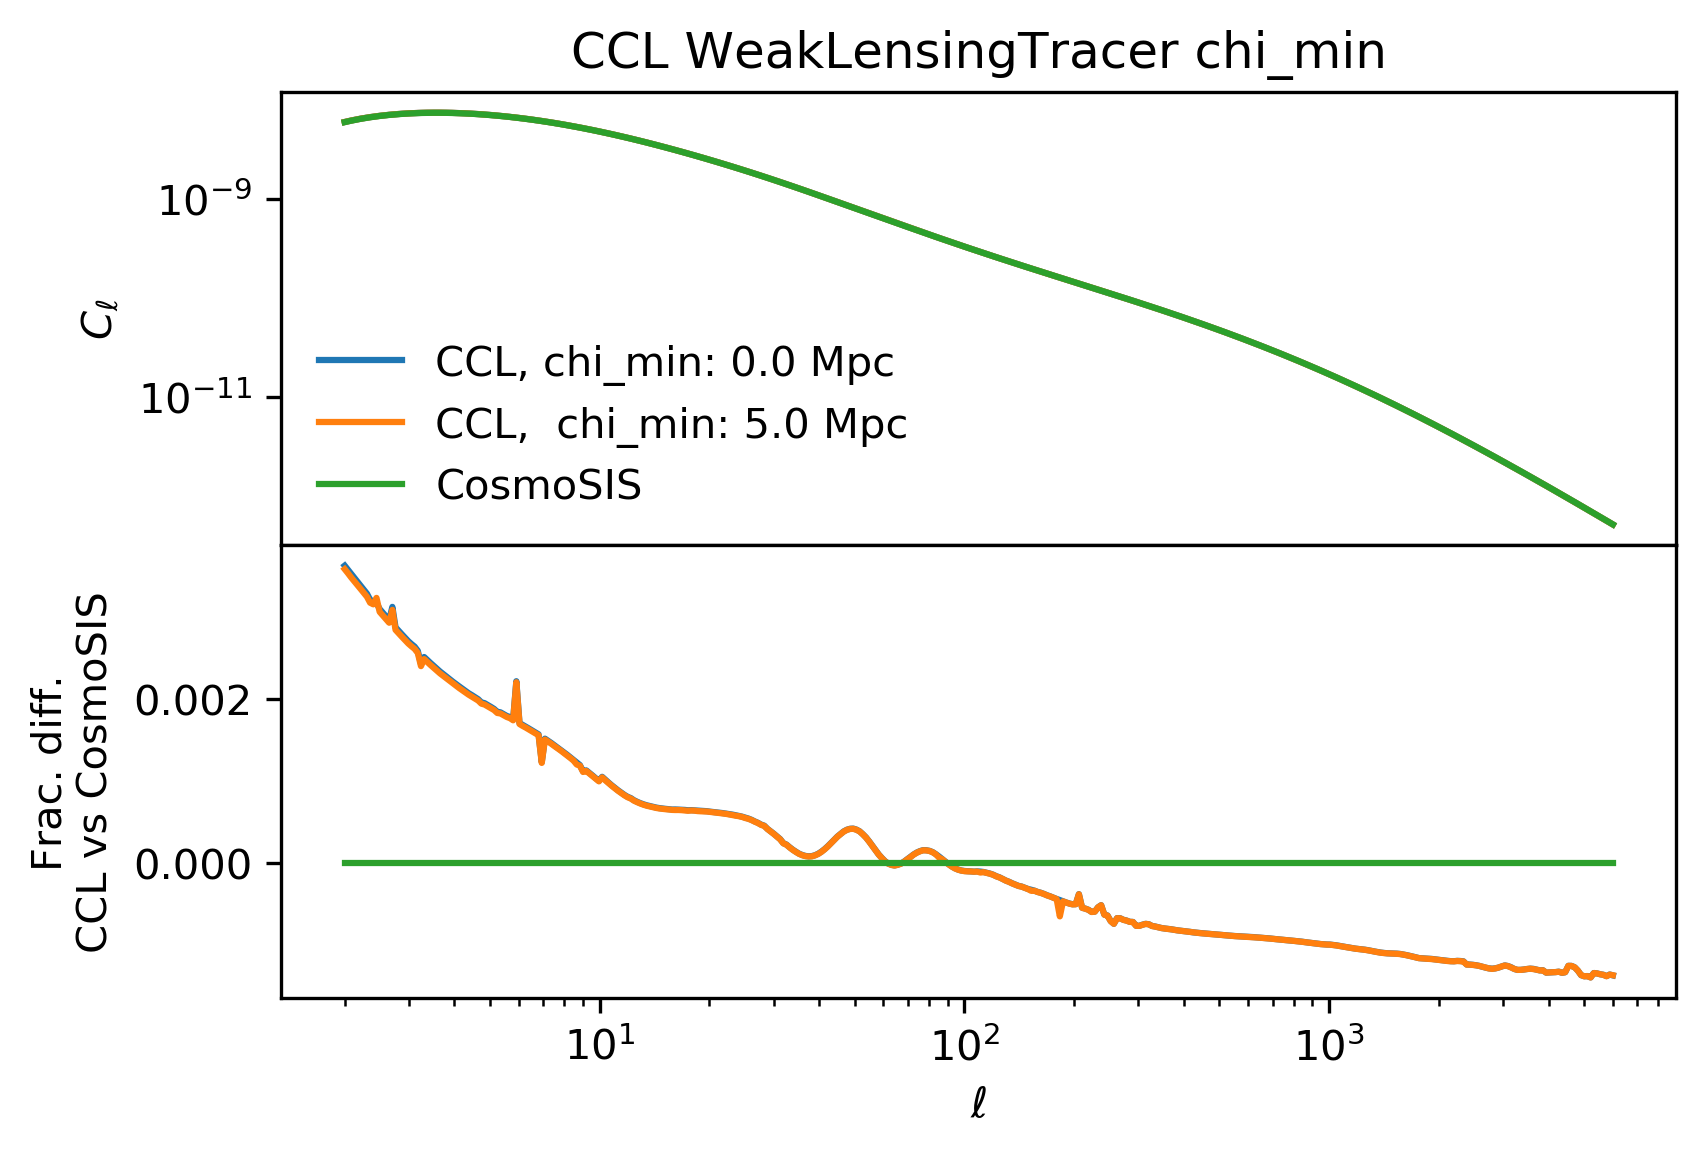

In [221]:
cosmosis_block = blocks["shear_only_halofit"]
h = cosmosis_block["cosmological_parameters", "h0"]

ccl_cosmo = ccl.Cosmology(Omega_c=cosmosis_block["cosmological_parameters", "omega_c"],
                          Omega_b=cosmosis_block["cosmological_parameters", "omega_b"],
                          A_s=cosmosis_block["cosmological_parameters", "a_s"],
                          n_s=cosmosis_block["cosmological_parameters", "n_s"],
                          h=cosmosis_block["cosmological_parameters", "h0"],
                          m_nu=cosmosis_block["cosmological_parameters", "mnu"],
                          )

z_cosmosis = cosmosis_block["matter_power_nl", "z"][::-1][:]
a_cosmosis = 1/(1+z_cosmosis)
k_cosmosis = cosmosis_block["matter_power_nl", "k_h"]*h
pk_cosmosis = cosmosis_block["matter_power_nl", "p_k"][::-1][:]*h**-3

P_MM_cosmosis = ccl.Pk2D(a_arr=a_cosmosis,
                     lk_arr=np.log(k_cosmosis),
                     pk_arr=np.log(pk_cosmosis),
                     is_logp=True)

z_arr = z_cosmosis
a_arr = 1/(1+z_arr) #np.linspace(0.5, 1.0, 10)
k_arr = k_cosmosis

pk_arr = np.zeros((len(a_arr), len(k_arr)))
for i, a in enumerate(a_arr):
    pk_arr[i] = ccl.nonlin_matter_power(ccl_cosmo, k_arr, a)
    
P_MM_ccl = ccl.Pk2D(a_arr=a_arr,
                lk_arr=np.log(k_arr),
                pk_arr=np.log(pk_arr),
                is_logp=True)

WL_bin = 1

WL_tracer = ccl.WeakLensingTracer(ccl_cosmo, dndz=(cosmosis_block["nz_kids1000", "z"], 
                                                   cosmosis_block["nz_kids1000", f"bin_{WL_bin}"]))

WL_tracer_fix = ccl.WeakLensingTracer(ccl_cosmo, dndz=(cosmosis_block["nz_kids1000", "z"], 
                                                   cosmosis_block["nz_kids1000", f"bin_{WL_bin}"]))
WL_tracer_fix._trc[0].chi_min = 5.0

ell = cosmosis_block["shear_cl", "ell"]
ccl_limber_shear_fac = np.sqrt((ell-1)*ell*(ell+1)*(ell+2))/(ell+1/2)**2

Cl_cosmosis = cosmosis_block["shear_cl", f"bin_{WL_bin}_{WL_bin}"]*ccl_limber_shear_fac**2

Cl_internal_pk_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer, cltracer2=WL_tracer,
                                    ell=ell)
Cl_external_ccl_pk_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer, cltracer2=WL_tracer,
                                        ell=ell, p_of_k_a=P_MM_ccl)
Cl_external_cosmosis_pk_ccl = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer, cltracer2=WL_tracer,
                                             ell=ell, p_of_k_a=P_MM_cosmosis,
                                             limber_integration_method="spline")
Cl_external_cosmosis_pk_ccl_fixed_tracer = ccl.angular_cl(ccl_cosmo, cltracer1=WL_tracer_fix, cltracer2=WL_tracer_fix,
                                             ell=ell, p_of_k_a=P_MM_cosmosis)

fig, ax = plt.subplots(2, 1, squeeze=False, sharex=True)
fig.subplots_adjust(hspace=0)

Cl_fid = Cl_cosmosis
for label, Cl in [#("CCL, Internal P(k)", Cl_internal_pk_ccl),
                  #("CCL, External P(k), CCL", Cl_external_ccl_pk_ccl),
                  (f"CCL, chi_min: {WL_tracer._trc[0].chi_min:.1f} Mpc", Cl_external_cosmosis_pk_ccl),
                  (f"CCL,  chi_min: {WL_tracer_fix._trc[0].chi_min:.1f} Mpc", Cl_external_cosmosis_pk_ccl_fixed_tracer),
                  ("CosmoSIS", Cl_cosmosis),]:
    ax[0,0].loglog(ell, Cl, label=label)
    ax[1,0].semilogx(ell, Cl/Cl_fid-1, label=label)

ax[0,0].legend(frameon=False)

ax[0,0].set_ylabel("$C_\ell$")
ax[1,0].set_ylabel("Frac. diff.\nCCL vs CosmoSIS")
ax[1,0].set_xlabel("$\ell$")
ax[0,0].set_title("CCL WeakLensingTracer chi_min")

fig.dpi = 300
fig.savefig("plots/lensing_tracer_chi_min.png")

## Trispectrum

In [32]:
cosmosis_block = blocks["cov"]

ccl_cosmo = ccl.Cosmology(Omega_c=cosmosis_block["cosmological_parameters", "omega_c"],
                                        Omega_b=cosmosis_block["cosmological_parameters", "omega_b"],
                                        A_s=cosmosis_block["cosmological_parameters", "a_s"],
                                        n_s=cosmosis_block["cosmological_parameters", "n_s"],
                                        h=cosmosis_block["cosmological_parameters", "h0"],
                                        )


In [33]:
import pyhmcode

In [34]:
hmcode_cosmo = pyhmcode.Cosmology()

hmcode_cosmo.om_m = cosmosis_block["cosmological_parameters", "omega_m"]
hmcode_cosmo.om_b = cosmosis_block["cosmological_parameters", "omega_b"]
hmcode_cosmo.om_v = cosmosis_block["cosmological_parameters", "omega_lambda"]
hmcode_cosmo.h = cosmosis_block["cosmological_parameters", "h0"]
hmcode_cosmo.ns = cosmosis_block["cosmological_parameters", "n_s"]
hmcode_cosmo.sig8 = cosmosis_block["cosmological_parameters", "sigma_8"]
hmcode_cosmo.m_nu = cosmosis_block["cosmological_parameters", "mnu"]

hmcode_cosmo.set_linear_power_spectrum(cosmosis_block["matter_power_lin", "k_h"], 
                                        cosmosis_block["matter_power_lin", "z"], 
                                        cosmosis_block["matter_power_lin", "p_k"])


# hmcode_Pk = {}

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmcode_Pk["matter"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_matter,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmod.response_baseline = 0
# hmcode_Pk["matter_no_response"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_matter,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmod.response_baseline = 0
# hmod.twhim_array = hmod.twhim_array * 1e-4
# hmcode_Pk["matter_no_response_no_twhim"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_matter,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmod.response_baseline = 0
# hmod.twhim_array = hmod.twhim_array * 1e-4
# hmod.m0_array = hmod.m0_array * 1e-4
# hmcode_Pk["matter_no_response_no_diffuse"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_matter,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmcode_Pk["cdm"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_cdm,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmod.response_baseline = 0
# hmcode_Pk["cdm_no_response"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_cdm,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)

# hmod = pyhmcode.Halomodel(pyhmcode.HMx2020_matter_pressure_w_temp_scaling, verbose=True)
# hmod.twhim_array = hmod.twhim_array * 1e-3
# hmod.response_baseline = 0
# hmcode_Pk["cdm_no_response_no_twhim"] = pyhmcode.calculate_nonlinear_power_spectrum(
#                                             hmcode_cosmo, hmod, 
#                                             fields=[pyhmcode.field_cdm,
#                                                     pyhmcode.field_electron_pressure],
#                                             verbose=True)


In [36]:
HMX_profiles = HMxProfileGenerator(hmcode_cosmo, a_arr=np.linspace(1/(1+6), 1, 32), 
                                   k_arr=np.logspace(-5, 2, 100), verbose=True)

HMX_profiles.matter_profile


Computing profile look-up table
Computing a =  0.14285714285714285
Computing a =  0.1705069124423963
Computing a =  0.19815668202764977
Computing a =  0.22580645161290322
Computing a =  0.2534562211981567
Computing a =  0.28110599078341014
Computing a =  0.3087557603686636
Computing a =  0.33640552995391704
Computing a =  0.3640552995391705
Computing a =  0.39170506912442393
Computing a =  0.41935483870967744
Computing a =  0.4470046082949309
Computing a =  0.47465437788018433
Computing a =  0.5023041474654377
Computing a =  0.5299539170506913
Computing a =  0.5576036866359447
Computing a =  0.5852534562211982
Computing a =  0.6129032258064516
Computing a =  0.6405529953917051
Computing a =  0.6682027649769586
Computing a =  0.695852534562212
Computing a =  0.7235023041474655
Computing a =  0.7511520737327189
Computing a =  0.7788018433179724
Computing a =  0.8064516129032258
Computing a =  0.8341013824884793
Computing a =  0.8617511520737327
Computing a =  0.8894009216589862
Computing

In [291]:

mass_def = ccl.halos.MassDef("vir", 'matter')
hmf = ccl.halos.MassFuncSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hmc = ccl.halos.HMCalculator(ccl_cosmo, hmf, hbf, mass_def)


a = np.linspace(1/(1+6), 1.0, 12)
k = np.logspace(-4, 1.5, 100)
# Power spectrum
pk_cdm_cdm_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.cdm_profile,
                                                normprof1=False,
                                                a_arr=a, lk_arr=np.log(k),#get_2h=False,
                                                )

pk_matter_matter_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.matter_profile,
                                                normprof1=False,
                                                a_arr=a, lk_arr=np.log(k),#get_2h=False,
                                                )
pk_matter_matter_1h_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.matter_profile,
                                                normprof1=False,
                                                a_arr=a, lk_arr=np.log(k), get_2h=False,
                                                )
pk_matter_matter_2h_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.matter_profile,
                                                normprof1=False,
                                                a_arr=a, lk_arr=np.log(k), get_1h=False,
                                                )

pk_pressure_cdm_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.pressure_profile,
                                                prof2=HMX_profiles.cdm_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                )
pk_pressure_matter_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.pressure_profile,
                                                prof2=HMX_profiles.matter_profile,
                                                normprof1=False, normprof2=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                )
pk_pressure_pressure_ccl = ccl.halos.halomod_Pk2D(cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=HMX_profiles.pressure_profile,
                                                normprof1=False,
                                                a_arr=a, lk_arr=np.log(k),
                                                )

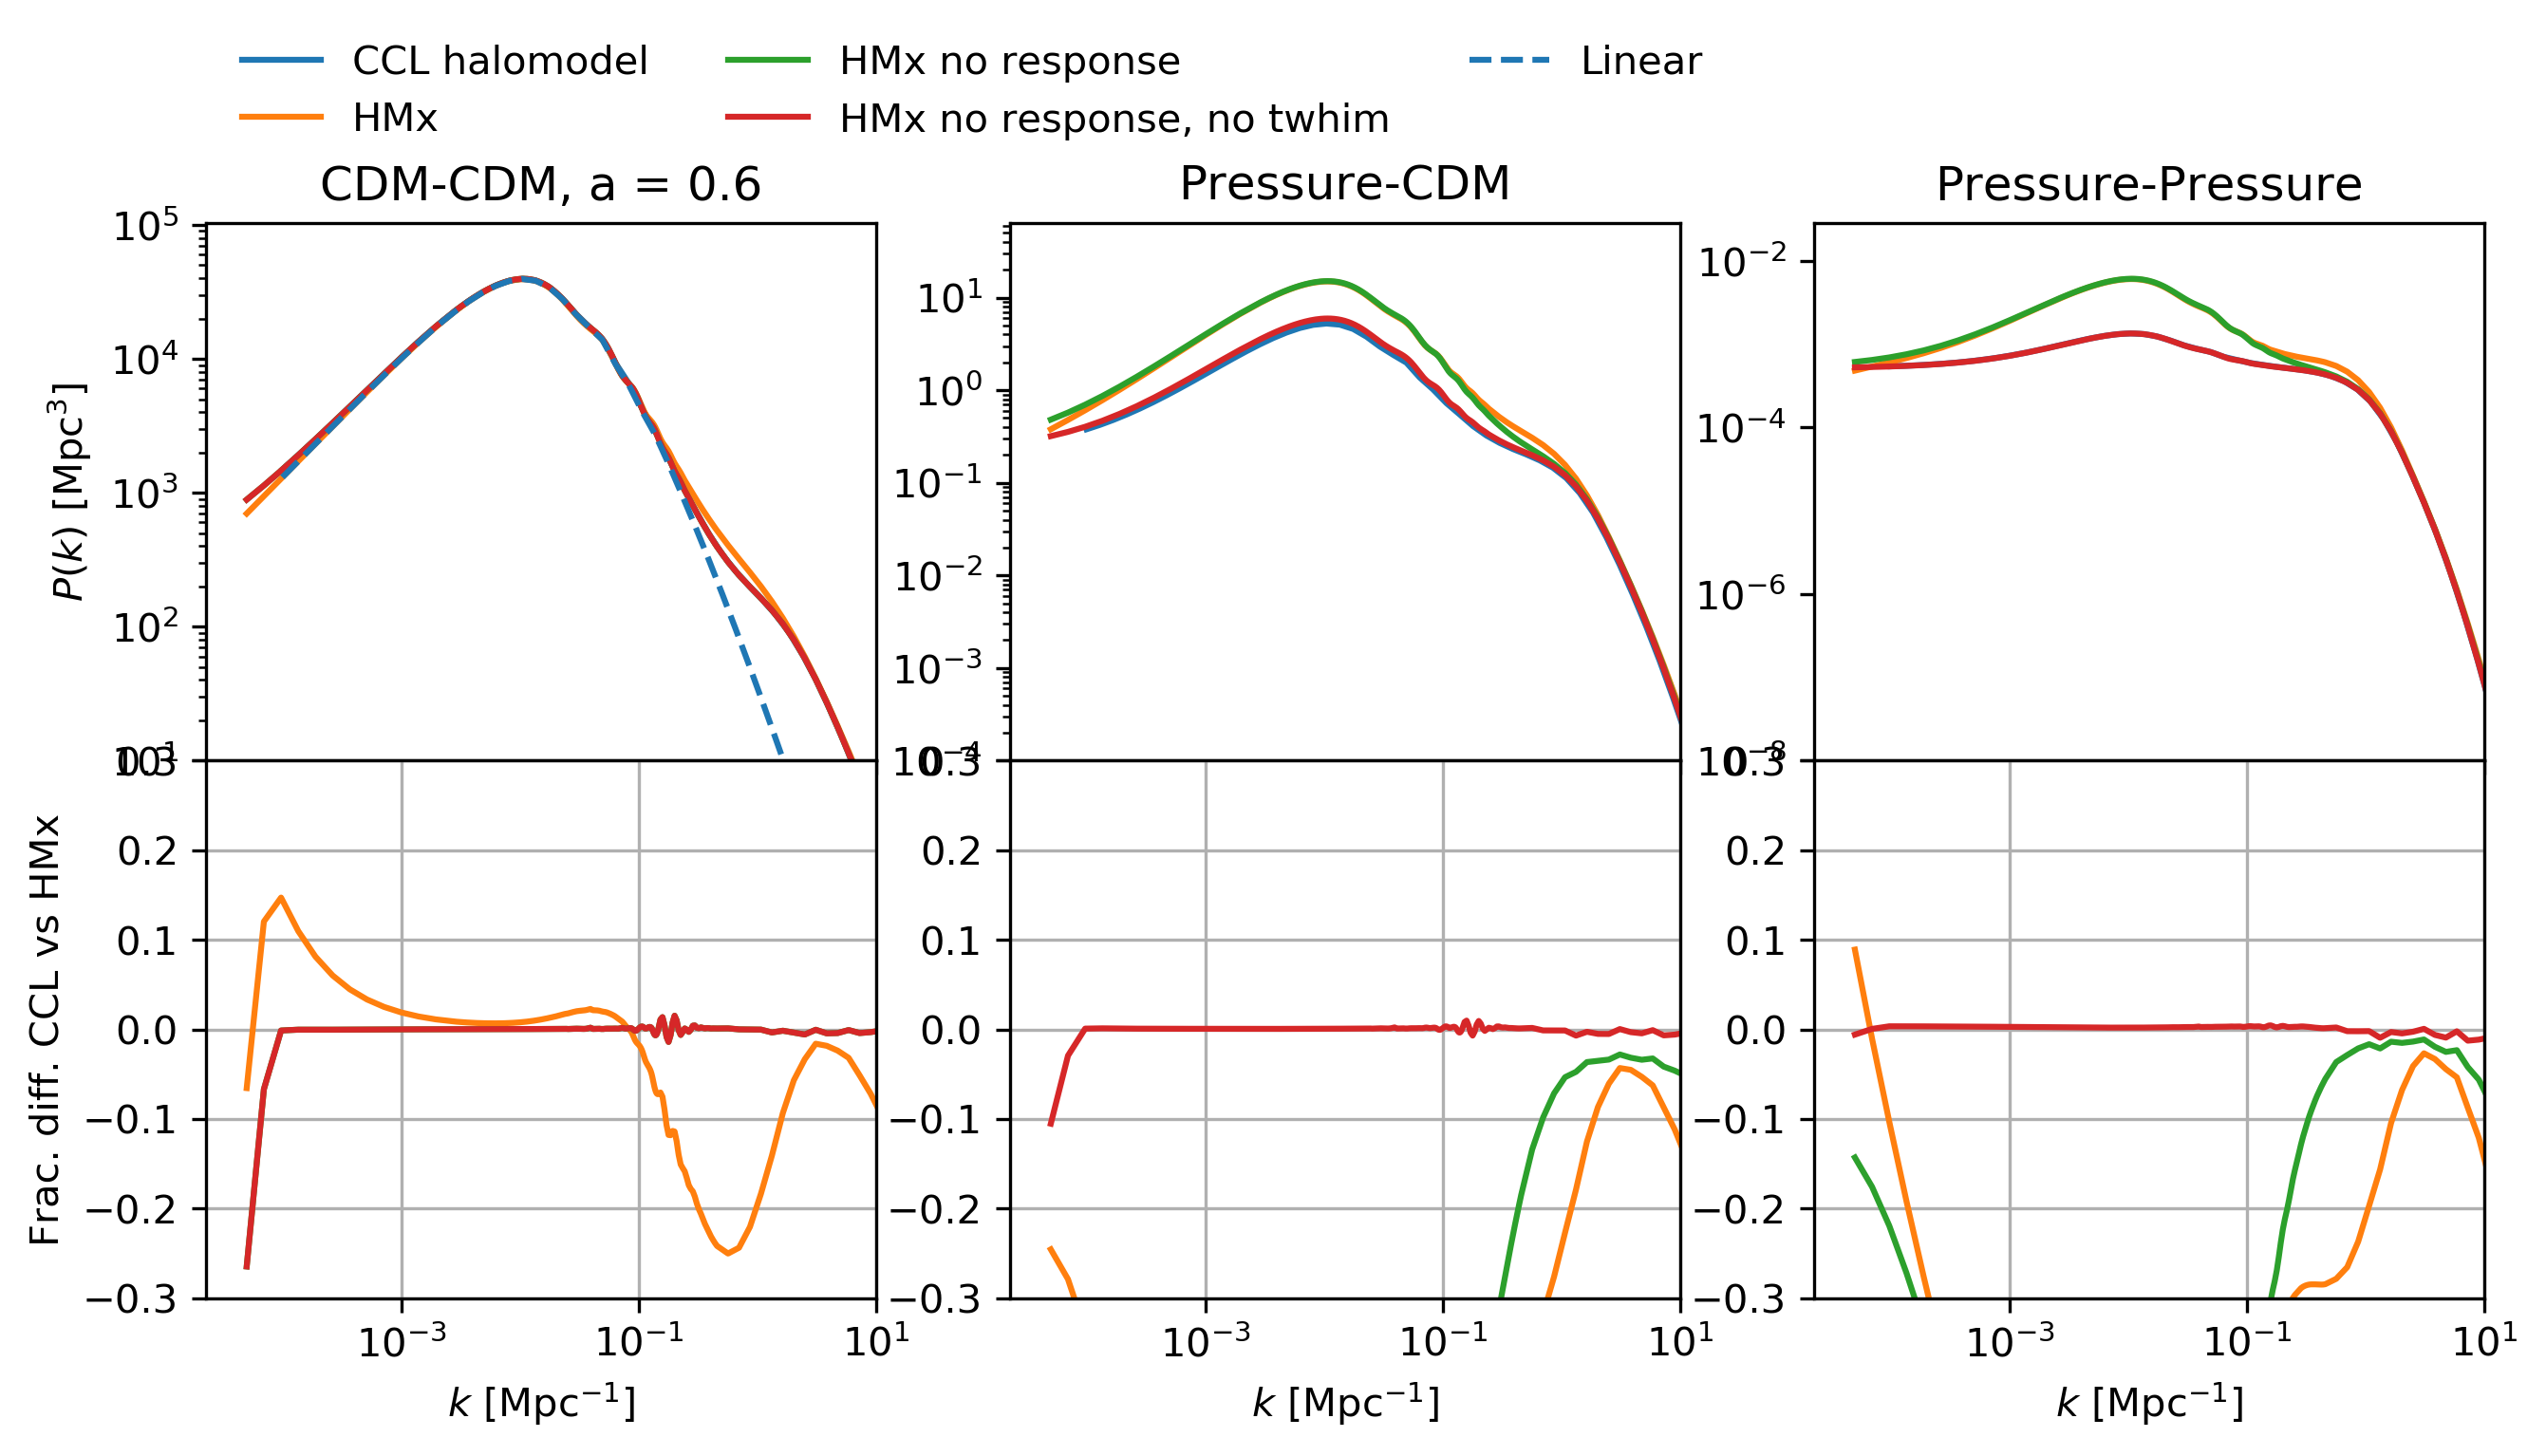

In [283]:
k = np.logspace(-4, 1.5, 50)
cosmosis_k = cosmosis_block["pressure_pressure_power_spectrum", "k_h"]*h
a_idx = 5
a = 1/(1+cosmosis_block["pressure_pressure_power_spectrum", "z"][a_idx])

fig, ax = plt.subplots(2, 3, sharex=True, squeeze=False, figsize=(10, 5))
fig.subplots_adjust(hspace=0, left=0.1)


ax[0,0].set_title(f"CDM-CDM, a = {a:.1f}")
ax[0,0].loglog(k, pk_cdm_cdm_ccl.eval(k, a, ccl_cosmo), label="CCL halomodel")

for i, (HMx_label, HMx_Pk) in enumerate(
                         [("HMx", hmcode_Pk["cdm"]),
                          ("HMx no response", hmcode_Pk["cdm_no_response"]),
                          ("HMx no response, no twhim", hmcode_Pk["cdm_no_response_no_twhim"])]):
    ax[0,0].loglog(cosmosis_block["matter_power_nl", "k_h"]*h, 
                   HMx_Pk[0,0,a_idx]*h**-3*(ccl_cosmo["Omega_m"]/ccl_cosmo["Omega_c"])**2,
                   c=f"C{i+1}", label=HMx_label)
    ax[1,0].semilogx(cosmosis_k, 
                     (pk_cdm_cdm_ccl.eval(cosmosis_k, a, ccl_cosmo))/(HMx_Pk[0,0,a_idx]*h**-3*(ccl_cosmo["Omega_m"]/ccl_cosmo["Omega_c"])**2) - 1,
                     c=f"C{i+1}", label=HMx_label)


ax[0,0].loglog(k, ccl.linear_matter_power(ccl_cosmo, k, a), ls="--", c="C0", label="Linear")

ax[0,0].set_ylim(bottom=1e1)
ax[0,0].set_xlim(right=10)
ax[0,0].legend(ncol=3, frameon=False, loc="upper left", bbox_to_anchor=(0,1.4))

ax[1,0].set_ylim(-0.3, 0.3)
ax[1,0].grid()

ax[0,0].set_ylabel("$P(k)$ [Mpc$^3$]")
ax[1,0].set_ylabel("Frac. diff. CCL vs HMx")
ax[1,0].set_xlabel("$k$ [Mpc$^{-1}$]")

ax[0,1].set_title("Pressure-CDM")
ax[0,1].loglog(k, pk_pressure_matter_ccl.eval(k, a, ccl_cosmo), label="CCL halomodel")

for i, (HMx_label, HMx_Pk) in enumerate(
                         [("HMx", hmcode_Pk["cdm"]),
                          ("HMx no response", hmcode_Pk["cdm_no_response"]),
                          ("HMx no response, no twhim", hmcode_Pk["cdm_no_response_no_twhim"])]):
    ax[0,1].loglog(cosmosis_k, 
                   HMx_Pk[0,1,a_idx]*h**-3*a**-3*(ccl_cosmo["Omega_m"]/ccl_cosmo["Omega_c"]),
                   c=f"C{i+1}", label=HMx_label)
    ax[1,1].semilogx(cosmosis_k, 
                     pk_pressure_cdm_ccl.eval(cosmosis_k, a, ccl_cosmo)/(HMx_Pk[0,1,a_idx]*h**-3*a**-3*(ccl_cosmo["Omega_m"]/ccl_cosmo["Omega_c"])) - 1,
                     c=f"C{i+1}", label=HMx_label)


ax[0,1].set_ylim(bottom=1e-4)
ax[0,1].set_xlim(right=10)

ax[1,1].set_ylim(-0.3, 0.3)
ax[1,1].grid()
ax[1,1].set_xlabel("$k$ [Mpc$^{-1}$]")

ax[0,2].set_title("Pressure-Pressure")
ax[0,2].loglog(k, pk_pressure_pressure_ccl.eval(k, a, ccl_cosmo), label="CCL halomodel")

for i, (HMx_label, HMx_Pk) in enumerate(
                         [("HMx", hmcode_Pk["cdm"]),
                          ("HMx no response", hmcode_Pk["cdm_no_response"]),
                          ("HMx no response, no twhim", hmcode_Pk["cdm_no_response_no_twhim"])]):
    ax[0,2].loglog(cosmosis_k, 
                   HMx_Pk[1,1,a_idx]*h**-3*a**-6, c=f"C{i+1}", label=HMx_label)
    ax[1,2].semilogx(cosmosis_k, 
                     pk_pressure_pressure_ccl.eval(cosmosis_k, a, ccl_cosmo)/(HMx_Pk[1,1,a_idx]*h**-3*a**-6) - 1,
                     c=f"C{i+1}", label=HMx_label)


ax[0,2].set_ylim(bottom=1e-8)
ax[0,2].set_xlim(right=10)

ax[1,2].set_ylim(-0.3, 0.3)
ax[1,2].grid()
ax[1,2].set_xlabel("$k$ [Mpc$^{-1}$]")


fig.dpi = 300
fig.savefig("plots/CCL_halomodel_vs_HMx_cdm.png")

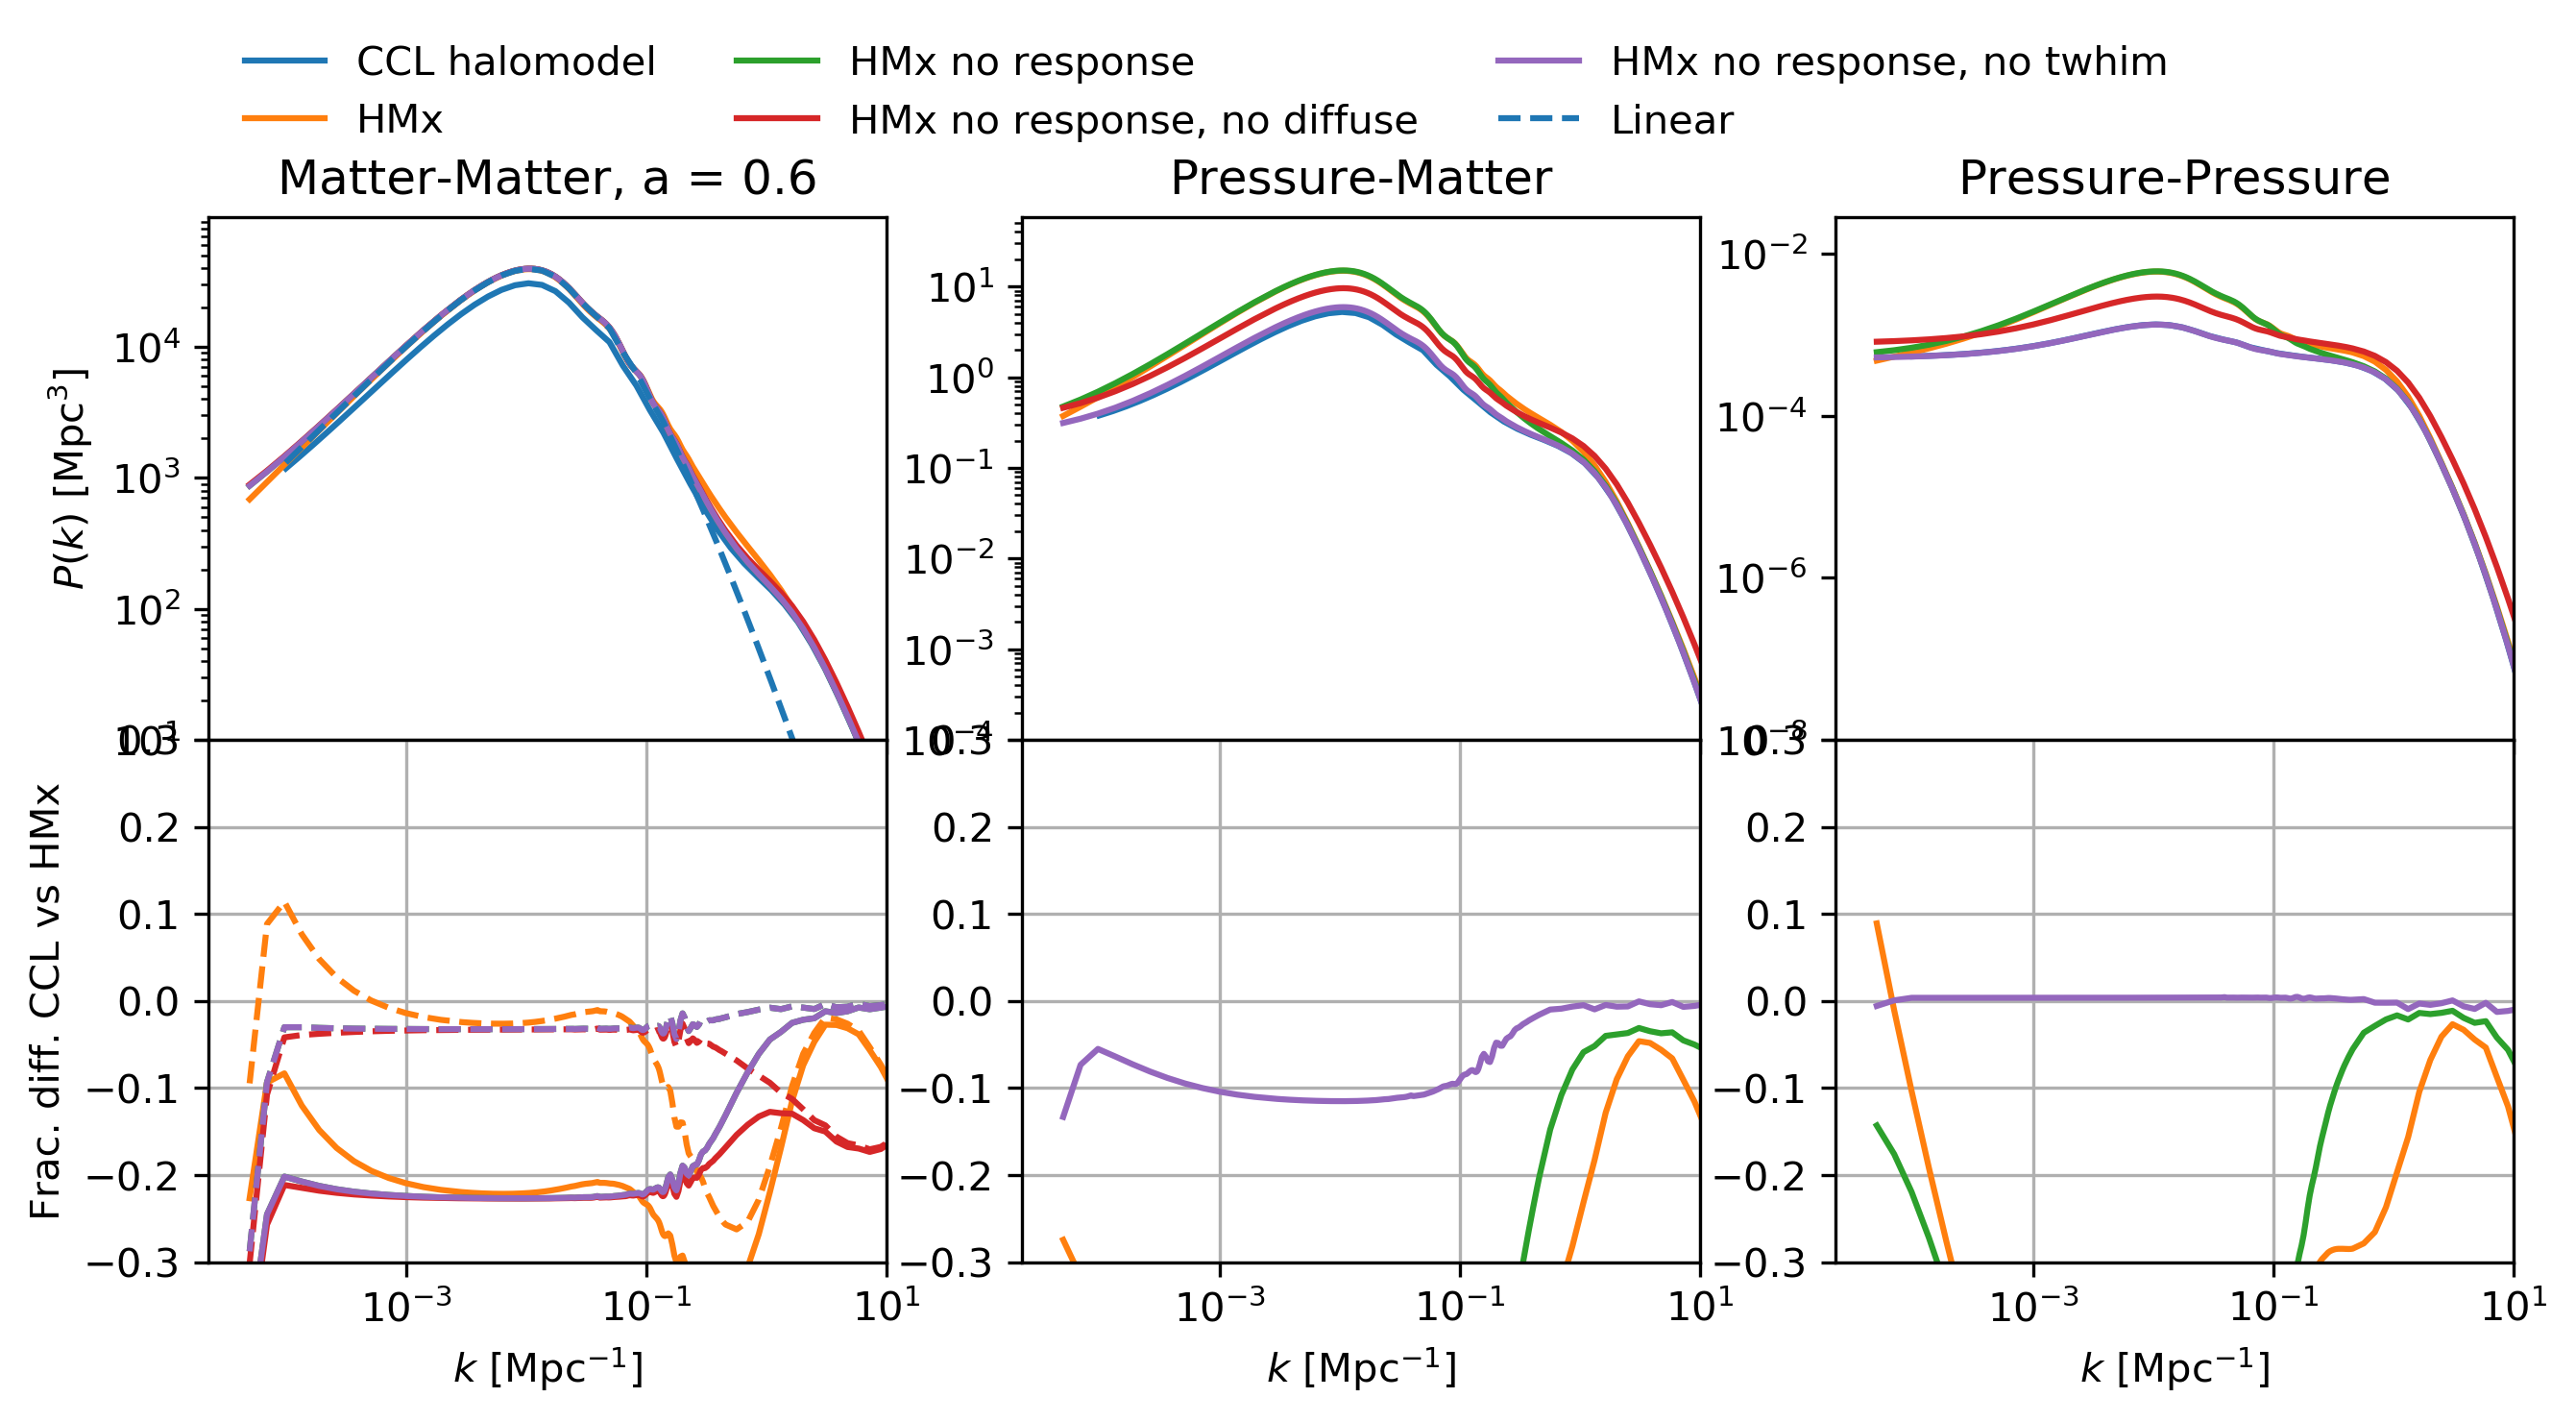

In [292]:
cosmosis_block = blocks["cov"]

k = np.logspace(-4, 1.5, 50)
cosmosis_k = cosmosis_block["pressure_pressure_power_spectrum", "k_h"]*h
a_idx = 5
a = 1/(1+cosmosis_block["pressure_pressure_power_spectrum", "z"][a_idx])

uk0_matter = HMX_profiles.matter_profile.fourier(cosmo=ccl_cosmo, k=1e-5, a=a, M=hmc._mass)
I_1_1_matter = hmc._integrate_over_mbf(uk0_matter)

fig, ax = plt.subplots(2, 3, sharex=True, squeeze=False, figsize=(10, 5))
fig.subplots_adjust(hspace=0, left=0.1, top=0.85)


ax[0,0].set_title(f"Matter-Matter, a = {a:.1f}")
ax[0,0].loglog(k, pk_matter_matter_ccl.eval(k, a, ccl_cosmo), label="CCL halomodel")

for i, (HMx_label, HMx_Pk) in enumerate(
                         [("HMx", hmcode_Pk["matter"]),
                          ("HMx no response", hmcode_Pk["matter_no_response"]),
                          ("HMx no response, no diffuse", hmcode_Pk["matter_no_response_no_diffuse"]),
                          ("HMx no response, no twhim", hmcode_Pk["matter_no_response_no_twhim"])]):
    ax[0,0].loglog(cosmosis_block["matter_power_nl", "k_h"]*h, 
                   HMx_Pk[0,0,a_idx]*h**-3, c=f"C{i+1}", label=HMx_label)
    ax[1,0].semilogx(cosmosis_k, 
                     (pk_matter_matter_ccl.eval(cosmosis_k, a, ccl_cosmo))/(HMx_Pk[0,0,a_idx]*h**-3) - 1,
                     c=f"C{i+1}", label=HMx_label)
    ax[1,0].semilogx(cosmosis_k, 
                     (pk_matter_matter_1h_ccl.eval(cosmosis_k, a, ccl_cosmo)+1/I_1_1_matter**2*pk_matter_matter_2h_ccl.eval(cosmosis_k, a, ccl_cosmo))/(HMx_Pk[0,0,a_idx]*h**-3) - 1,
                     c=f"C{i+1}", ls="--", label=HMx_label)


ax[0,0].loglog(k, ccl.linear_matter_power(ccl_cosmo, k, a), ls="--", c="C0", label="Linear")

ax[0,0].set_ylim(bottom=1e1)
ax[0,0].set_xlim(right=10)
ax[0,0].legend(ncol=3, frameon=False, loc="upper left", bbox_to_anchor=(0,1.4))

ax[1,0].set_ylim(-0.3, 0.3)
ax[1,0].grid()

ax[0,0].set_ylabel("$P(k)$ [Mpc$^3$]")
ax[1,0].set_ylabel("Frac. diff. CCL vs HMx")
ax[1,0].set_xlabel("$k$ [Mpc$^{-1}$]")

ax[0,1].set_title("Pressure-Matter")
ax[0,1].loglog(k, pk_pressure_matter_ccl.eval(k, a, ccl_cosmo), label="CCL halomodel")

for i, (HMx_label, HMx_Pk) in enumerate(
                         [("HMx", hmcode_Pk["matter"]),
                          ("HMx no response", hmcode_Pk["matter_no_response"]),
                          ("HMx no response, no diffuse", hmcode_Pk["matter_no_response_no_diffuse"]),
                          ("HMx no response, no twhim", hmcode_Pk["matter_no_response_no_twhim"])]):
    ax[0,1].loglog(cosmosis_k, 
                   HMx_Pk[0,1,a_idx]*h**-3*a**-3, c=f"C{i+1}", label=HMx_label)
    ax[1,1].semilogx(cosmosis_k, 
                     pk_pressure_matter_ccl.eval(cosmosis_k, a, ccl_cosmo)/(HMx_Pk[0,1,a_idx]*h**-3*a**-3) - 1,
                     c=f"C{i+1}", label=HMx_label)


ax[0,1].set_ylim(bottom=1e-4)
ax[0,1].set_xlim(right=10)

ax[1,1].set_ylim(-0.3, 0.3)
ax[1,1].grid()
ax[1,1].set_xlabel("$k$ [Mpc$^{-1}$]")

ax[0,2].set_title("Pressure-Pressure")
ax[0,2].loglog(k, pk_pressure_pressure_ccl.eval(k, a, ccl_cosmo), label="CCL halomodel")

for i, (HMx_label, HMx_Pk) in enumerate(
                         [("HMx", hmcode_Pk["matter"]),
                          ("HMx no response", hmcode_Pk["matter_no_response"]),
                          ("HMx no response, no diffuse", hmcode_Pk["matter_no_response_no_diffuse"]),
                          ("HMx no response, no twhim", hmcode_Pk["matter_no_response_no_twhim"])]):
    ax[0,2].loglog(cosmosis_k, 
                   HMx_Pk[1,1,a_idx]*h**-3*a**-6, c=f"C{i+1}", label=HMx_label)
    ax[1,2].semilogx(cosmosis_k, 
                     pk_pressure_pressure_ccl.eval(cosmosis_k, a, ccl_cosmo)/(HMx_Pk[1,1,a_idx]*h**-3*a**-6) - 1,
                     c=f"C{i+1}", label=HMx_label)


ax[0,2].set_ylim(bottom=1e-8)
ax[0,2].set_xlim(right=10)

ax[1,2].set_ylim(-0.3, 0.3)
ax[1,2].grid()
ax[1,2].set_xlabel("$k$ [Mpc$^{-1}$]")


fig.dpi = 300
fig.savefig("plots/CCL_halomodel_vs_HMx_matter.png")

### CCL halo model Cls

In [316]:
mass_def = ccl.halos.MassDef("vir", 'matter')
hmf = ccl.halos.MassFuncSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hmc = ccl.halos.HMCalculator(ccl_cosmo, hmf, hbf, mass_def)

a = np.linspace(1/(1+6), 1.0, 32)
k = np.logspace(-4, 1.5, 100)
# Power spectrum
profiles = [("matter", HMX_profiles.matter_profile),
            ("pressure", HMX_profiles.pressure_profile)]

def I_1_1(a):
    I = np.zeros_like(a)
    for i, a_ in enumerate(a):
        hmc._get_ingredients(a=a_, cosmo=ccl_cosmo, get_bf=True)
        uk0_matter = HMX_profiles.matter_profile.fourier(cosmo=ccl_cosmo, k=1e-5, a=a_, M=hmc._mass)
        I[i] = hmc._integrate_over_mbf(uk0_matter)
    return I
    
I_1_1_scaling = {("matter","matter") : 1/I_1_1(a)**2,
                 ("matter","pressure") : 1/I_1_1(a),
                 ("pressure","pressure") : np.ones_like(a)}
pk_halomodel = {}

for i, (name1, profile1) in enumerate(profiles):
    for j, (name2, profile2) in enumerate(profiles[i:]):
        pk_halomodel[f"{name1}-{name2}-1h"] = ccl.halos.halomod_Pk2D(
                                                cosmo=ccl_cosmo, hmc=hmc, 
                                                prof=profile1, prof2=profile2,
                                                a_arr=a, lk_arr=np.log(k), get_2h=False,
                                                )
        
        # Acccount for missing mass due to ejected gas. This affects the
        # normalisation of the 2h term
        pk_arr = ccl.halos.halomod_power_spectrum(cosmo=ccl_cosmo, 
                                                  hmc=hmc, 
                                                  k=k, a=a,
                                                  prof=profile1,
                                                  prof2=profile2, 
                                                  get_1h=False)
        pk_arr = pk_arr * I_1_1_scaling[(name1,name2)][:,None]

        pk_halomodel[f"{name1}-{name2}-2h"] = ccl.Pk2D(
                                a_arr=a, lk_arr=np.log(k), pk_arr=pk_arr,
                                extrap_order_lok=1,
                                extrap_order_hik=2,
                                cosmo=ccl_cosmo, is_logp=False)


        
cosmosis_k = cosmosis_block["pressure_pressure_power_spectrum", "k_h"]*h
cosmosis_a = 1/(1+cosmosis_block["pressure_pressure_power_spectrum", "z"])[::-1]

fields = [("matter", 0),
          ("pressure", 1)]

pressure_scaling = {("matter","matter"): np.ones_like(cosmosis_a),
                    ("matter","pressure"): cosmosis_a**-3,
                    ("pressure","pressure"): cosmosis_a**-6}
pk_hmx = {}
for i, (name1, field_idx1) in enumerate(fields):
    for j, (name2, field_idx2) in enumerate(fields[i:]):
        pk = HMx_Pk[field_idx1,field_idx2,::-1]*h**-3*pressure_scaling[(name1,name2)][:,None]
        
        pk_hmx[f"{name1}-{name2}-no_response_no_twhim"] = ccl.Pk2D(
                     a_arr=cosmosis_a,
                     lk_arr=np.log(cosmosis_k),
                     pk_arr=pk,
                     is_logp=False)

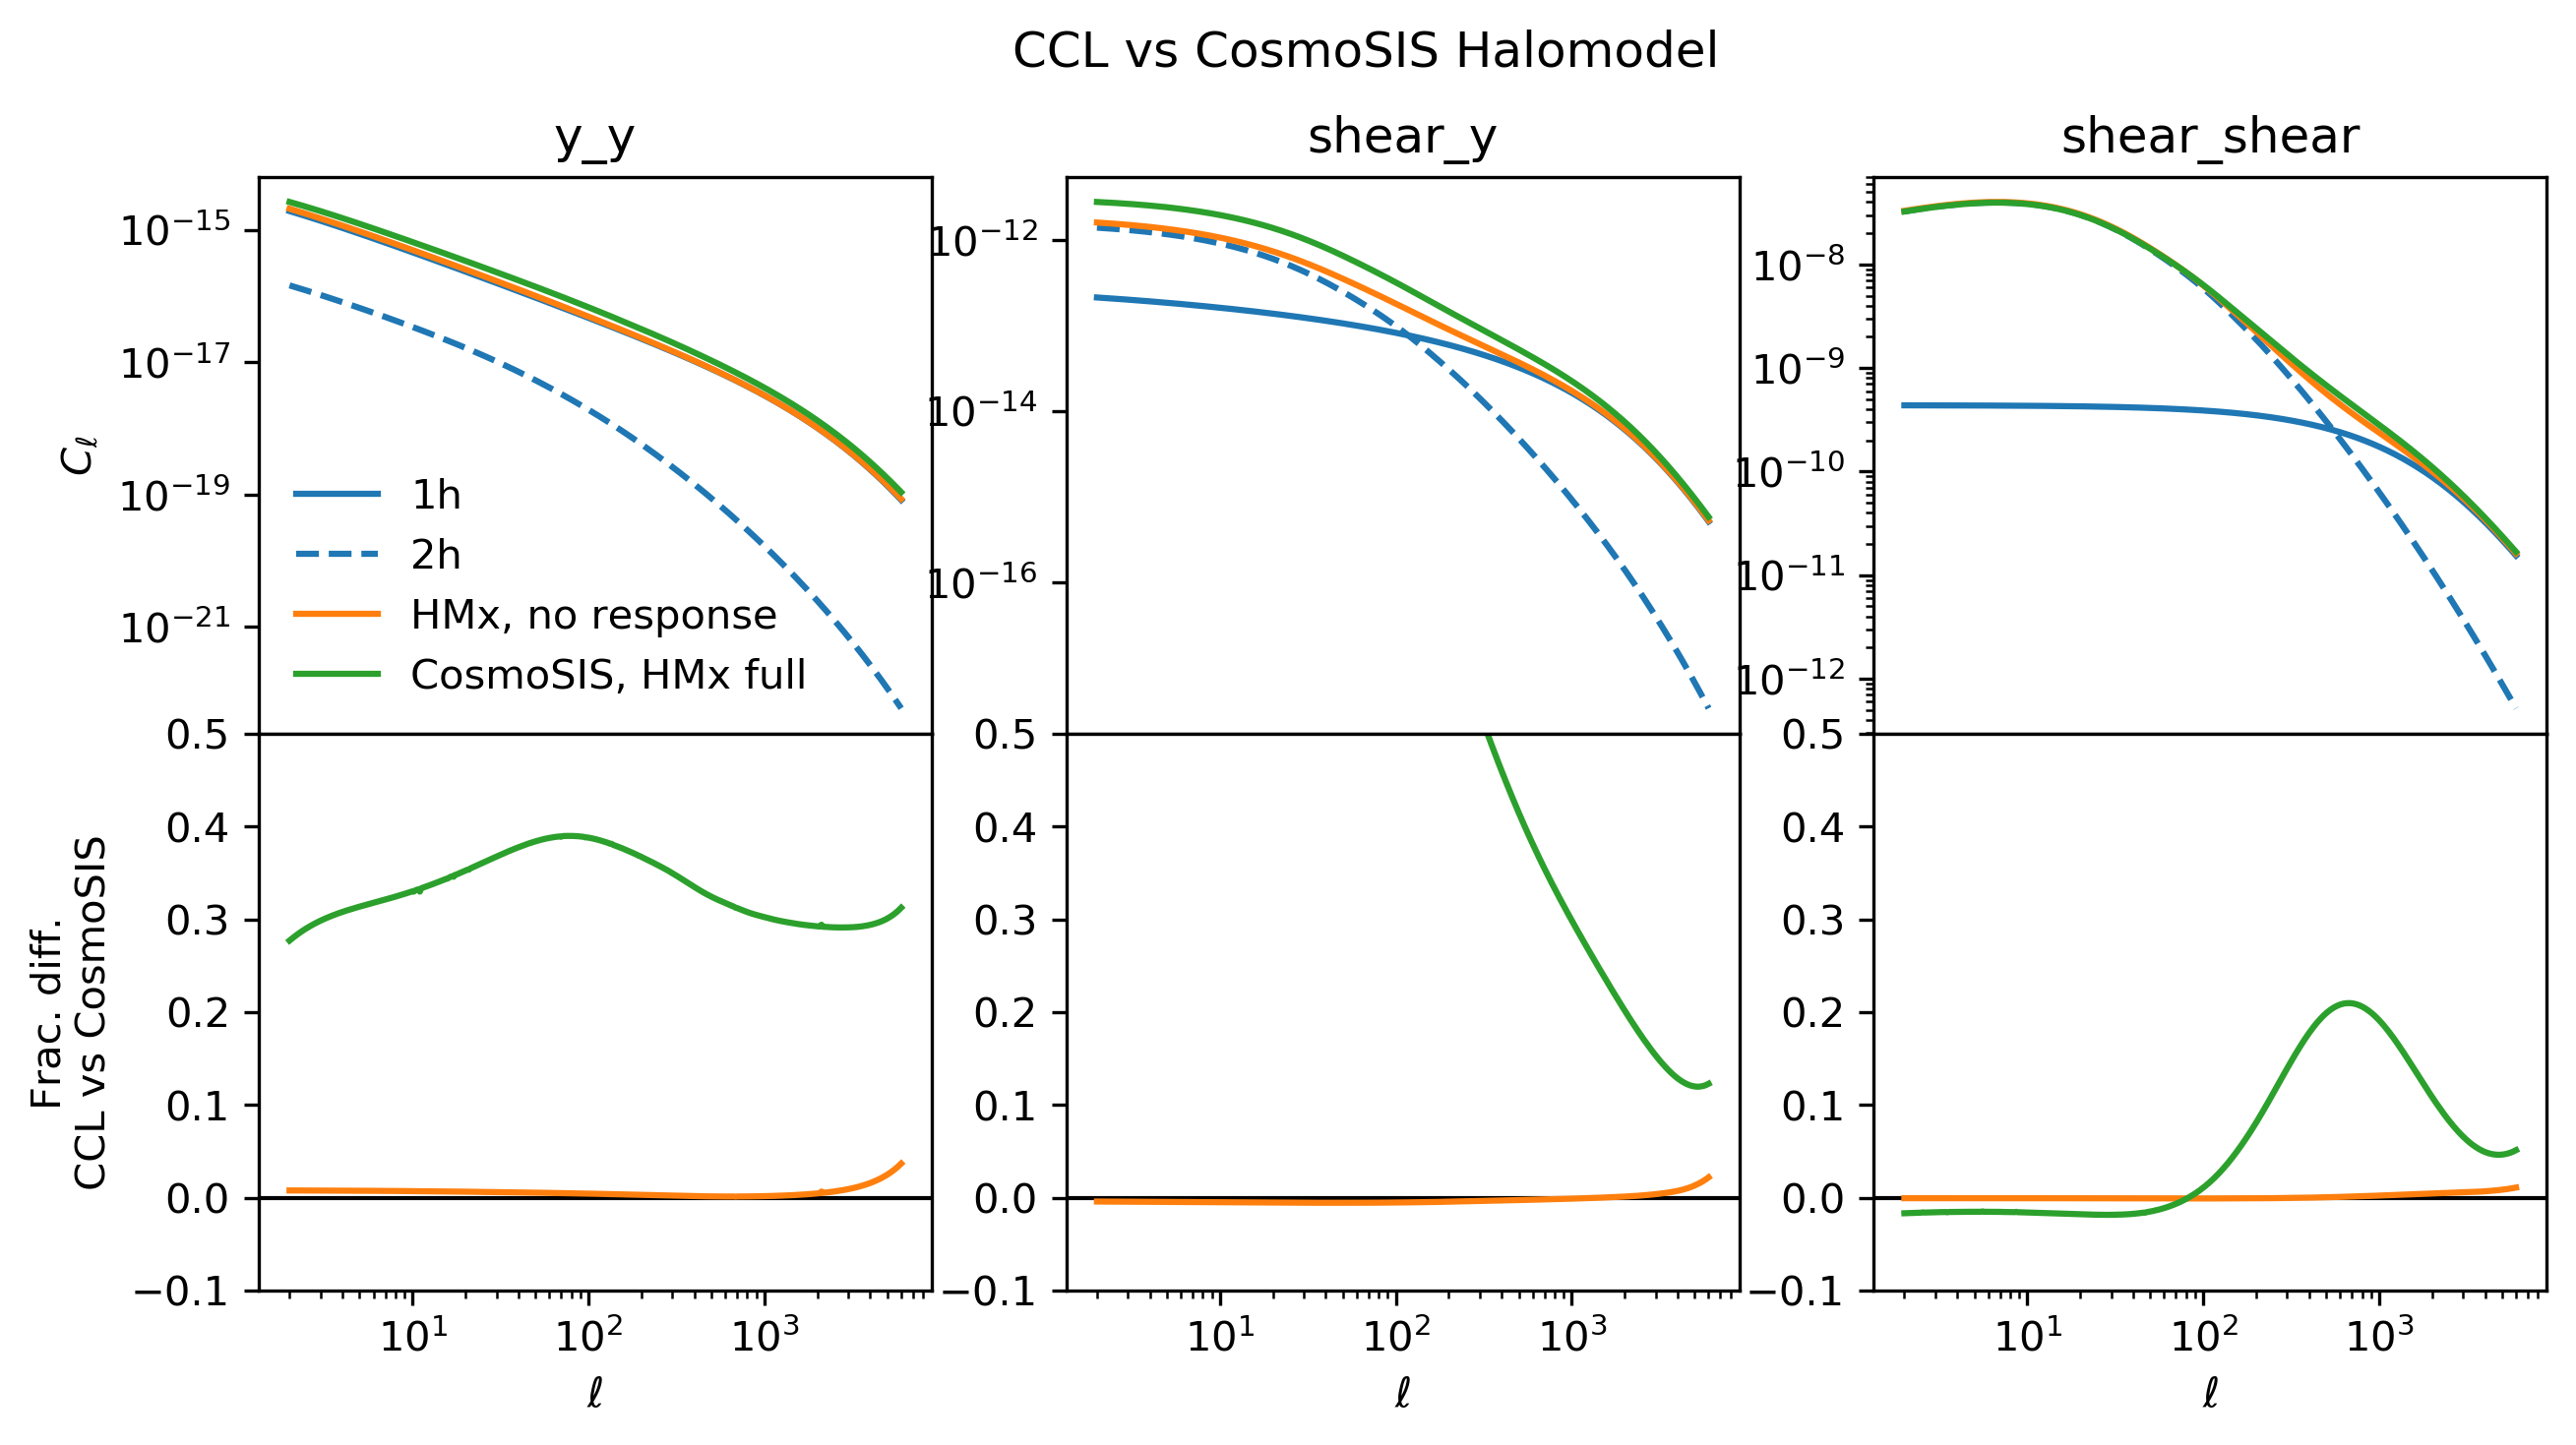

In [318]:
# cosmosis_block = blocks["cov"]

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(10, 5))
fig.subplots_adjust(hspace=0)

WL_bin = 5

h = cosmosis_block["cosmological_parameters", "h0"]

ccl_cosmo = ccl.Cosmology(Omega_c=cosmosis_block["cosmological_parameters", "omega_c"],
                          Omega_b=cosmosis_block["cosmological_parameters", "omega_b"],
                          A_s=cosmosis_block["cosmological_parameters", "a_s"],
                          n_s=cosmosis_block["cosmological_parameters", "n_s"],
                          h=cosmosis_block["cosmological_parameters", "h0"],
                          m_nu=cosmosis_block["cosmological_parameters", "mnu"],
                                    )

a = 1/(1+cosmosis_block["pressure_pressure_power_spectrum", "z"][::-1])

tSZ_tracer = ccl.tSZTracer(ccl_cosmo, z_max=cosmosis_block["pressure_pressure_power_spectrum", "z"][-1], n_chi=500
                          )

WL_tracer = ccl.WeakLensingTracer(ccl_cosmo, 
                                  dndz=(cosmosis_block["nz_kids1000", "z"], 
                                        cosmosis_block["nz_kids1000", f"bin_{WL_bin}"])
                                 )

ell = cosmosis_block["y_y_cl", "ell"]

ccl_limber_shear_fac = np.sqrt((ell-1)*ell*(ell+1)*(ell+2))/(ell+1/2)**2

Cl_halomodel = {}
Cl_hmx = {}
tracers = [("shear", "matter", WL_tracer),
           ("y", "pressure", tSZ_tracer),
           ]

limber_scaling = {("shear","shear"): 1/ccl_limber_shear_fac**2,
                  ("shear","y"): 1/ccl_limber_shear_fac,
                  ("y","y"): 1}


for i, (name1, field1, tracer1) in enumerate(tracers):
    for j, (name2, field2, tracer2) in enumerate(tracers[i:]):
        Cl_hmx[f"{name1}_{name2}"] = ccl.angular_cl(
                                ccl_cosmo, cltracer1=tracer1, cltracer2=tracer2,
                                ell=ell,
                                p_of_k_a=pk_hmx[f"{field1}-{field2}-no_response_no_twhim"],
                               )*limber_scaling[(name1,name2)]
        
        for term in ["1h", "2h"]:
            Cl_halomodel[f"{name1}_{name2}-{term}"] = ccl.angular_cl(
                                ccl_cosmo, cltracer1=tracer1, cltracer2=tracer2,
                                ell=ell,
                                p_of_k_a=pk_halomodel[f"{field1}-{field2}-{term}"],
                               )*limber_scaling[(name1,name2)]
            
for idx, probes in enumerate(["y_y", "shear_y", "shear_shear"]):
    Cl_1h = Cl_halomodel[f"{probes}-1h"]
    Cl_2h = Cl_halomodel[f"{probes}-2h"]
    if probes == "y_y":
        Cl_cosmosis = cosmosis_block[f"{probes}_cl", f"bin_1_1"]
    elif probes == "shear_y":
        Cl_cosmosis = cosmosis_block[f"{probes}_cl", f"bin_{WL_bin}_1"]
    else:
        Cl_cosmosis = cosmosis_block[f"shear_cl", f"bin_{WL_bin}_{WL_bin}"]
        
    ax[0,idx].loglog(ell, Cl_1h, c="C0", ls="-", label="1h")
    ax[0,idx].loglog(ell, Cl_2h, c="C0", ls="--", label="2h")
    ax[0,idx].loglog(ell, Cl_hmx[probes], c="C1", ls="-", label="HMx, no response")
    ax[0,idx].loglog(ell, Cl_cosmosis, c="C2", ls="-", label="CosmoSIS, HMx full")
    ax[1,idx].semilogx(ell, Cl_hmx[probes]/(Cl_1h+Cl_2h)-1, c="C1", ls="-")
    ax[1,idx].semilogx(ell, Cl_cosmosis/(Cl_1h+Cl_2h)-1, c="C2", ls="-")
    ax[0,idx].set_title(probes)


ax[0,0].set_ylabel("$C_\ell$")
ax[1,0].set_ylabel("Frac. diff.\nCCL vs CosmoSIS")

[a.axhline(0, c="k", lw=1, zorder=-100) for a in ax[1]]
[a.set_ylim(-0.1, 0.5) for a in ax[1]]
[a.set_xlabel("$\ell$") for a in ax[1]]

ax[0,0].legend(frameon=False)

fig.suptitle("CCL vs CosmoSIS Halomodel")
fig.dpi = 300
fig.savefig("plots/CosmoSIS_vs_CCL_halo_model.png")

In [37]:
mass_def = ccl.halos.MassDef("vir", 'matter')
hmf = ccl.halos.MassFuncSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(ccl_cosmo, mass_def=mass_def, mass_def_strict=False, use_delta_c_fit=True)
hmc = ccl.halos.HMCalculator(ccl_cosmo, hmf, hbf, mass_def)

a = np.linspace(1/(1+6), 1.0, 32)
k = np.logspace(-4, 1.5, 100)

tk3D = ccl.halos.halomod_Tk3D_1h(cosmo=ccl_cosmo, hmc=hmc,
                    prof1=HMX_profiles.matter_profile, 
                    prof2=HMX_profiles.matter_profile, prof12_2pt=None,
                    prof3=HMX_profiles.pressure_profile, 
                    prof4=HMX_profiles.pressure_profile, prof34_2pt=None,
                    lk_arr=np.log(k), a_arr=a,
                    use_log=True)

ell_coarse = np.linspace(2, B_cov.shape[1], 100)
ell = np.arange(B_cov.shape[1])

WL_tracers = [ccl.WeakLensingTracer(ccl_cosmo, 
                                  dndz=(cosmosis_block["nz_kids1000", "z"], 
                                        cosmosis_block["nz_kids1000", f"bin_{WL_bin}"])
                                 ) for WL_bin in [1,2,3,4,5]]
tSZ_tracer = ccl.tSZTracer(ccl_cosmo, z_max=6.0, n_chi=500
                         )

beam = create_beam_operator(ell, fwhm=10.0)

cov_NG = np.zeros((len(WL_tracers), len(WL_tracers), n_ell_bin, n_ell_bin))

for i, WL_tracer1 in enumerate(WL_tracers):
    for j, WL_tracer2 in enumerate(WL_tracers[:i+1]):
        cov_coarse = ccl.angular_cl_cov_cNG(cosmo=ccl_cosmo,
                               cltracer1=WL_tracer1, cltracer2=WL_tracer2,
                               cltracer3=tSZ_tracer, cltracer4=tSZ_tracer,
                               ell=ell_coarse,
                               tkka=tk3D, fsky=fsky_eff)
        cov = np.exp(scipy.interpolate.RectBivariateSpline(
                                            ell_coarse, ell_coarse, 
                                            np.log(cov_coarse))(ell, ell))
        cov = beam @ cov @ beam
        
        cov_NG[i, j] = B @ cov @ B.T

cov_NG_matrix = np.zeros((40,40))
for i in range(cov_NG.shape[0]):
    for j in range(cov_NG.shape[0])[:i+1]:
        cov_NG_matrix[i*n_ell_bin:(i+1)*n_ell_bin, j*n_ell_bin:(j+1)*n_ell_bin] = cov_NG[i,j]
        if i != j:
            cov_NG_matrix[j*n_ell_bin:(j+1)*n_ell_bin, i*n_ell_bin:(i+1)*n_ell_bin] = cov_NG[i,j]

plt.imshow(cov_NG_matrix)

# Namaster estiamtes

In [312]:
import pymaster as nmt

shear_mask = healpy.read_map("../data/shear_maps_KiDS1000/z0.9-1.2/doublet_mask.fits", verbose=False)
shear_mask[shear_mask == healpy.UNSEEN] = 0
shear_weight = healpy.read_map("../data/shear_maps_KiDS1000/z0.9-1.2/doublet_weight.fits", verbose=False)
shear_weight[shear_weight == healpy.UNSEEN] = 0
shear_weight = shear_weight * shear_mask

y_mask = healpy.read_map("../data/y_maps/polspice/milca/singlet_mask.fits", verbose=False)
y_mask[y_mask == healpy.UNSEEN] = 0

/Users/yooken/Codes/miniconda/envs/analysis/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [313]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_y = nmt.NmtField(y_mask, 
                   [healpy.read_map("../data/y_maps/polspice/milca/triplet.fits", field=0, verbose=False)],
                   n_iter=1)

In [316]:
f_shear = nmt.NmtField(shear_mask, 
                       read_partial_map("../data/shear_maps_KiDS1000/z0.9-1.2/triplet.fits", 
                                        fields=[2,1], fill_value=0, scale=[1,1]),
                       n_iter=1)

In [317]:
# Initialize binning scheme with 4 ells per bandpower
ell = np.arange(spice_kernel.shape[1])

nmt_bins = nmt.NmtBin(nside=2048, 
               bpws=make_binning_operator(x=ell, x_min=ell_min, x_max=ell_max, n_bin=n_ell_bin, 
                                          binning="log", namaster=True),
               ells=ell, weights=2*ell+1)

nmt_workspace = nmt.NmtWorkspace()
nmt_workspace.compute_coupling_matrix(f_y, f_shear, nmt_bins)

In [318]:
def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled

def bin_theory(cl, wsp):
    return wsp.decouple_cell(wsp.couple_cell(cl))

Cl_y_shear_namaster = compute_master(f_y, f_shear, nmt_workspace)
ell_namaster = nmt_bins.get_effective_ells()


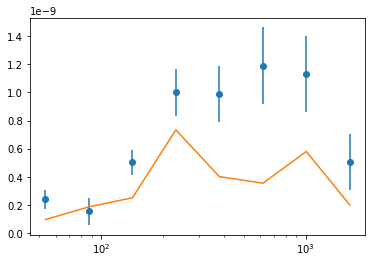

In [321]:
ell, Cl = Cl_y_shear[(0.9,1.2)]["milca"]["ell_binned"], Cl_y_shear[(0.9,1.2)]["milca"]["Cl_TE_binned"]
cov = cov_y_shear["milca"][128]["TE"]
error = np.sqrt(np.diag(cov)[B.shape[0]*i:B.shape[0]*(i+1)])
u = ell**2/(2*pi)
    
plt.errorbar(ell, u*Cl, u*error, ls="none", marker="o", label="PolSpice")

u = ell_namaster**2/(2*pi)

plt.plot(ell_namaster, u*Cl_y_shear_namaster[0])
plt.xscale("log")

In [160]:
cl_theory = Cl_y_shear_theory["cov"][(0.5,0.7)]["Cl"]
cl_theory = np.pad(cl_theory, (0, nmt_workspace.wsp.lmax - len(cl_theory)+1))

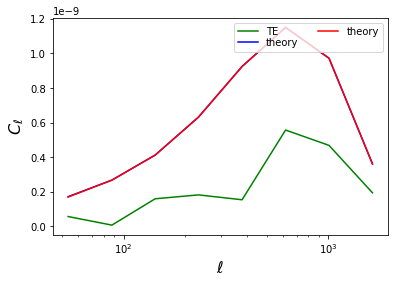

In [161]:
# Plot results
ell_namaster = nmt_bins.get_effective_ells()
#plt.plot(ell_arr, cl_00[0], 'r-', label='TT')
plt.plot(ell_arr, ell_arr**2/(2*pi)*cl_y_shear[0], 'g-', label='TE')
plt.plot(ell_arr, ell_arr**2/(2*pi)*bin_theory(np.array([cl_theory, np.zeros_like(cl_theory)]), nmt_workspace)[0], 'b-', label='theory')
plt.plot(ell_arr, ell_arr**2/(2*pi)*Cl_y_shear_theory["cov"][(0.5,0.7)]["Cl_binned"], 'r-', label='theory')

#plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
#plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.xscale("log")
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)

In [155]:
np.mean(shear_mask[shear_mask>0]), np.mean(y_mask[y_mask>0])

(39.41786993354775, 1.0)

In [112]:
cl_theory.shape

(6143,)

In [63]:
hdu[1].data.names[1]

'kappa'

In [315]:
def read_partial_map(path, fields, fill_value=healpy.UNSEEN, scale=None):
    maps = []
    with astropy.io.fits.open(path) as hdu:
        for i, field in enumerate(fields):
            nside = hdu[field].header["nside"]
            m = np.full(healpy.nside2npix(nside), fill_value=fill_value, dtype=np.float32)
            name = hdu[field].data.names[1]
            m[hdu[field].data["pixel"]] = hdu[field].data[name]
            if scale is not None:
                m[hdu[field].data["pixel"]] *= scale[i]
            maps.append(m)
    
    return maps

read_partial_map("../data/shear_maps_KiDS1000/z0.9-1.2/triplet.fits", fields=[1,2], fill_value=0, scale=[0,-1])
            

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]